## Contents of This Notebook

Click on the section and go to this cell immediately.

* [Section 1. Identifying Stationarity](#section_1)
* [Section 2. Nonstationary-to-Stationary Transformations](#section_2)
* [Section 3. Training and Validation ARIMA models](#section_3)
* [Conclusion](#conclusion)


Before running this notebook use a new conda env with python 3.7 and requirements.txt file.

When you use Run All button with this notebook, you should wait approx. 5 mins to get output of all cells.

## General Configuration

In [1]:
import os
import sys
import math
import sklearn
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as ss
import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime, date, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from utils import run_simple_sequence_plot, run_sequence_plot, logger
from constants import *

In [2]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

## Python & Library Versions

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("statsmodels", ss.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.4
statsmodels 0.12.2
seaborn     0.11.2
sklearn     1.0.2


## Inspect Dataset

In [4]:
hourly_radiation_df = pd.read_csv(os.path.join("..", "data", "dataset1_HourlySolarRadiationProcessed.csv"))
hourly_radiation_df.head()

Hourly_DateTime  Radiation  Temperature  Pressure  Humidity  \
0  2016-10-01 00:00:00       1.26        48.50     30.45     88.25   
1  2016-10-01 01:00:00       1.27        50.42     30.44     98.92   
2  2016-10-01 02:00:00       1.28        50.08     30.43    100.00   
3  2016-10-01 03:00:00       1.27        50.17     30.43    100.00   
4  2016-10-01 04:00:00       1.27        50.17     30.43    100.17   

   WindDirection(Degrees)  Speed  ZenithDeviation  Year  Month  Day  Hour  \
0                  153.25   9.98           697.62  2016     10    1     0   
1                  145.18   8.06           644.50  2016     10    1     1   
2                  136.54   6.84           584.50  2016     10    1     2   
3                  132.10   5.34           524.50  2016     10    1     3   
4                  117.02   6.75           464.50  2016     10    1     4   

   Log_Radiation  
0           0.23  
1           0.24  
2           0.24  
3           0.24  
4           0.24

In [5]:
hourly_radiation_df.columns

Index(['Hourly_DateTime', 'Radiation', 'Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed', 'ZenithDeviation', 'Year', 'Month',
       'Day', 'Hour', 'Log_Radiation'],
      dtype='object')

In [6]:
print(f'Data time range: from {hourly_radiation_df.Hourly_DateTime.unique().min()} to {hourly_radiation_df.Hourly_DateTime.unique().max()}')

Data time range: from 2016-10-01 00:00:00 to 2016-11-29 00:00:00


In [7]:
hourly_radiation_df.index = hourly_radiation_df.Hourly_DateTime

In [8]:
hourly_radiation_df.drop(['Hourly_DateTime'], axis=1, inplace=True)

<a id='section_1'></a>
## Section 1. Identifying Stationarity

Before using models, we need to be sure that our dataset is stationary, since on stationary datasets models can learn patterns better and show higher performance score.

A stationary time series is a time series where there are no changes in the underlying system.

Its properties:
▪ Constant mean (no trend)
▪ Constant variance (no heteroscedacticity)
▪ Constant autocorrelation structure
▪ No periodic component (no seasonality)

Let's identify if our dataset is stationary. And the first step is to run sequence plots to find out if there is underlying structure and look for trend, seasonality, and autocorrelation.


In [9]:
# run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [All period]')

In [10]:
# run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [All period]')

In [11]:
# from_datetime = datetime(year=2016, month=10, day=1, hour=0)
# run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One month period]',
#                   from_datetime=from_datetime,
#                   to_datetime=from_datetime + timedelta(days=30))
#
# run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One month period]',
#                   from_datetime=from_datetime,
#                   to_datetime=from_datetime + timedelta(days=30))

In [12]:
# from_datetime = datetime(year=2016, month=11, day=21, hour=0)
# run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One week period]',
#                   from_datetime=from_datetime,
#                   to_datetime=from_datetime + timedelta(days=7))
#
# run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One week period]',
#                   from_datetime=from_datetime,
#                   to_datetime=from_datetime + timedelta(days=7))

In [13]:
# from_datetime = datetime(year=2016, month=11, day=27, hour=0)
# run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One day period]',
#                   from_datetime=from_datetime,
#                   to_datetime=from_datetime + timedelta(days=1))
#
# run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One day period]',
#                   from_datetime=from_datetime,
#                   to_datetime=from_datetime + timedelta(days=1))

### Summary Statistics & Plots (additive hypothesis)

First way to check for constant mean and variance is to chop up the data into separate chunks, let's calculate statistics for each chunk, and compare

In [14]:
hourly_radiation_df.head()

Radiation  Temperature  Pressure  Humidity  \
Hourly_DateTime                                                   
2016-10-01 00:00:00       1.26        48.50     30.45     88.25   
2016-10-01 01:00:00       1.27        50.42     30.44     98.92   
2016-10-01 02:00:00       1.28        50.08     30.43    100.00   
2016-10-01 03:00:00       1.27        50.17     30.43    100.00   
2016-10-01 04:00:00       1.27        50.17     30.43    100.17   

                     WindDirection(Degrees)  Speed  ZenithDeviation  Year  \
Hourly_DateTime                                                             
2016-10-01 00:00:00                  153.25   9.98           697.62  2016   
2016-10-01 01:00:00                  145.18   8.06           644.50  2016   
2016-10-01 02:00:00                  136.54   6.84           584.50  2016   
2016-10-01 03:00:00                  132.10   5.34           524.50  2016   
2016-10-01 04:00:00                  117.02   6.75           464.50  2016   

                     Month  Day  Hour  Log_Radiation  
Hourly_DateTime                                       
2016-10-01 00:00:00     10    1     0           0.23  
2016-10-01 01:00:00     10    1     1           0.24  
2016-10-01 02:00:00     10    1     2           0.24  
2016-10-01 03:00:00     10    1     3           0.24  
2016-10-01 04:00:00     10    1     4           0.24

In [15]:
hourly_radiation_df.shape

(1417, 12)

In [16]:
# Compare means and variances
radiation_statistics_df = pd.DataFrame()
radiation_statistics_df['Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].mean()
radiation_statistics_df['Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].var()
radiation_statistics_df[['Radiation_Mean', 'Radiation_Variance']]

Radiation_Mean  Radiation_Variance
Year Month Day                                    
2016 10    1        216.561667        97006.533328
           2        214.627083        82189.624787
           3        122.878333        25518.234945
           4        110.630417        22815.296309
           5        152.502083        42629.213104
           6        138.702917        49168.418013
           7        177.670417        76635.497622
           8        220.942500       107431.990950
           9        283.822500       141922.297541
           10       300.962917       154926.311726
           11       292.543750       145273.209372
           12       270.944583       125590.049895
           13       300.712500       154602.720880
           14       299.648750       153784.253481
           15       299.480833       154320.771208
           16       222.965833        93046.807521
           17       292.305000       147017.918270
           18       238.780000       109621.866565
           19       183.264167        71603.833591
           20       284.465417       142455.286009
           21       191.275833        90460.955712
           22       266.118333       137098.368432
           23       275.676250       139738.655677
           24       269.280000       136267.774322
           25       262.495000       133666.175409
           26       282.662917       141855.343474
           27       263.942917       126719.916856
           28       172.971667        55157.179154
           29       135.494167        33488.282286
           30       150.367500        54182.168976
           31       194.324167        71973.260478
     11    1        203.060000        74501.827209
           2        276.276250       138641.911929
           3        270.895417       133814.000191
           4        270.271667       133414.333606
           5        269.357917       132695.687730
           6        251.908750       129655.346438
           7        257.207917       123395.430539
           8        176.270000        79630.496974
           9        254.457083       121025.345909
           10       206.548333       100997.329597
           11       252.374167       119411.173443
           12       242.450833       119738.487869
           13       257.938750       124066.628481
           14       179.550417        63043.329648
           15       215.356667        84356.043893
           16       258.963333       125136.390249
           17       242.101250       111937.573081
           18       216.232083        95801.963974
           19       229.306667       103572.455075
           20       184.270000        66550.926983
           21       197.458333        83191.779006
           22       145.492083        40151.649243
           23       222.474167       100461.397251
           24       181.434583        64078.135556
           25       186.511667        78501.003388
           26       231.417083        98278.341735
           27       239.648333       110468.589258
           28       249.219167       117261.313704
           29         1.190000                 NaN

#### Histograms

<AxesSubplot:>

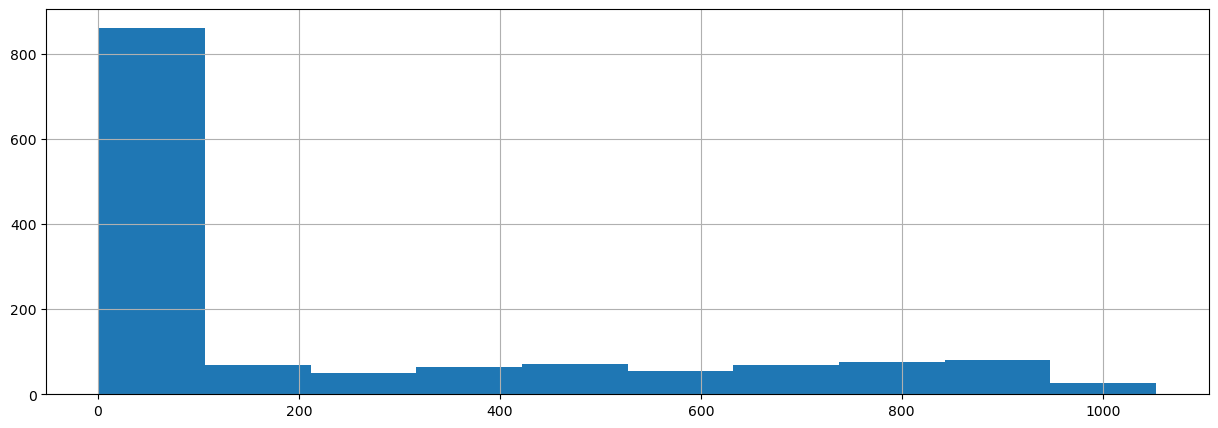

In [17]:
hourly_radiation_df.Radiation.hist()

<AxesSubplot:>

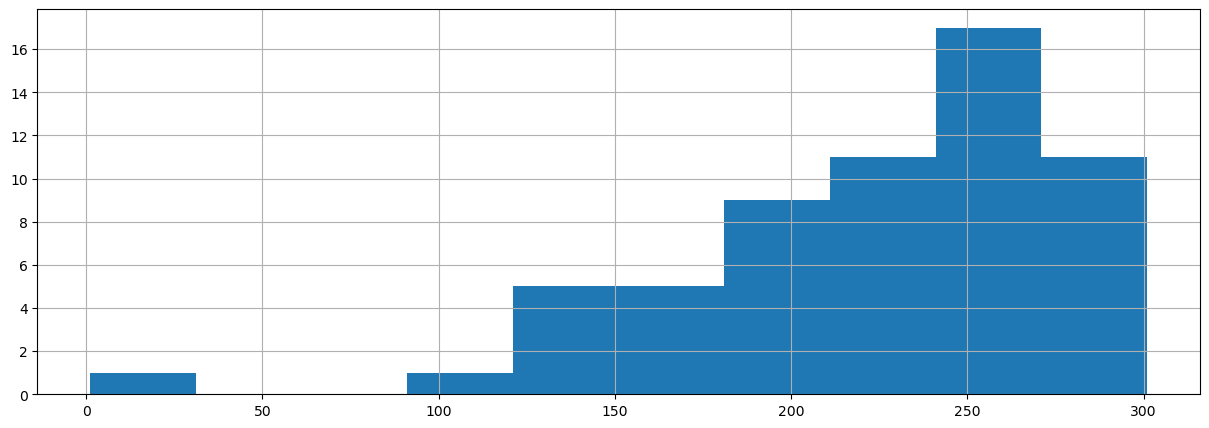

In [18]:
radiation_statistics_df['Radiation_Mean'].hist()

<AxesSubplot:>

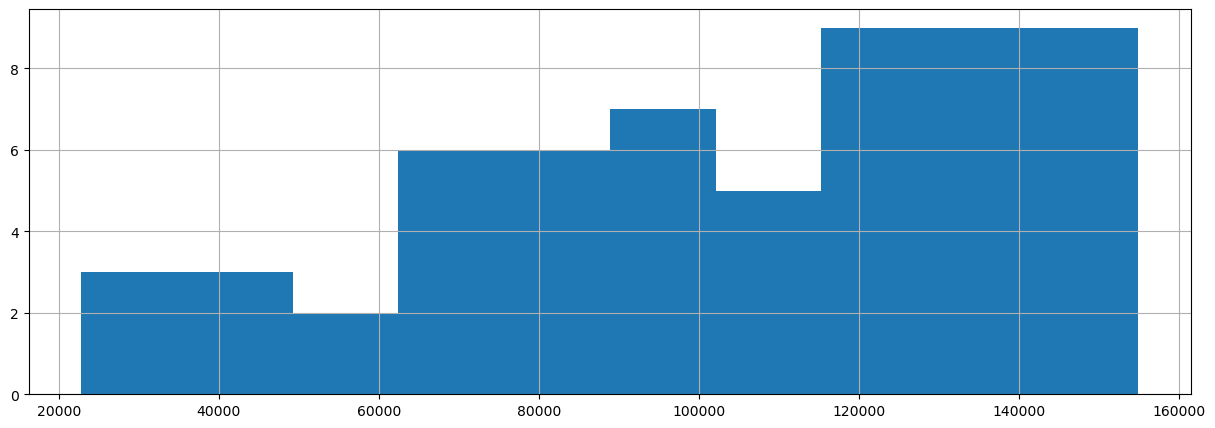

In [19]:
radiation_statistics_df['Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

What we need to know:
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

Like any statistical test we should set a significance level or threshold that determines whether we should accept or reject the null.
> The value 0.05 is common but depends upons numerous factors.

In [20]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df['Radiation'], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -3.2157642487980076
p-value: 0.0190901251829467


In [21]:
def test_stationarity(df, ts_column):
    # Determining rolling statistics
    rolmean = df[ts_column].rolling(window=12, center=False).mean()
    rolstd = df[ts_column].rolling(window=12, center=False).std()

    # Plot rolling statistics:
    orig = plt.plot(df[ts_column], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts_column], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic',
                                'p-value',
                                '# Lags Used',
                                'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

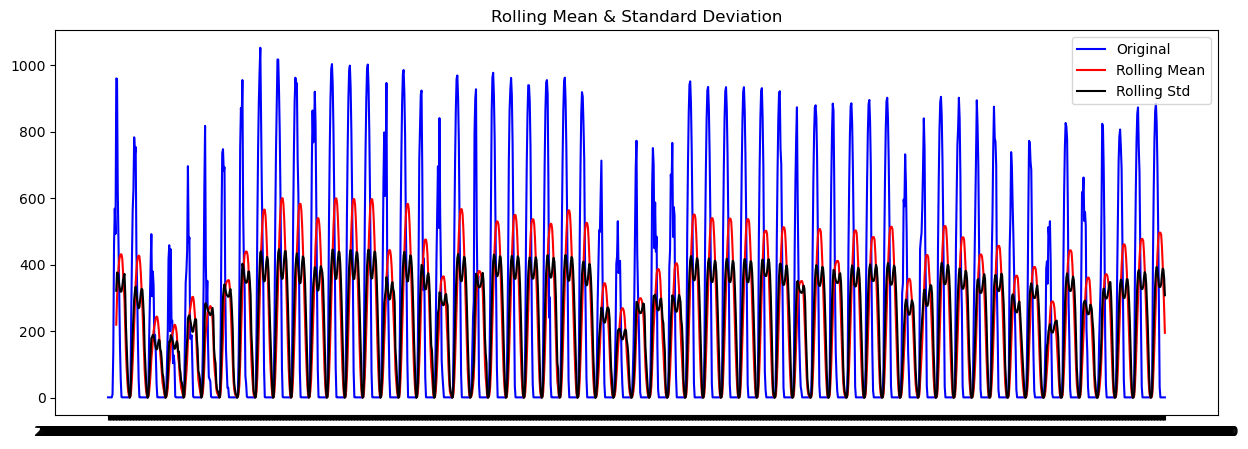

Results of Dickey-Fuller Test:
Test Statistic                   -3.215764
p-value                           0.019090
# Lags Used                      24.000000
Number of Observations Used    1392.000000
Critical Value (1%)              -3.435056
Critical Value (5%)              -2.863619
Critical Value (10%)             -2.567877
dtype: float64


In [22]:
test_stationarity(hourly_radiation_df, 'Radiation')

#### Explanation (additive hypothesis)

Based on augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
However, it is not certainly correct, since from sequence plots we can see clear seasonality of 24 hours, and also from histograms about statistics for different chunks the dataset does not have constant mean and constant variance. That's why our dataset is **non-stationary.**

---

### Summary Statistics & Plots (multiplicative hypothesis)

In [23]:
# Compare means and variances
radiation_statistics_df['Log_Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])[
    'Log_Radiation'].mean()
radiation_statistics_df['Log_Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])[
    'Log_Radiation'].var()

#### Histograms

<AxesSubplot:>

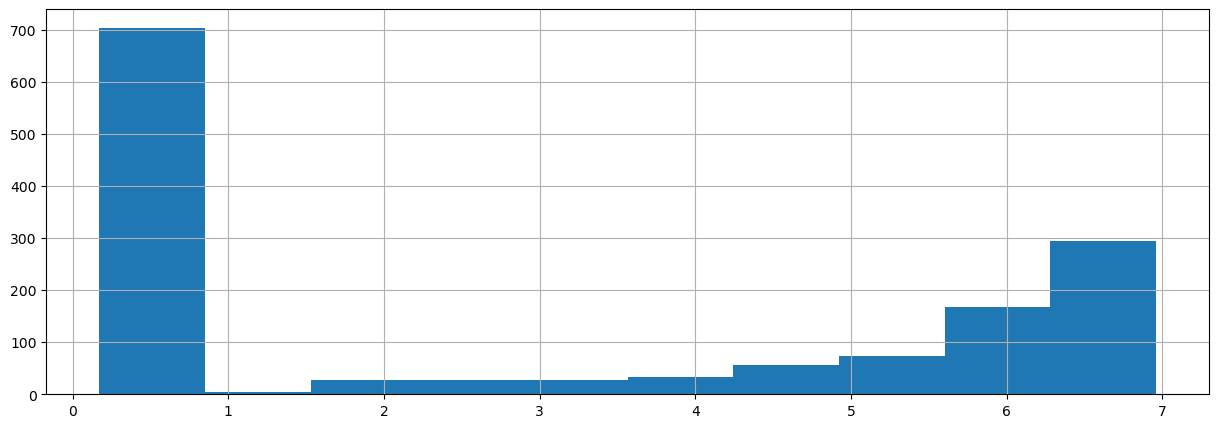

In [24]:
hourly_radiation_df.Log_Radiation.hist()

<AxesSubplot:>

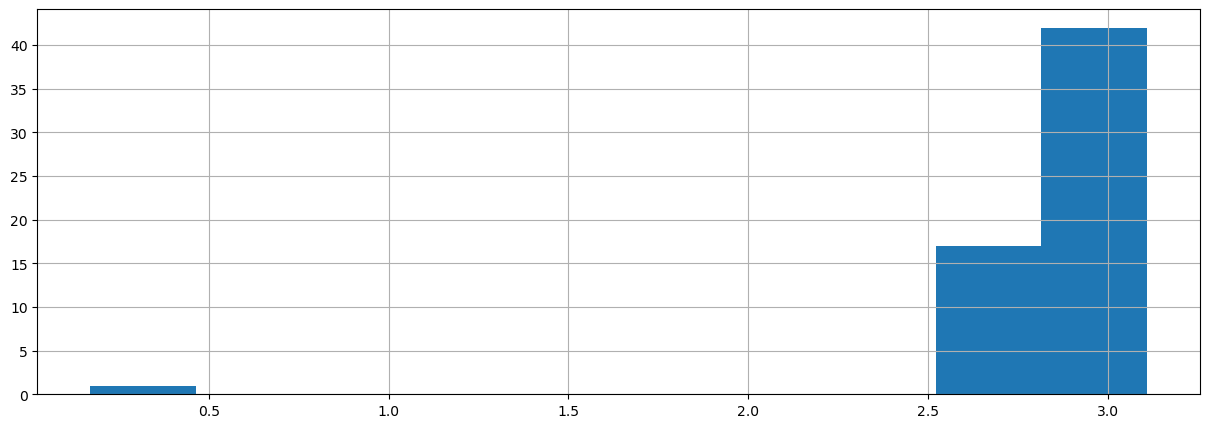

In [25]:
radiation_statistics_df['Log_Radiation_Mean'].hist()

<AxesSubplot:>

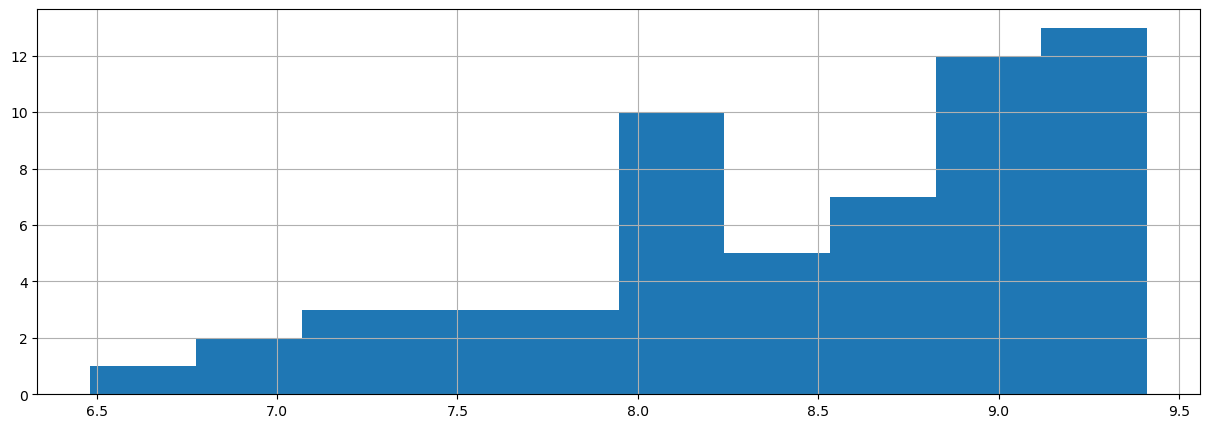

In [26]:
radiation_statistics_df['Log_Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

In [27]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df.Log_Radiation, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -3.534937810275096
p-value: 0.007133865786702813


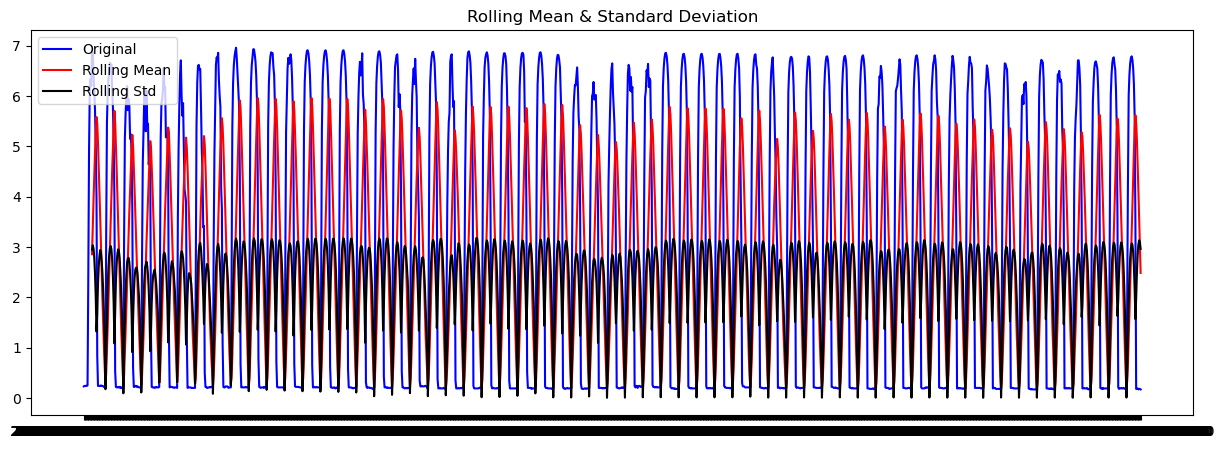

Results of Dickey-Fuller Test:
Test Statistic                   -3.534938
p-value                           0.007134
# Lags Used                      24.000000
Number of Observations Used    1392.000000
Critical Value (1%)              -3.435056
Critical Value (5%)              -2.863619
Critical Value (10%)             -2.567877
dtype: float64


In [28]:
test_stationarity(hourly_radiation_df, 'Log_Radiation')

#### Explanation (multiplicative hypothesis)

For multiplicative hypothesis we have pretty the same situations like for additive one.
Based on augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
However, it is not certainly correct, since from sequence plots we can see clear seasonality of 24 hours, and also from histograms about statistics for different chunks the dataset does not have constant mean and constant variance. That's why our dataset is **non-stationary.**

---

<a id='section_2'></a>
## Section 2. Nonstationary-to-Stationary Transformations

Let's create a few stationary time series from our non-stationary ones, to test which of them will give us the best score.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


def get_polynomial_trend_prediction(trend):
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=3)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.show()

    return polynomial_trend_prediction.flatten()

### Approach #1: Remove Trend & Seasonality with Statsmodels

#### Additive hypothesis

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=hourly_radiation_df.Radiation, model='additive', period=FORECAST_PERIOD)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

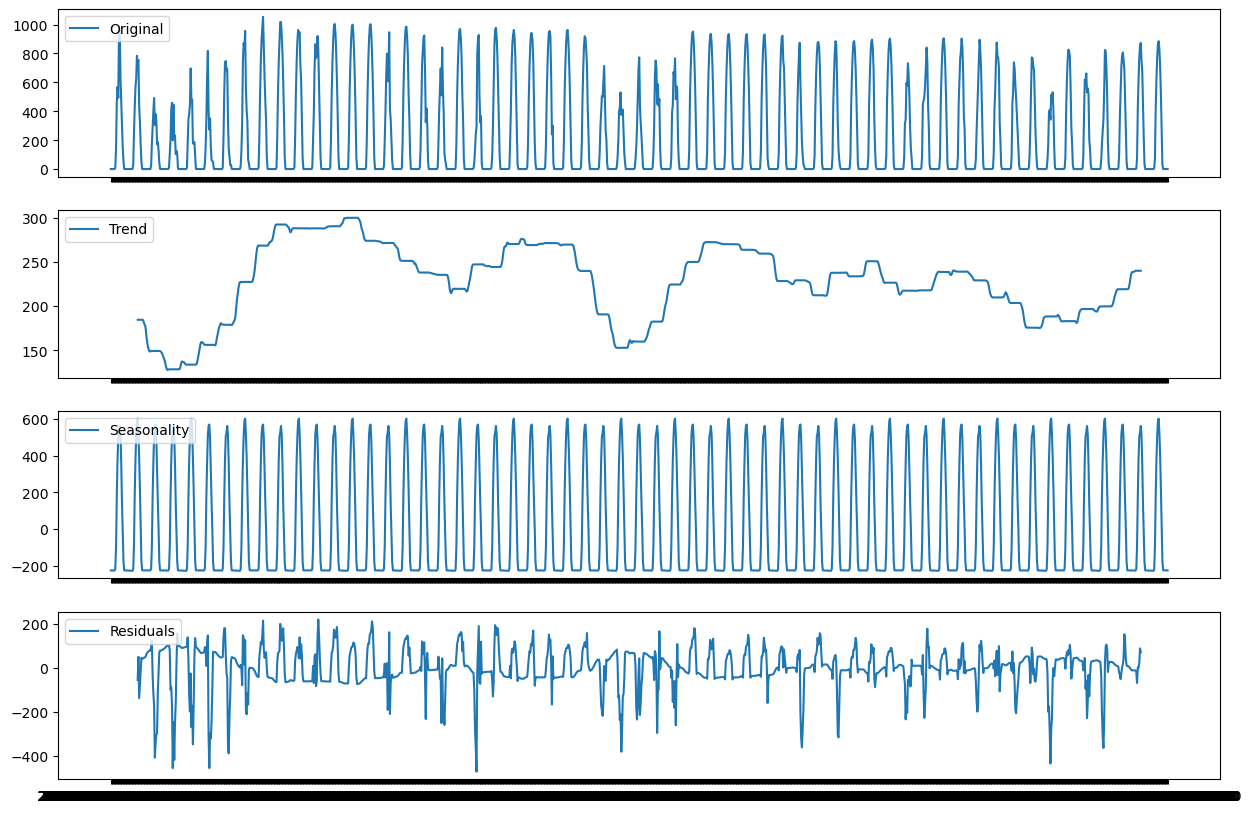

In [31]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(hourly_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left')

In [32]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -7.6604044763562475
p-value:  1.6946427395374124e-11


In [33]:
additive_decomposed_radiation = estimated_residual[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT].reset_index(drop=True)
additive_decomposed_trend = estimated_trend[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT].reset_index(drop=True)
additive_decomposed_seasonal = estimated_seasonal

Great now we see from ADF test and from plots that our additive_decomposed_radiation is **stationary**. Hence, we can use it for training models. Now we need just to extrapolate our trend to make forecast out of our dataset. For seasonality we just cut a part, which is equal to its period.

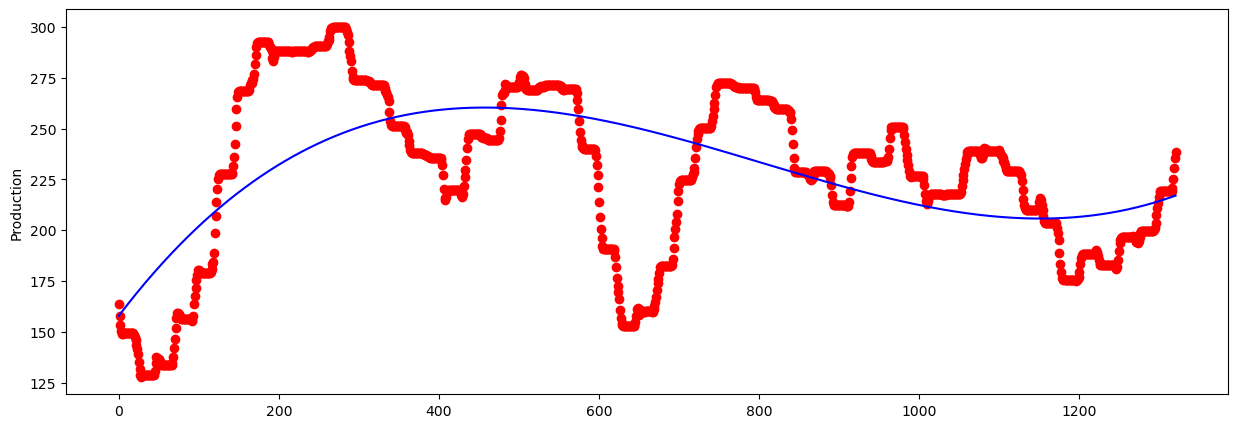

In [34]:
additive_decomposed_trend_prediction = get_polynomial_trend_prediction(additive_decomposed_trend)

Here are some reasons why we have such a descending line of trend:
* Even if the first dataset with meteorological data from the HI-SEAS weather station (Hawai), temperature also become less in that region in the winter time too.
* From other side, during the winter the sun's rays hit the Earth at a shallow angle. These rays are more spread out, which minimizes the amount of energy
that hits any given spot. Also, the long nights and short days prevent the Earth from warming up.

That's why that region has less temperature and **less solar radiation** closer to the winter time.

#### Multiplicative hypothesis

In [35]:
# Used model='multiplicative' to split on trend, seasonal and residuals
ss_decomposition = seasonal_decompose(x=hourly_radiation_df.Radiation, model='multiplicative', period=FORECAST_PERIOD)
estimated_trend2 = ss_decomposition.trend
estimated_seasonal2 = ss_decomposition.seasonal
estimated_residual2 = ss_decomposition.resid

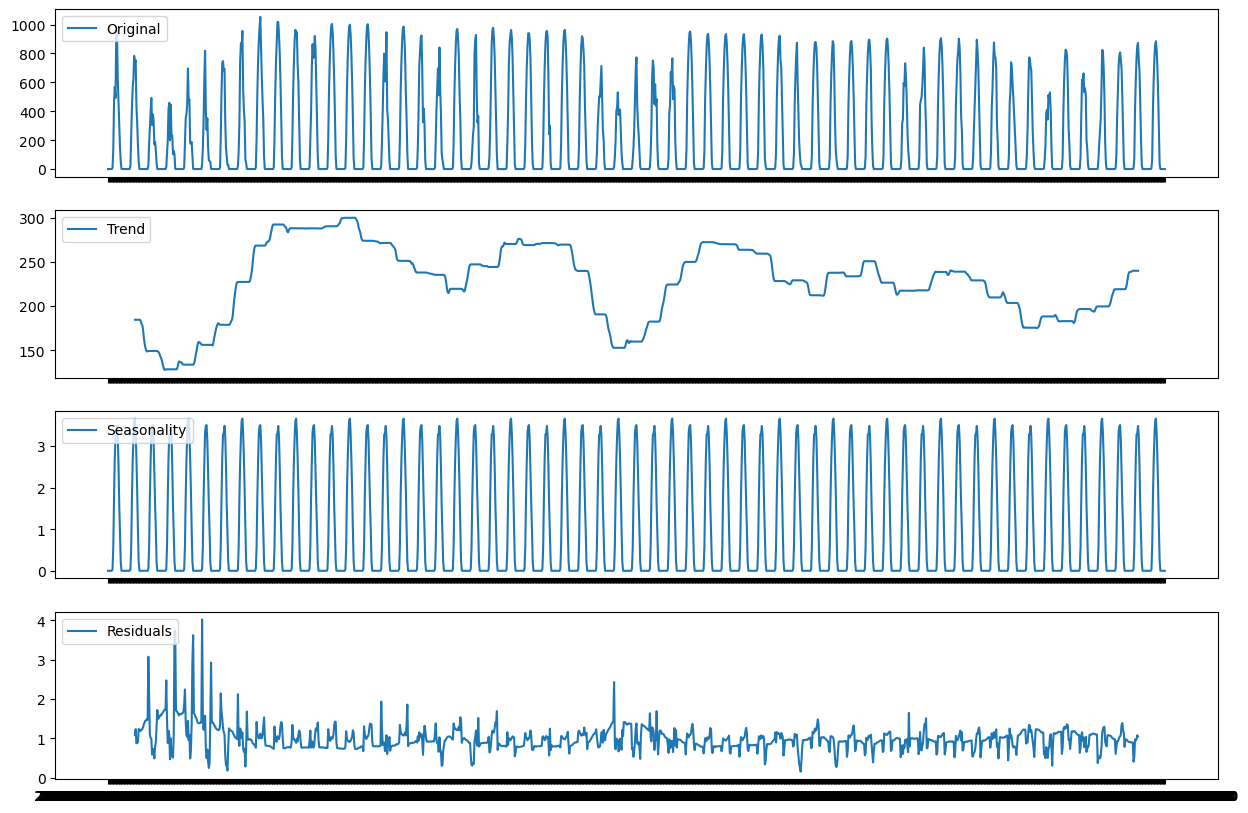

In [36]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(hourly_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend2, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal2, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual2, label='Residuals')
axes[3].legend(loc='upper left')

In [37]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual2[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -2.95059904612268
p-value:  0.03977250911465067


In [38]:
multiplicative_decomposed_radiation = estimated_residual2[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT].reset_index(drop=True)
multiplicative_decomposed_trend = estimated_trend2[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT].reset_index(drop=True)
multiplicative_decomposed_seasonal = estimated_seasonal2

Great now we see from ADF test and from plots that our multiplicative_decomposed_radiation is **stationary**. Hence, we can use it for training models. Now we need just to extrapolate our trend to make forecast out of our dataset. For seasonality we just cut a part, which is equal to its period.

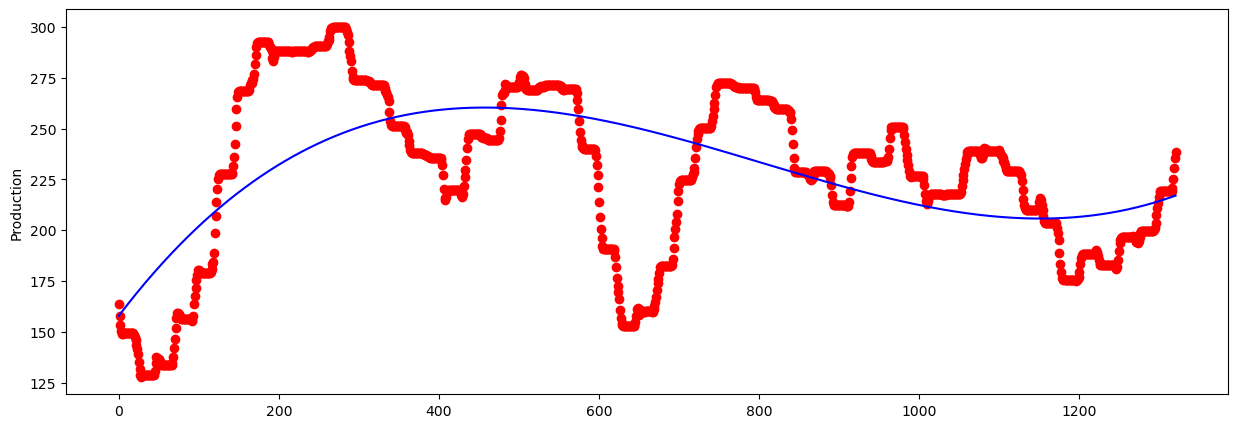

In [39]:
multiplicative_decomposed_trend_prediction = get_polynomial_trend_prediction(multiplicative_decomposed_trend)

### Approach #2: Log Transformation

As our time series of multiplicative hypothesis was non-stationary, so this approach did not help to make our initial dataset stationary.

### Approach #3: Removing Autocorrelation with Differencing

Let's subtract $O_{t-1}$ from $O_{t}$ where $O_{t}$ is the observed data at time *t* and $O_{t-1}$ is the observed data at *t-1*.

#### Additive hypothesis

Here ew use differencing approach with lag = 1 (to reduce trend) and lag = 12 (to reduce sessonality).

##### First difference

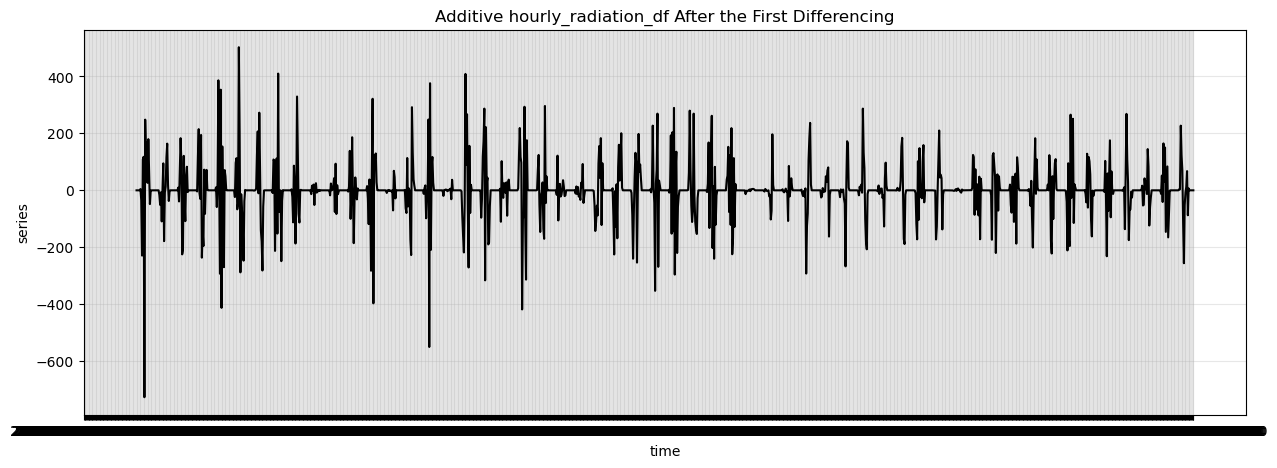

In [40]:
additive_diff_production_1 = hourly_radiation_df.Radiation.diff(FORECAST_PERIOD).diff(1)
run_simple_sequence_plot(hourly_radiation_df.index, additive_diff_production_1,
                         title="Additive hourly_radiation_df After the First Differencing")

In [41]:
additive_diff_production_1 = additive_diff_production_1[1 + FORECAST_PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -14.765779985176943
p-value:  2.363891680577934e-27


##### Second difference

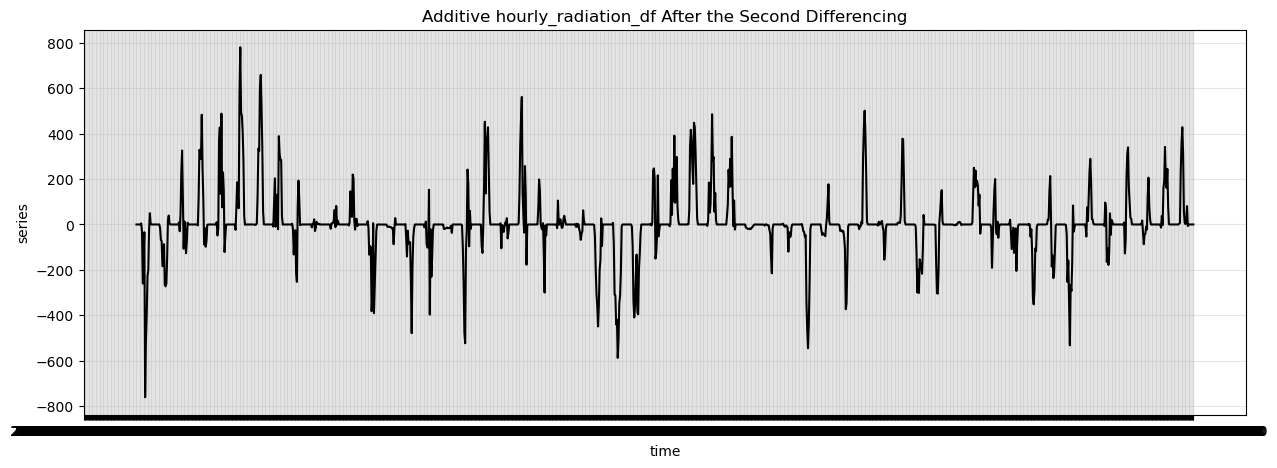

In [42]:
additive_diff_production_12 = hourly_radiation_df.Radiation.diff(FORECAST_PERIOD)
run_simple_sequence_plot(hourly_radiation_df.index, additive_diff_production_12,
                         title="Additive hourly_radiation_df After the Second Differencing")
additive_diff_production_12 = additive_diff_production_12[FORECAST_PERIOD:].reset_index(drop=True)

In [43]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -4.63840799387491
p-value:  0.00010967429140794987


#### Multiplicative hypothesis

##### First difference

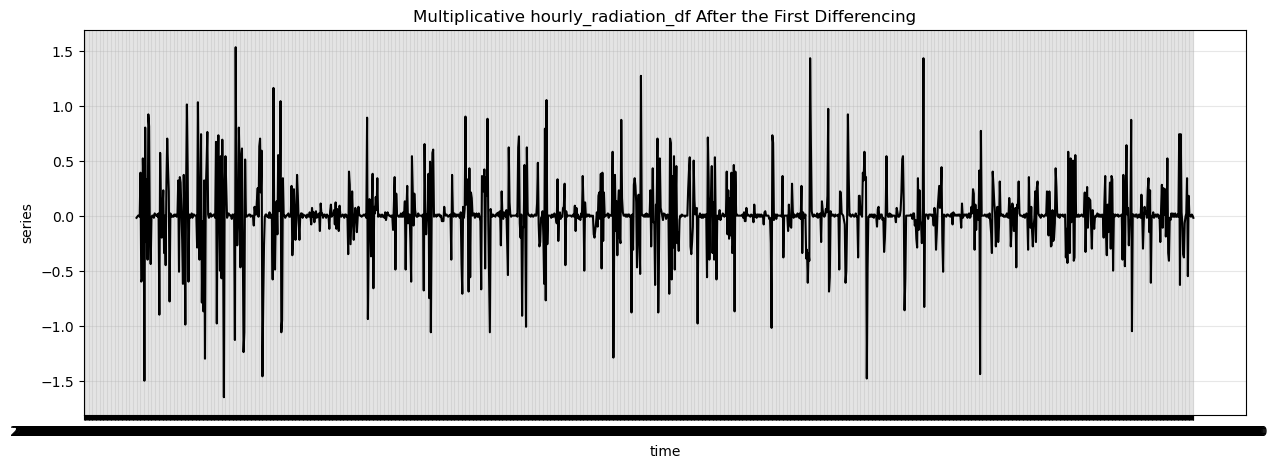

In [44]:
multiplicative_diff_production_1 = hourly_radiation_df.Log_Radiation.diff(FORECAST_PERIOD).diff(1)

run_simple_sequence_plot(hourly_radiation_df.index, multiplicative_diff_production_1,
                         title="Multiplicative hourly_radiation_df After the First Differencing")
multiplicative_diff_production_1 = multiplicative_diff_production_1[1 + FORECAST_PERIOD:].reset_index(drop=True)

In [45]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -15.201097174405673
p-value:  5.82814630345014e-28


##### Second difference

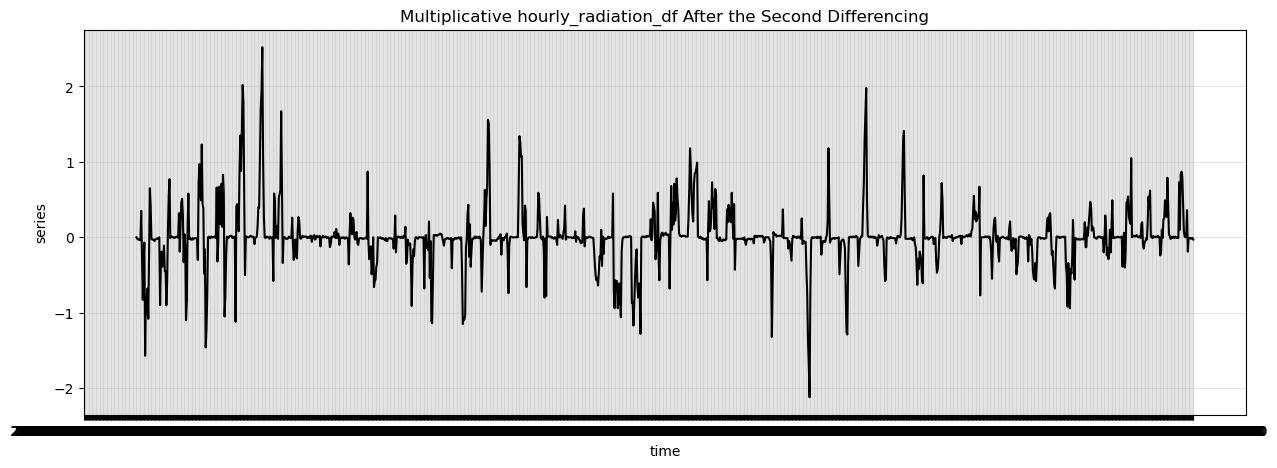

In [46]:
multiplicative_diff_production_12 = hourly_radiation_df.Log_Radiation.diff(FORECAST_PERIOD)

run_simple_sequence_plot(hourly_radiation_df.index, multiplicative_diff_production_12,
                         title="Multiplicative hourly_radiation_df After the Second Differencing")

In [47]:
multiplicative_diff_production_12 = multiplicative_diff_production_12[FORECAST_PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -5.319175852423047
p-value:  4.996444039215505e-06


**Note** that for both additive and multiplicative hypothesises we got stationary time series.

In [48]:
data_to_return_to_initial_series = {
    'additive_decomposed_radiation': {
        'predicted_trend': additive_decomposed_trend_prediction,
        'seasonality': additive_decomposed_seasonal
    },
    'multiplicative_decomposed_radiation': {
        'predicted_trend': multiplicative_decomposed_trend_prediction,
        'seasonality': multiplicative_decomposed_seasonal
    },
    'additive_diff_production_1': {
        'lag': 1
    },
    'multiplicative_diff_production_1': {
        'lag': 1
    },
    'additive_diff_production_12': {
        'lag': FORECAST_PERIOD
    },
    'multiplicative_diff_production_12': {
        'lag': FORECAST_PERIOD
    }
}

<a id='section_3'></a>
## Section 3. Training and Validation ARIMA models

In [49]:
# Create copy of the dataframe for convenience
hourly_radiation_reset_df = hourly_radiation_df.reset_index().copy()

In [50]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt
from sklearn.model_selection import TimeSeriesSplit

def plots(data, lags=None):
    """
    Make plots for Autocorrelation function (ACF) and Partial autocorrelation function (PACF)
    """
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


def forecast_accuracy(forecast, actual):
    """
    Measure accuracy with different metrics

    :param forecast: np.array
    :param actual: np.array
    :return: a dict of different metrics
    """
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr

    return({'1. Mean Absolute Percentage Error (MAPE)':mape,
            '2. Mean Percentage Error (MPE)': mpe,
            '3. Root Mean Squared Error (RMSE)': rmse,
            '4. Mean Error (ME)': me,
            '5. Mean Absolute Error (MAE)': mae,
            '6. Correlation between the Actual and the Forecast (CORR)':corr})


def get_train_validate_test_split(np_array):
    df_length = np_array.shape[0]
    validate_length = FORECAST_PERIOD # also equal to test length
    train_lengths = [df_length - 4 * validate_length, df_length - 3 * validate_length, df_length - 2 * validate_length]

    splits = []
    for train_length in train_lengths:
        train = np_array[: train_length]
        validate = np_array[train_length: train_length + validate_length]
        train_validate = np_array[:train_length + validate_length]
        test = np_array[train_length + validate_length: train_length + 2 * validate_length]

        splits.append((train, validate, test, train_validate))

    return splits


In [51]:
def return_to_initial_series_additive_differencing(best_ARMA_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                   model_name, show_plots):
    """
    Since we made the original dataset stationary, to be more accurate we need to measure accuracy how models forecast on the original dataset,
     not on the stationary dataset. In this function we return our stationary time series, which was made by differencing, to the original dataset.

    :return: ARMA_model_prediction_initial_series -- forecast on the original dataset, model_forecast_accuracy -- accuracy metrics on the original dataset.
    """
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD
    lag = data_to_return_to_initial_series[stationary_series_name]['lag']

    best_ARMA_model_prediction = best_ARMA_model_prediction.reset_index(drop=True)
    ARMA_model_prediction_initial_series = []

    for i in range(lag):
        ARMA_model_prediction_initial_series.append(hourly_radiation_reset_df.Radiation[len_train_set - lag + i + DECOMPOSED_SHIFT] +
                                                    best_ARMA_model_prediction[i])

    for i in range(lag, len(best_ARMA_model_prediction)):
        ARMA_model_prediction_initial_series.append(ARMA_model_prediction_initial_series[i - lag] + \
                                                    best_ARMA_model_prediction[i])

    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].to_numpy())

    if show_plots:
        print('\n' * 2, '=' * 20, f'Forecast Accuracy on Test Set [{model_name}]', '=' * 20)
        print('Order (p, d, q) -- ', order_tpl)
        pprint(model_forecast_accuracy)

        x_indices = range(start_idx + DECOMPOSED_SHIFT, end_idx + DECOMPOSED_SHIFT)

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1], color='blue', label="train")
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT], color='orange', label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy


def return_to_initial_series_additive_decomposed(best_ARMA_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                 model_name, show_plots):
    """
    Since we made the original dataset stationary, to be more accurate we need to measure accuracy how models forecast on the original dataset,
     not on the stationary dataset. In this function we return our stationary time series, which was made by decomposition, to the original dataset.

    :return: ARMA_model_prediction_initial_series -- forecast on the original dataset, model_forecast_accuracy -- accuracy metrics on the original dataset.
    """
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD

    if 'additive' in stationary_series_name:
        ARMA_model_prediction_initial_series = best_ARMA_model_prediction.values + \
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].values + \
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]
    else:
        ARMA_model_prediction_initial_series = best_ARMA_model_prediction.values * \
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].values * \
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]

    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].to_numpy())

    if show_plots:
        print('\n' * 2, '=' * 20, f'Forecast Accuracy on Test Set [{model_name}]', '=' * 20)
        print('Order (p, d, q) -- ', order_tpl)
        pprint(model_forecast_accuracy)

        x_indices = range(start_idx + DECOMPOSED_SHIFT, end_idx + DECOMPOSED_SHIFT)

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1], color='blue', label="train")
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT], color='orange', label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy

In [52]:
def optimize_ARIMA_models(order_list, stationary_series_name, model_name, train_set, validate_set, test_set,
                          train_validate_set, is_ARIMA_model, show_plots, debug_mode):
    """

    Tune AR, MA, ARMA and ARIMA models on validate set and test on test set
    """
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 10_000
    best_model = dict()
    best_model['(p, d, q)'] = order_list[0]
    best_model['prediction'] = None
    best_model['model_accuracy'] = None

    # find the best orders for the model based on validation set
    for order_tpl in order_list:
        model = ARIMA(train_set, order=order_tpl)

        try:
            model_fit = model.fit()
        except Exception as err:
            logger.error(f'Error during fit ARIMA model with the next parameters -- {order_tpl}, \ncontext of the error -- {err}')
            continue

        output = model_fit.predict(start=validate_set.index[0], end=validate_set.index[-1], dynamic=False)

        model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
        if debug_mode:
            print('\n' * 2, '=' * 20, f'Forecast Accuracy [{model_name}]', '=' * 20)
            print('Order (p, d, q) -- ', order_tpl)
            pprint(model_forecast_accuracy)

        weighted_score = model_forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['(p, d, q)'] = order_tpl
            best_model['prediction'] = output
            best_model['model_accuracy'] = model_forecast_accuracy

    if show_plots and best_model['prediction'] is not None:
        plt.title(f'{model_name} with orders (p, d, q) -- {best_model["(p, d, q)"]}')
        plt.plot(validate_set)
        plt.plot(best_model['prediction'], color='red')
        plt.show()

    # test our model
    model = ARIMA(train_validate_set, order=best_model['(p, d, q)'])
    model_fit = model.fit()

    # added - 1 to predict exactly on 12 months
    prediction = model_fit.predict(start=test_set.index[0], end=test_set.index[0] + FORECAST_PERIOD - 1, dynamic=False)

    if not is_ARIMA_model:
        if 'decomposed' in stationary_series_name:
            best_model_prediction_initial_series, best_model_test_accuracy = \
                return_to_initial_series_additive_decomposed(prediction, len(train_validate_set),
                                                             best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)
        else:
            if 'multiplicative' in stationary_series_name:
                prediction = np.exp(prediction)

            best_model_prediction_initial_series, best_model_test_accuracy = \
                return_to_initial_series_additive_differencing(prediction, len(train_validate_set),
                                                               best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)

            # # for ARIMA model we should not return to initial series as it can work with our initial non-stationary series
            # if 'multiplicative' in stationary_series_name:
            #     prediction = np.exp(prediction)
            #
            # len_train_set = len(train_validate_set)
            # start_idx = len_train_set
            # end_idx = len_train_set + FORECAST_PERIOD
            #
            # model_accuracy = forecast_accuracy(prediction, hourly_radiation_df.Radiation[start_idx: end_idx].to_numpy())
            # # model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
            # print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
            # print('Order (p, d, q) -- ', best_model['(p, d, q)'])
            # pprint(model_accuracy)
            # best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy
    else:
        # for ARIMA model we should not return to initial series as it can work with our initial non-stationary series
        if 'multiplicative' in stationary_series_name:
            prediction = np.exp(prediction)

        len_train_set = len(train_validate_set)
        start_idx = len_train_set
        end_idx = len_train_set + FORECAST_PERIOD

        model_accuracy = forecast_accuracy(prediction, hourly_radiation_reset_df.Radiation[start_idx: end_idx].to_numpy())
        print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
        print('Order (p, d, q) -- ', best_model['(p, d, q)'])
        pprint(model_accuracy)
        best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy

        if show_plots:
            x_indices = range(start_idx, end_idx)

            # add + 1 to make consistent plot
            before_lag = 14 * 24
            plt.plot(hourly_radiation_reset_df.Radiation[start_idx + 1 - before_lag: start_idx + 1], color='blue', label="train")
            plt.plot(hourly_radiation_reset_df.Radiation[start_idx: end_idx], color='orange', label="test")
            plt.plot(x_indices, best_model_prediction_initial_series, color='red', label="predictions")
            plt.legend(loc='upper left')
            plt.title(f'{model_name} {best_model["(p, d, q)"]} Prediction on Test Dataset')
            plt.grid(alpha=0.3)
            plt.show()

        # # Used for original hourly df
        # len_train_set = len(train_validate_set)
        # start_idx = len_train_set
        # end_idx = len_train_set + FORECAST_PERIOD
        #
        # model_accuracy = forecast_accuracy(prediction, hourly_radiation_df.Radiation[start_idx: end_idx].to_numpy())
        # # model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
        # print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
        # print('Order (p, d, q) -- ', best_model['(p, d, q)'])
        # pprint(model_accuracy)
        # best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy

        # if show_plots:
        #     x_indices = range(start_idx, end_idx)
        #
        #     # add + 1 to make consistent plot
        #     plt.plot(OtherPEN_production.Production[:start_idx + 1], 'b--', label="train")
        #     plt.plot(OtherPEN_production.Production[start_idx: end_idx], color='orange', linestyle="--", label="test")
        #     plt.plot(x_indices, best_model_prediction_initial_series, 'r--', label="predictions")
        #     plt.legend(loc='upper left')
        #     plt.title(f'{model_name} {best_model["(p, d, q)"]} Prediction on Test Dataset')
        #     plt.grid(alpha=0.3)
        #     plt.show()

    print('\n' * 8)

    return best_model_prediction_initial_series, best_model['(p, d, q)'], best_model_test_accuracy


def get_best_ARMA_model(stationary_series_name, stationary_split, initial_time_split, show_plots, debug_mode):
    """
    Tune AR, MA, ARMA and ARIMA models on validation sets with k-fold cross validation, measure accuracy on test sets.

    :return: best_model -- dict of description of the best model for the dataset;
         stationary_train_validate_set.index[-1] -- index of train + validation sets,
         which will be used to make plots of test set and forecasted values
    """
    stationary_train_set, stationary_validate_set, stationary_test_set, stationary_train_validate_set = stationary_split
    initial_train_set, initial_validate_set, initial_test_set, initial_train_validate_set = initial_time_split

    AR_orders = [(p, 0, 0) for p in range(1, 6)]
    best_AR_model_prediction, AR_model_description, AR_forecast_accuracy = optimize_ARIMA_models(AR_orders, stationary_series_name,
                                                                                                 'AR Model', stationary_train_set,
                                                                                                 stationary_validate_set, stationary_test_set,
                                                                                                 stationary_train_validate_set, False,
                                                                                                 show_plots, debug_mode)

    MA_orders = [(0, 0, q) for q in range(1, 4)]
    best_MA_model_prediction, MA_model_description, MA_forecast_accuracy = optimize_ARIMA_models(MA_orders, stationary_series_name,
                                                                                                 'MA Model', stationary_train_set,
                                                                                                 stationary_validate_set, stationary_test_set,
                                                                                                 stationary_train_validate_set, False,
                                                                                                 show_plots, debug_mode)

    ARMA_orders = [(p, 0, q) for p in range(1, 5) for q in range(1, 5)]
    # ARMA_orders = [(4, 0, 3)]
    best_ARMA_model_prediction, ARMA_model_description, ARMA_forecast_accuracy = optimize_ARIMA_models(ARMA_orders, stationary_series_name,
                                                                                                       'ARMA Model', stationary_train_set,
                                                                                                       stationary_validate_set, stationary_test_set,
                                                                                                       stationary_train_validate_set, False,
                                                                                                       show_plots, debug_mode)

    ARIMA_orders = [(p, d, q) for p in range(0, 5) for d in range(1, 3) for q in range(0, 5)]
    best_ARIMA_model_prediction, ARIMA_model_description, ARIMA_forecast_accuracy = optimize_ARIMA_models(ARIMA_orders, stationary_series_name,
                                                                                                          'ARIMA Model', initial_train_set,
                                                                                                          initial_validate_set, initial_test_set,
                                                                                                          initial_train_validate_set, True,
                                                                                                          show_plots, debug_mode)

    best_model = {'model_name': None, 'model_prediction': None, '(p, d, q)': None}
    min_weighted_score = 10_000
    for forecast_accuracy, model_name, model_prediction, model_description in [
        (AR_forecast_accuracy, 'AR model', best_AR_model_prediction, AR_model_description),
        (MA_forecast_accuracy, 'MA model', best_MA_model_prediction, MA_model_description),
        (ARMA_forecast_accuracy, 'ARMA model', best_ARMA_model_prediction, ARMA_model_description),
        (ARIMA_forecast_accuracy, 'ARIMA model', best_ARIMA_model_prediction, ARIMA_model_description)
    ]:
        # weighted_score = 0.5 * (forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) + \
        #                  0.5 * (forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)
        weighted_score = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            min_RMSE = forecast_accuracy['3. Root Mean Squared Error (RMSE)']
            best_model['model_name'] = model_name
            best_model['model_prediction'] = model_prediction
            best_model['(p, d, q)'] = model_description

            best_model['1. Mean Absolute Percentage Error (MAPE)'] = forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)']
            best_model['2. Mean Percentage Error (MPE)'] = forecast_accuracy['2. Mean Percentage Error (MPE)']
            best_model['3. Root Mean Squared Error (RMSE)'] = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

    return best_model, stationary_train_validate_set.index[-1]


In [53]:
def test_ARIMA_models(df, stationary_series, initial_time_series, stationary_series_name, show_plots, debug_mode):
    """
    Find the best model based on measures and return a dataframe of accuracy metrics of the top 3 best models
    """
    stationary_splits = get_train_validate_test_split(stationary_series)
    initial_time_splits = get_train_validate_test_split(initial_time_series)
    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Orders',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    for i in range(3):
        stationary_split = stationary_splits[i]
        initial_time_split = initial_time_splits[i]

        best_model, last_train_set_idx = get_best_ARMA_model(stationary_series_name, stationary_split, initial_time_split, show_plots, debug_mode)
        results_df.loc[i] = [i + 1, stationary_series_name,
                             best_model['model_name'], best_model['(p, d, q)'],
                             best_model['1. Mean Absolute Percentage Error (MAPE)'],
                             best_model['2. Mean Percentage Error (MPE)'],
                             best_model['3. Root Mean Squared Error (RMSE)']]

        start_idx = last_train_set_idx
        end_idx = last_train_set_idx + FORECAST_PERIOD

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(df['Hourly_DateTime'][start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1],
                 df['Radiation'][start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1], color='blue', label="train")
        plt.plot(df['Hourly_DateTime'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT],
                 df['Radiation'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT], color='orange', label="test")
        plt.plot(df['Hourly_DateTime'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT],
                 best_model['model_prediction'], color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'[{stationary_series_name}] Best Prediction on Test Dataset -- {best_model["model_name"]} {best_model["(p, d, q)"]}')
        plt.grid(alpha=0.3)
        plt.show()

    return results_df


### Test additive_decomposed_radiation stationary series

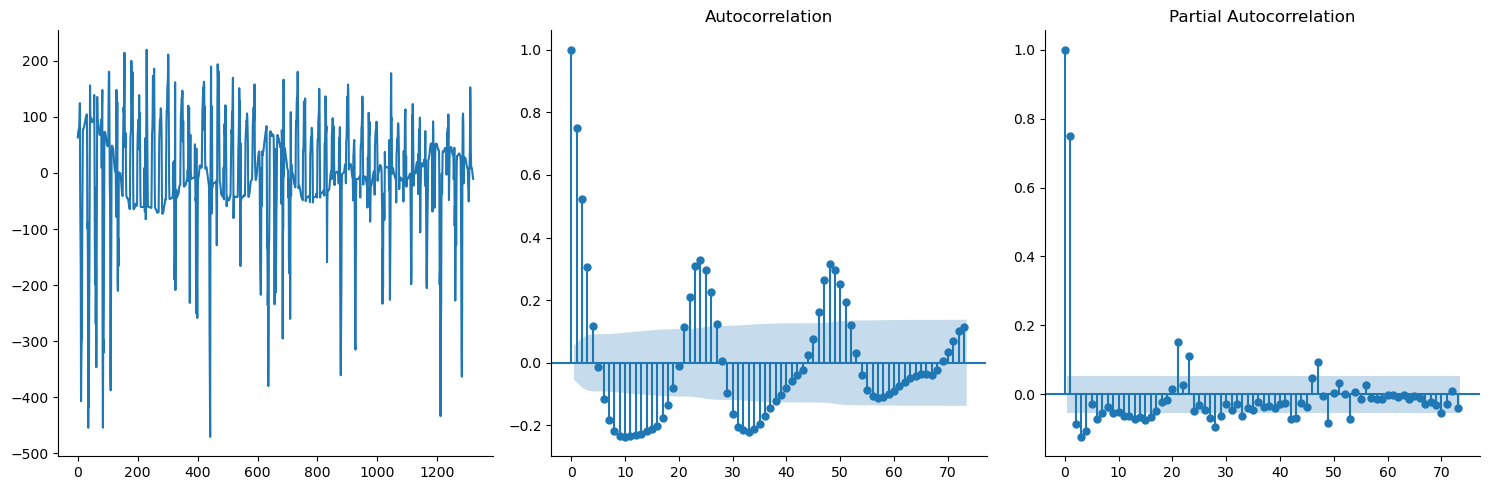

In [54]:
plots(additive_decomposed_radiation, lags=73)

From ACF plot we can find out that lag 1, lag 2, lag 3 are the most significant. From PACF plot just lag 1 is the most significant. However, to be more certain we tune ARIMA models on different orders.

############################################################ AR Model ############################################################ 




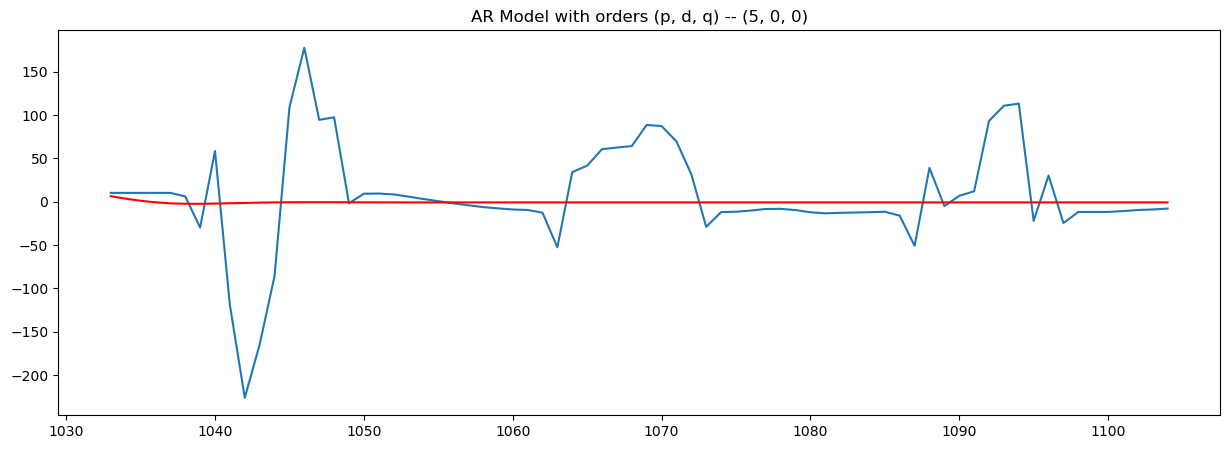



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (5, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 9.383593260545172,
 '2. Mean Percentage Error (MPE)': -9.255112012921103,
 '3. Root Mean Squared Error (RMSE)': 65.85319207708686,
 '4. Mean Error (ME)': -4.368461646200179,
 '5. Mean Absolute Error (MAE)': 45.52461493552394,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9761549128087973}


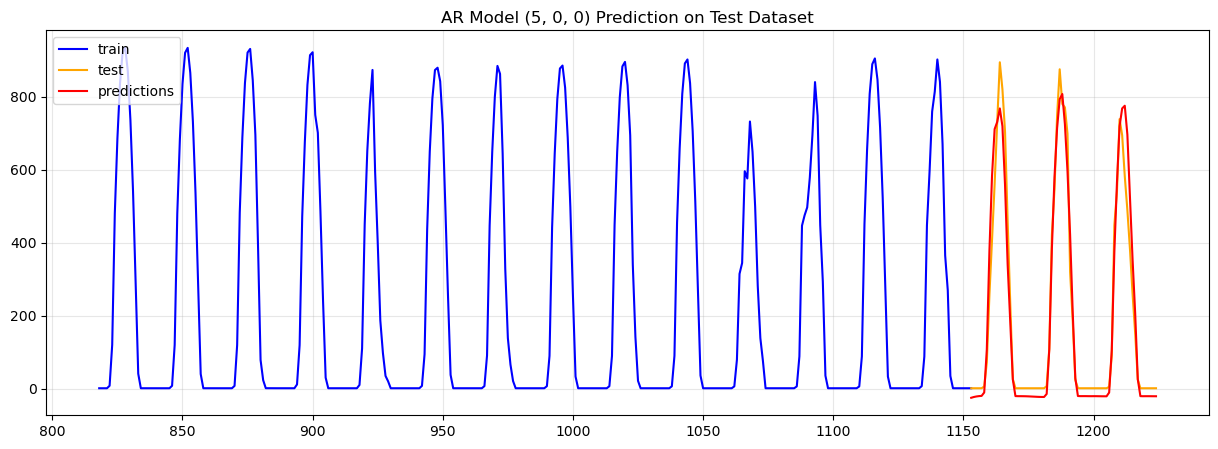










############################################################ MA Model ############################################################ 




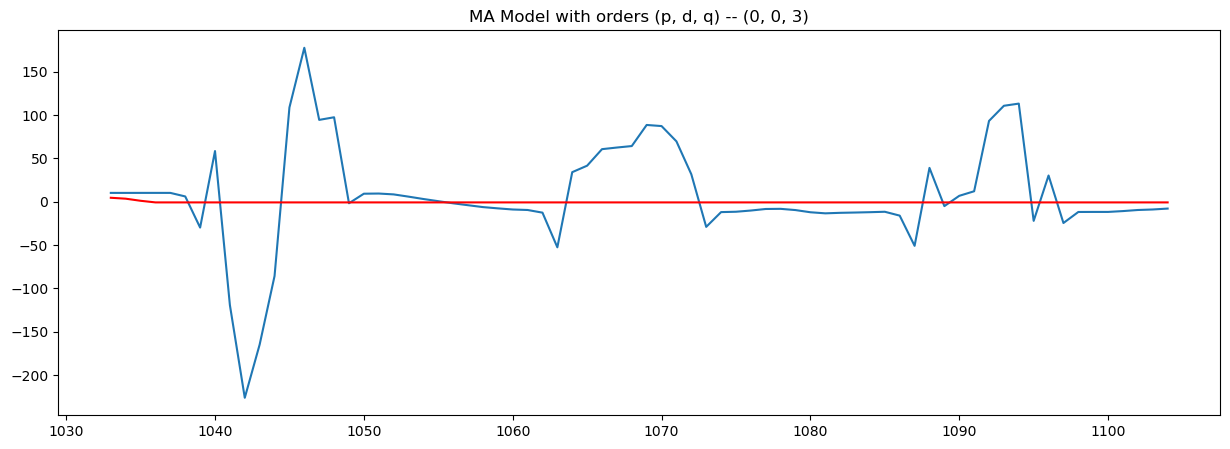



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 9.378753006353996,
 '2. Mean Percentage Error (MPE)': -9.250851184015492,
 '3. Root Mean Squared Error (RMSE)': 65.77791521180018,
 '4. Mean Error (ME)': -4.405957224950313,
 '5. Mean Absolute Error (MAE)': 45.4841678985236,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9762120280682889}


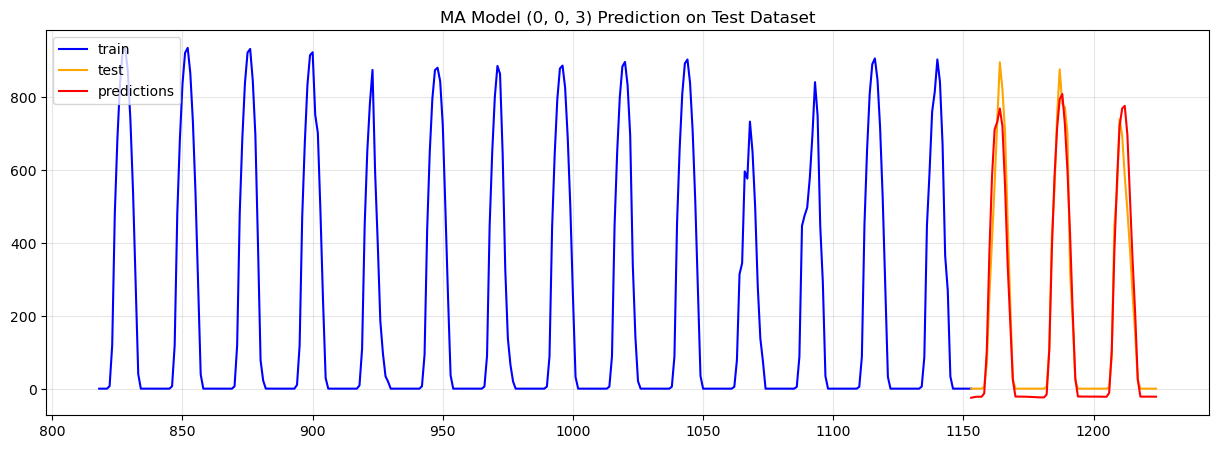










############################################################ ARMA Model ############################################################ 




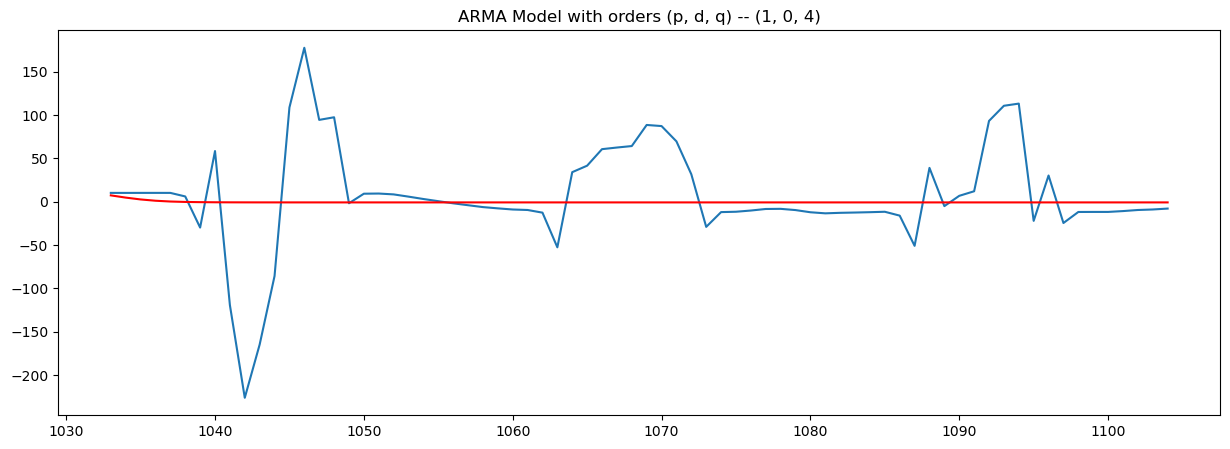



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 9.461310438725153,
 '2. Mean Percentage Error (MPE)': -9.333483934466123,
 '3. Root Mean Squared Error (RMSE)': 65.81005718944365,
 '4. Mean Error (ME)': -4.514435899060975,
 '5. Mean Absolute Error (MAE)': 45.5840440752043,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9762085112911211}


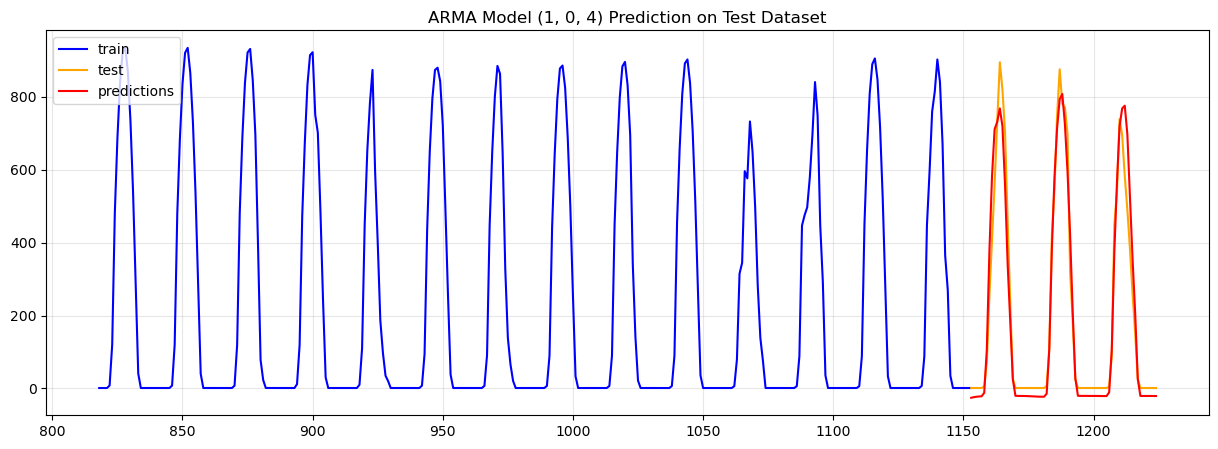










############################################################ ARIMA Model ############################################################ 




✅ [ERROR] - [2022-04-26 18:06:56] - (1422772745.py).optimize_ARIMA_models(22): Error during fit ARIMA model with the next parameters -- (3, 2, 4), 
context of the error -- LU decomposition error.


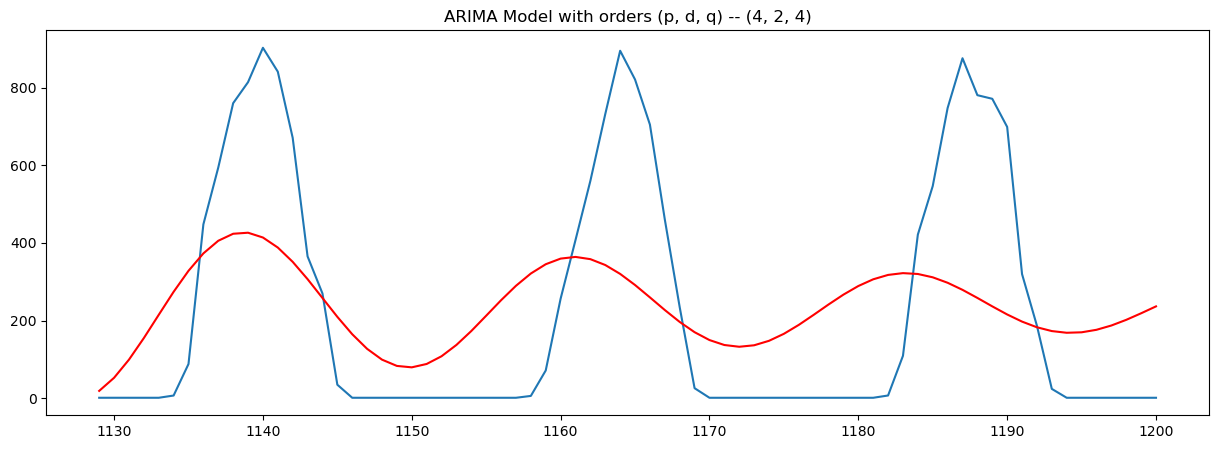



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (4, 2, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 110.09056831857431,
 '2. Mean Percentage Error (MPE)': -110.09056831857431,
 '3. Root Mean Squared Error (RMSE)': 483.17227523661717,
 '4. Mean Error (ME)': -428.15438518111495,
 '5. Mean Absolute Error (MAE)': 428.15438518111495,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.44623243534034823}


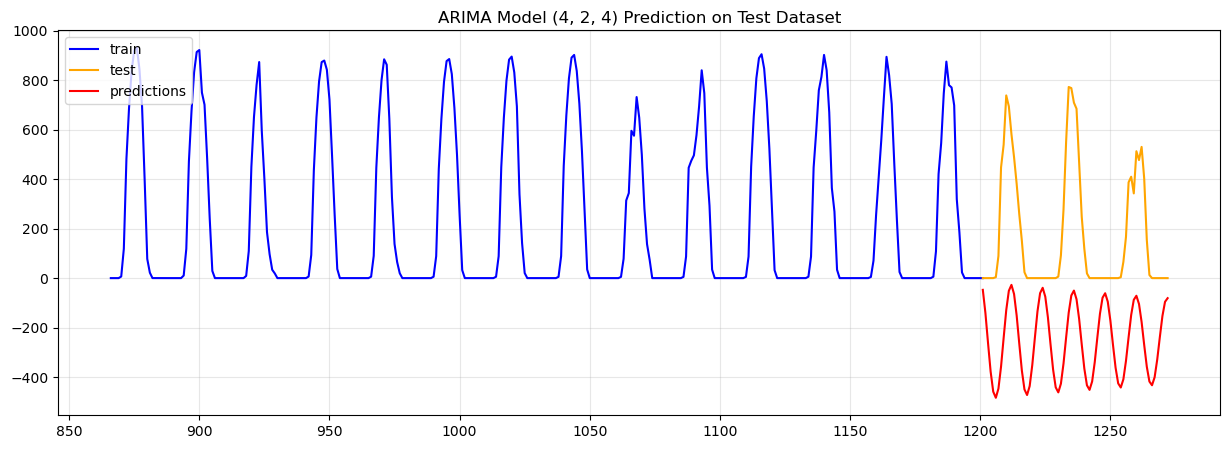

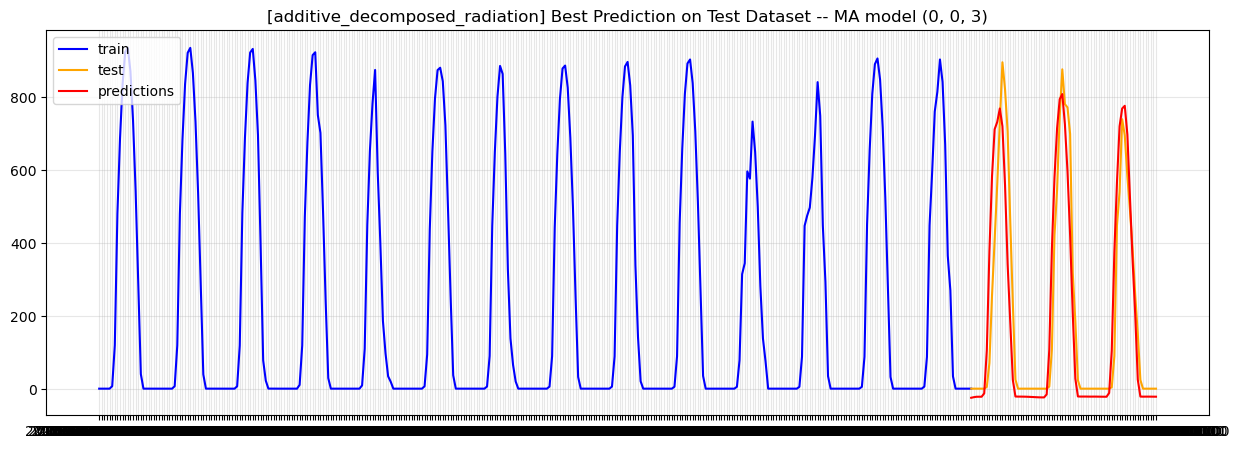

############################################################ AR Model ############################################################ 




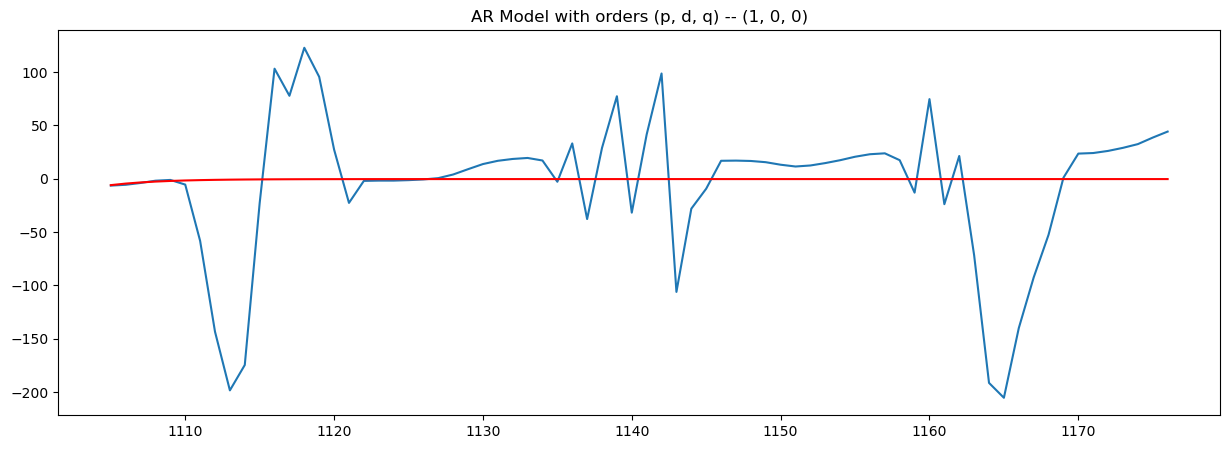



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 8.10028748908209,
 '2. Mean Percentage Error (MPE)': -7.508016570495578,
 '3. Root Mean Squared Error (RMSE)': 92.78353171612301,
 '4. Mean Error (ME)': 20.02550142327934,
 '5. Mean Absolute Error (MAE)': 51.08696215279003,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9557920436934978}


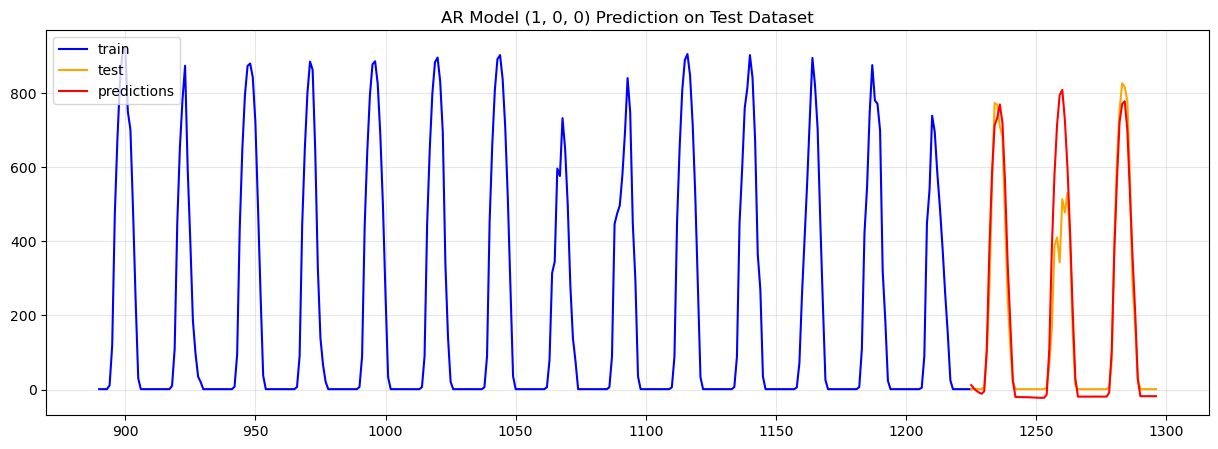










############################################################ MA Model ############################################################ 




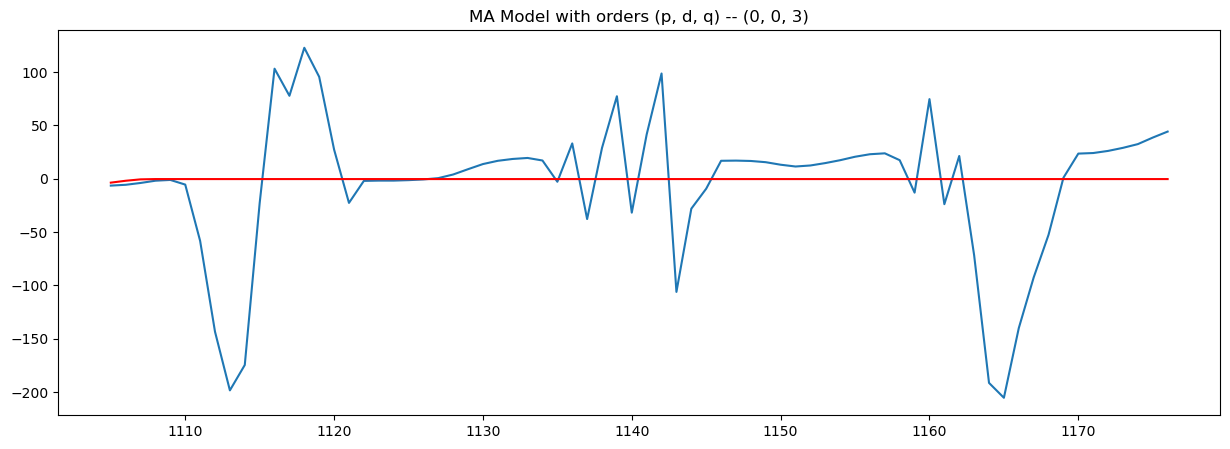



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 8.539472355520356,
 '2. Mean Percentage Error (MPE)': -8.13465504319834,
 '3. Root Mean Squared Error (RMSE)': 92.78441606549782,
 '4. Mean Error (ME)': 18.90254647558777,
 '5. Mean Absolute Error (MAE)': 51.5234087292738,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.955730024910584}


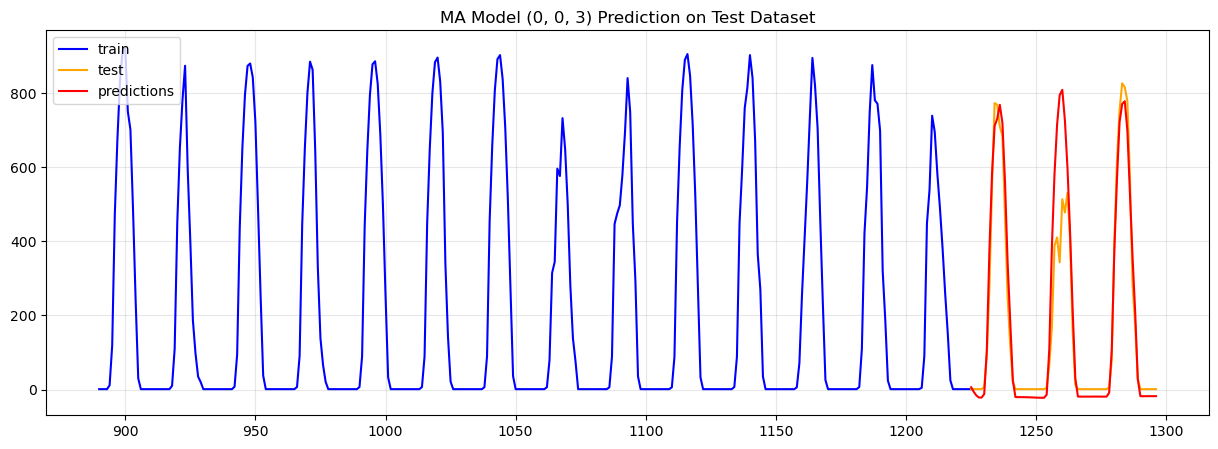










############################################################ ARMA Model ############################################################ 




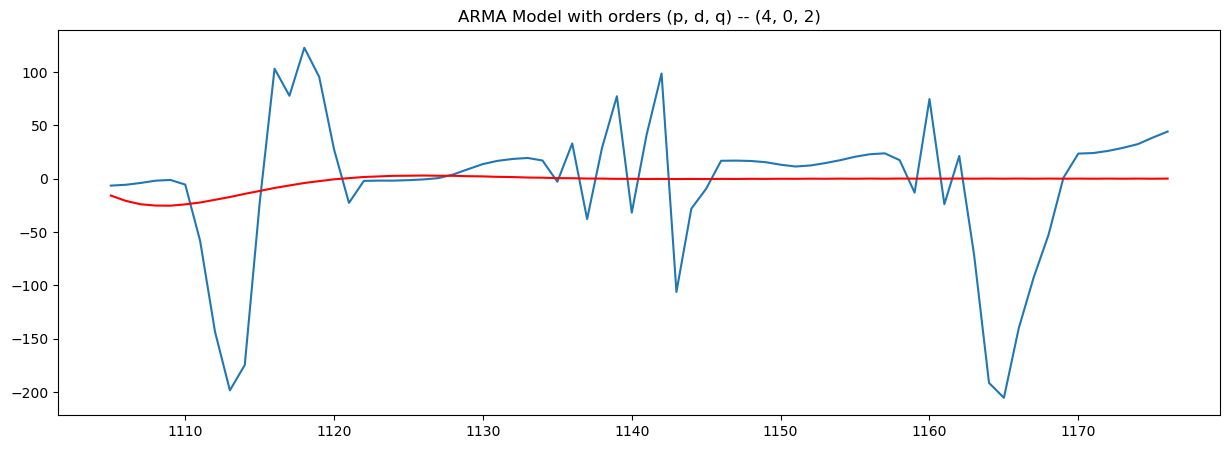



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (4, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 8.106043595679717,
 '2. Mean Percentage Error (MPE)': -6.9602106697115955,
 '3. Root Mean Squared Error (RMSE)': 92.91541766467395,
 '4. Mean Error (ME)': 20.583343513972174,
 '5. Mean Absolute Error (MAE)': 50.87895483945019,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9553823122336687}


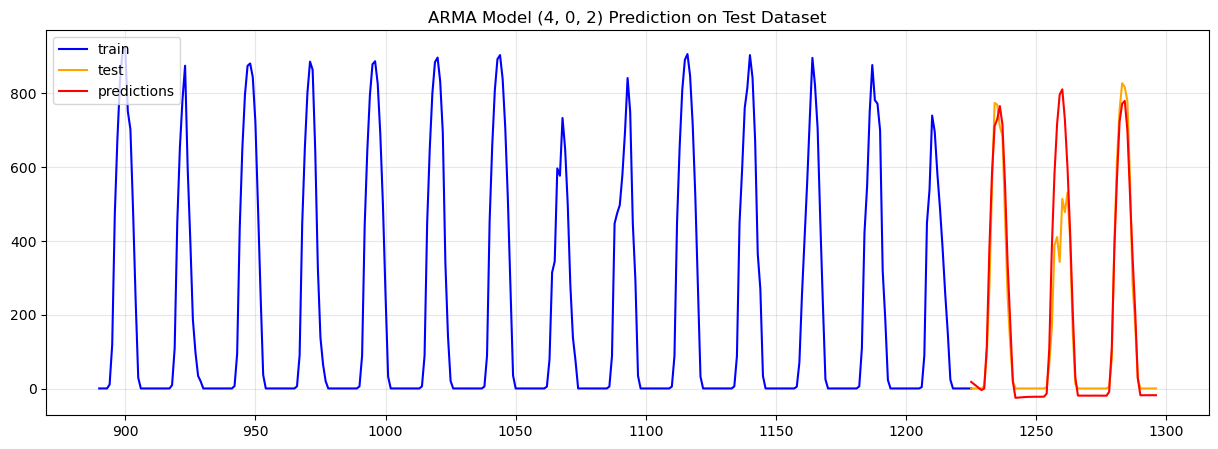










############################################################ ARIMA Model ############################################################ 




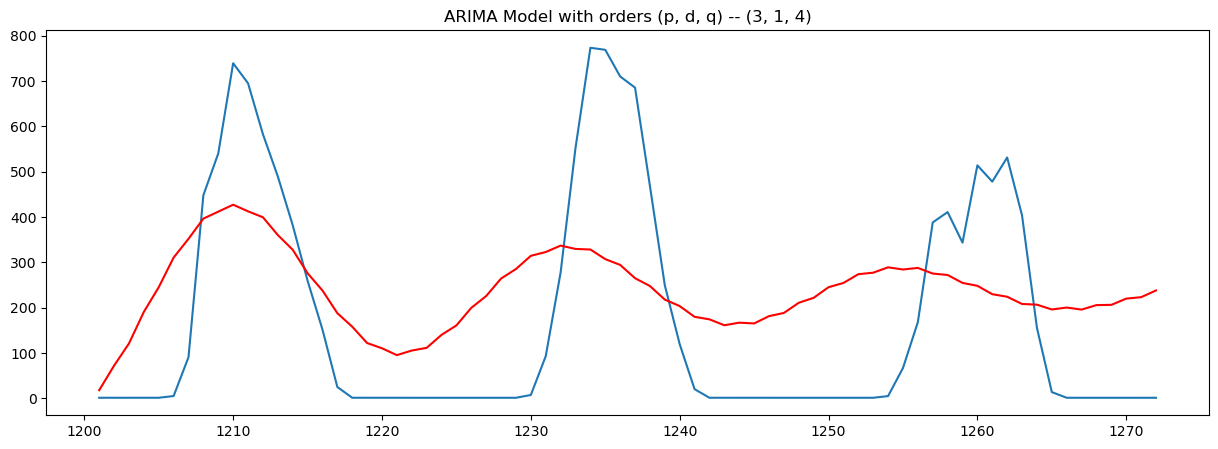



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (3, 1, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 55.89827347831969,
 '2. Mean Percentage Error (MPE)': 55.47888984033264,
 '3. Root Mean Squared Error (RMSE)': 261.22880419048676,
 '4. Mean Error (ME)': -37.82307197457209,
 '5. Mean Absolute Error (MAE)': 205.1404117096817,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.42484421841776454}


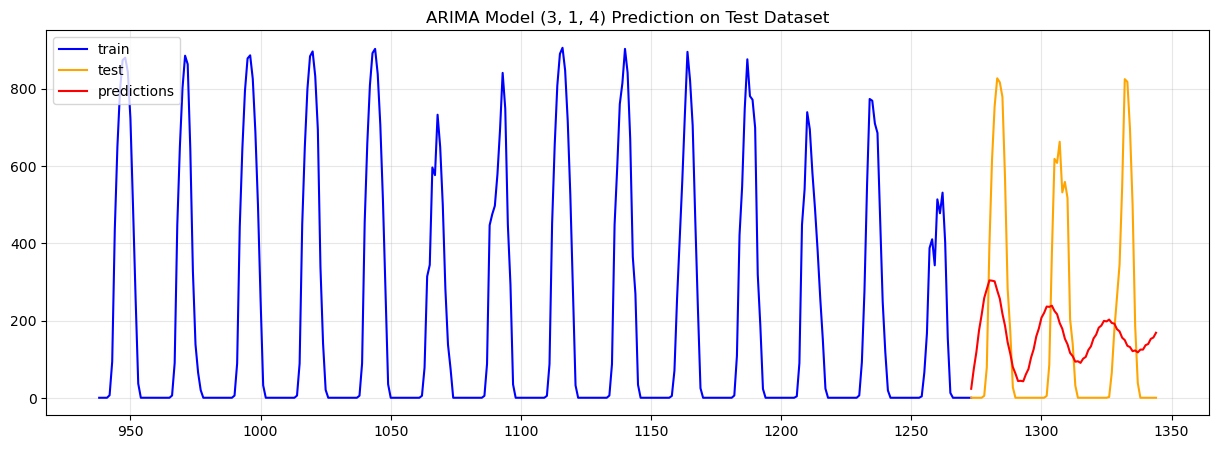

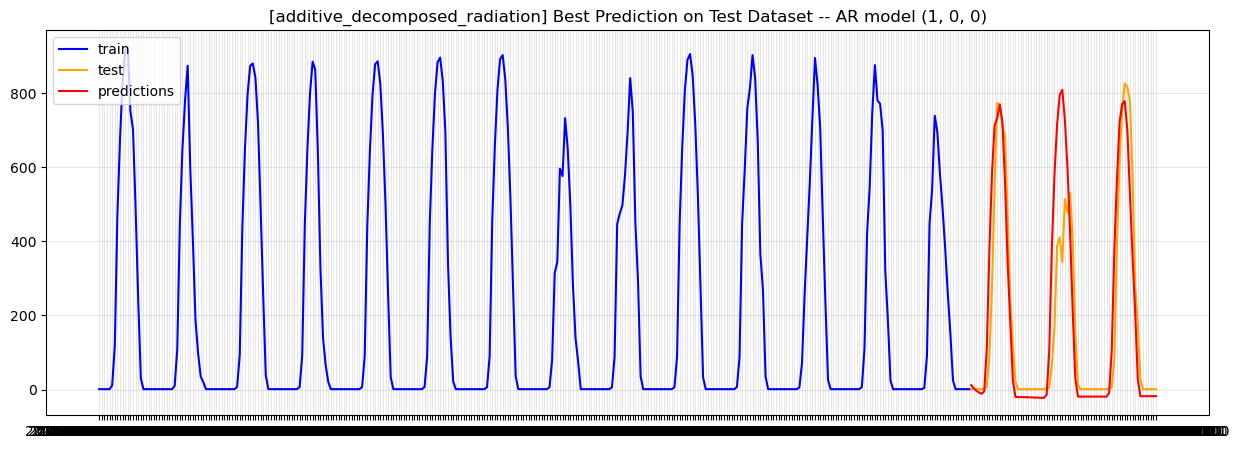

############################################################ AR Model ############################################################ 




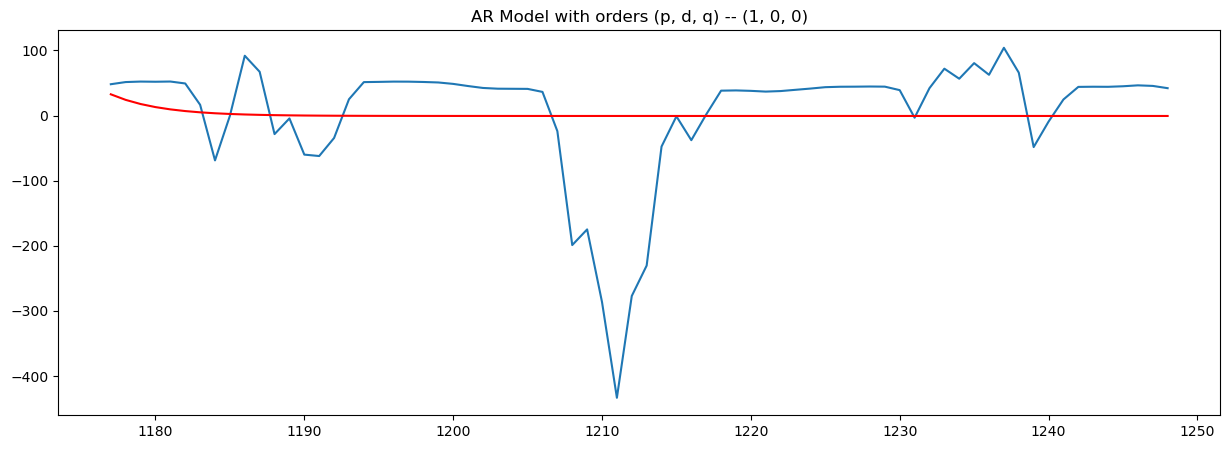



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 5.704235463114701,
 '2. Mean Percentage Error (MPE)': -5.068192787574156,
 '3. Root Mean Squared Error (RMSE)': 88.84322689963372,
 '4. Mean Error (ME)': 14.55773639062589,
 '5. Mean Absolute Error (MAE)': 47.86493711454622,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9573963278205813}


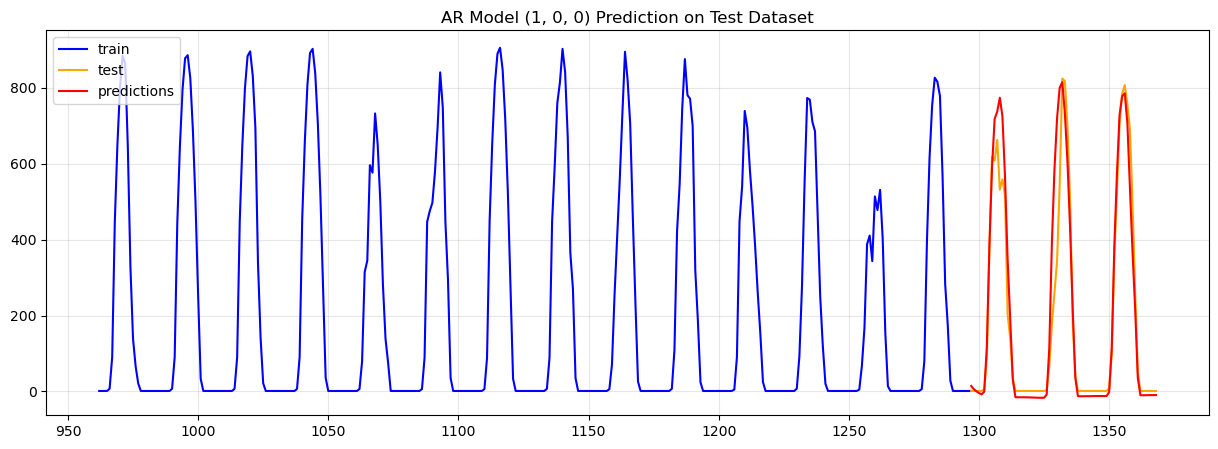










############################################################ MA Model ############################################################ 




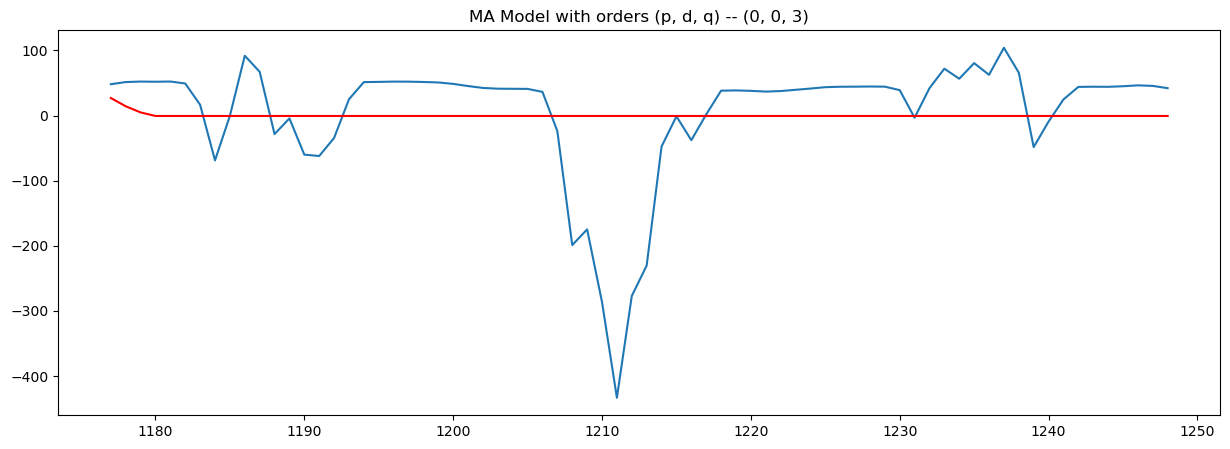



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 6.080551441940207,
 '2. Mean Percentage Error (MPE)': -5.724350976844658,
 '3. Root Mean Squared Error (RMSE)': 88.74118725178387,
 '4. Mean Error (ME)': 13.40081902894991,
 '5. Mean Absolute Error (MAE)': 48.19621543734056,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9574810584963815}


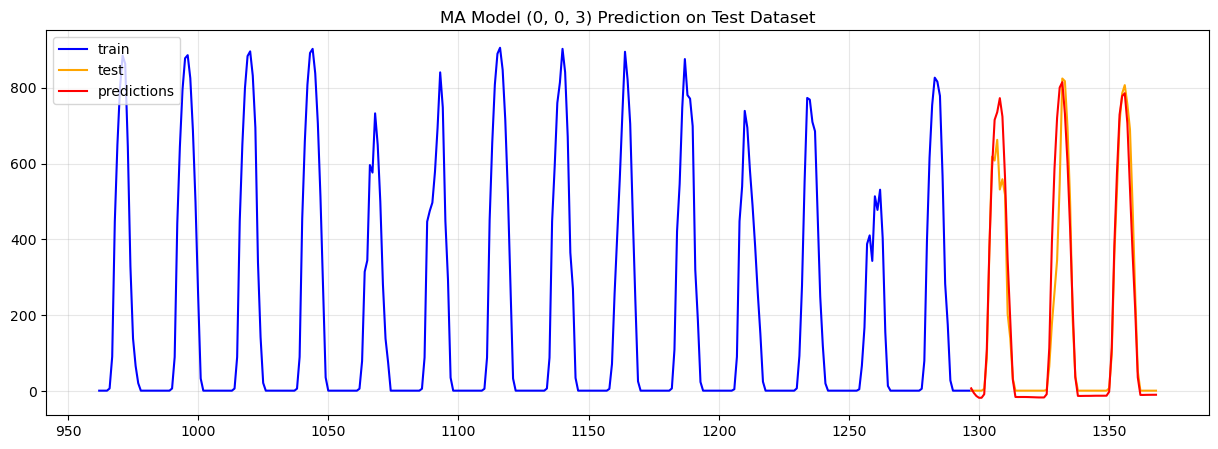










############################################################ ARMA Model ############################################################ 




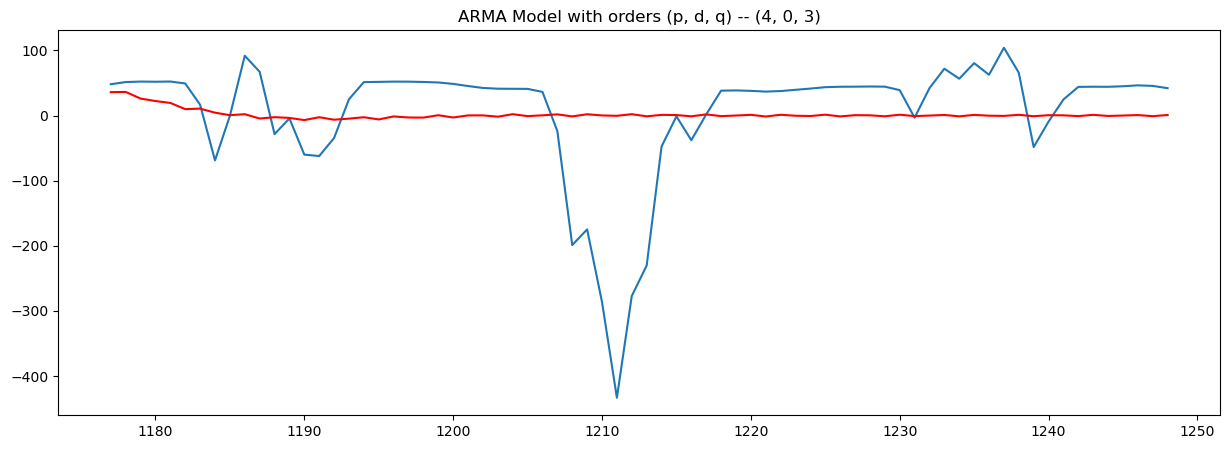



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 6.806836977626222,
 '2. Mean Percentage Error (MPE)': -6.605542010281841,
 '3. Root Mean Squared Error (RMSE)': 87.27630802898408,
 '4. Mean Error (ME)': 8.541456548045032,
 '5. Mean Absolute Error (MAE)': 48.52841210595247,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9575393469519797}


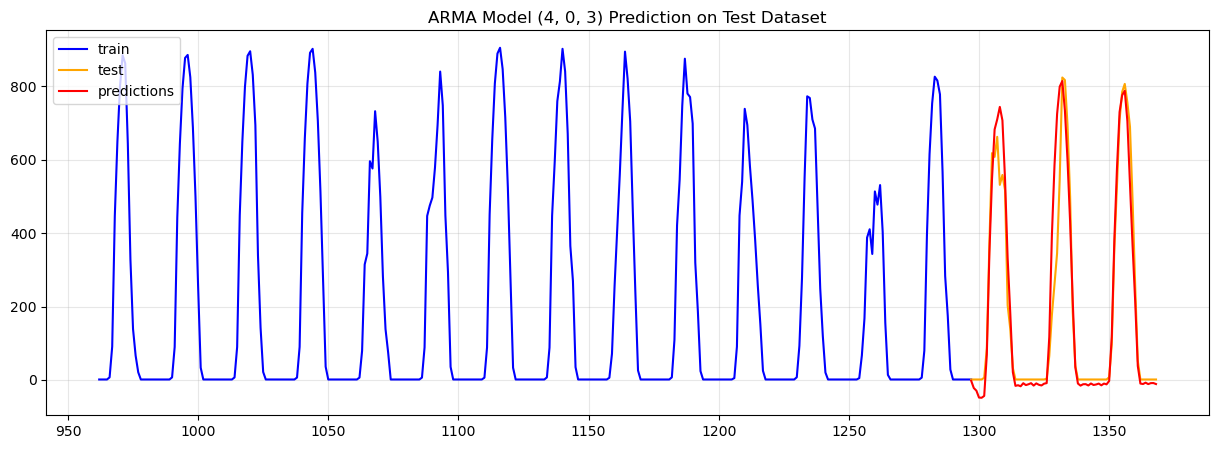










############################################################ ARIMA Model ############################################################ 




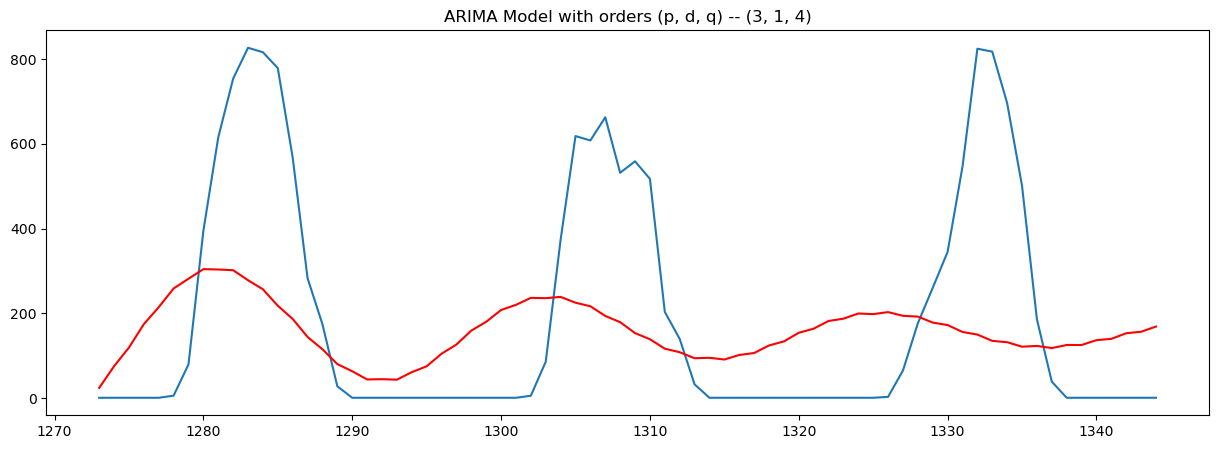



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (3, 1, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 60.150855761842,
 '2. Mean Percentage Error (MPE)': 59.71534185221169,
 '3. Root Mean Squared Error (RMSE)': 294.012181307868,
 '4. Mean Error (ME)': -55.98620931732995,
 '5. Mean Absolute Error (MAE)': 237.9297759999081,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.6010612876679187}


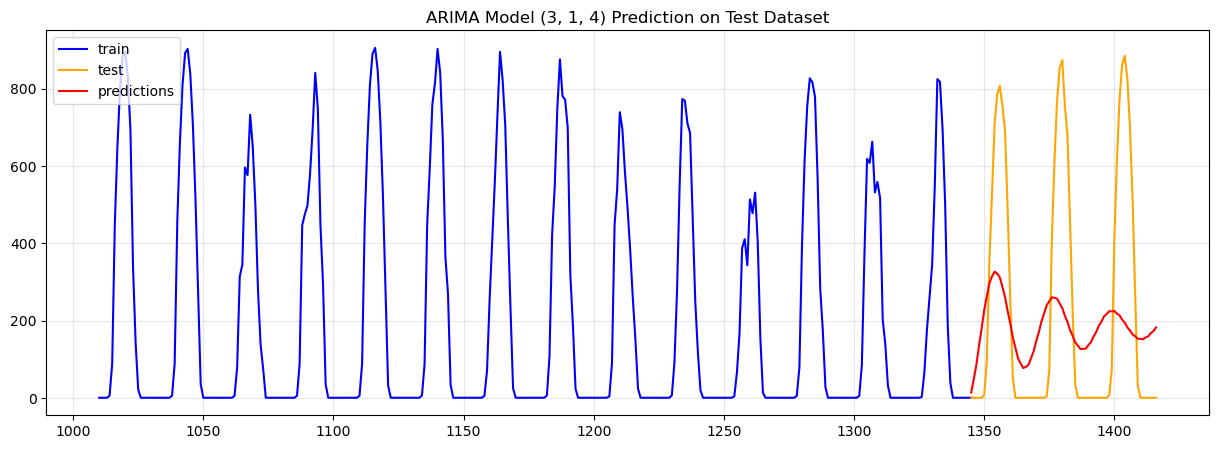

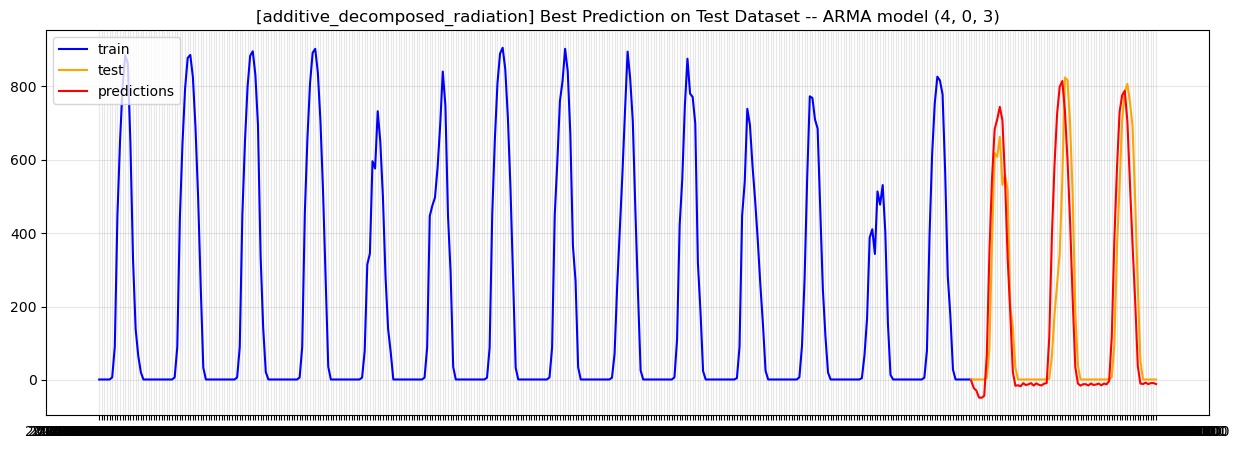

Iteration         Stationary_Series_Name  Model_Name Model_Orders  \
0         1  additive_decomposed_radiation    MA model    (0, 0, 3)   
1         2  additive_decomposed_radiation    AR model    (1, 0, 0)   
2         3  additive_decomposed_radiation  ARMA model    (4, 0, 3)   

   Mean Absolute Percentage Error (MAPE)  Mean Percentage Error (MPE)  \
0                               9.378753                    -9.250851   
1                               8.100287                    -7.508017   
2                               6.806837                    -6.605542   

   Root Mean Squared Error (RMSE)  
0                       65.777915  
1                       92.783532  
2                       87.276308

In [55]:
additive_decomposed_radiation_results_df = test_ARIMA_models(hourly_radiation_reset_df, additive_decomposed_radiation,
                                                             hourly_radiation_reset_df.Radiation,
                                                             stationary_series_name='additive_decomposed_radiation',
                                                             show_plots=False, debug_mode=False)
additive_decomposed_radiation_results_df

### Test multiplicative_decomposed_radiation stationary series

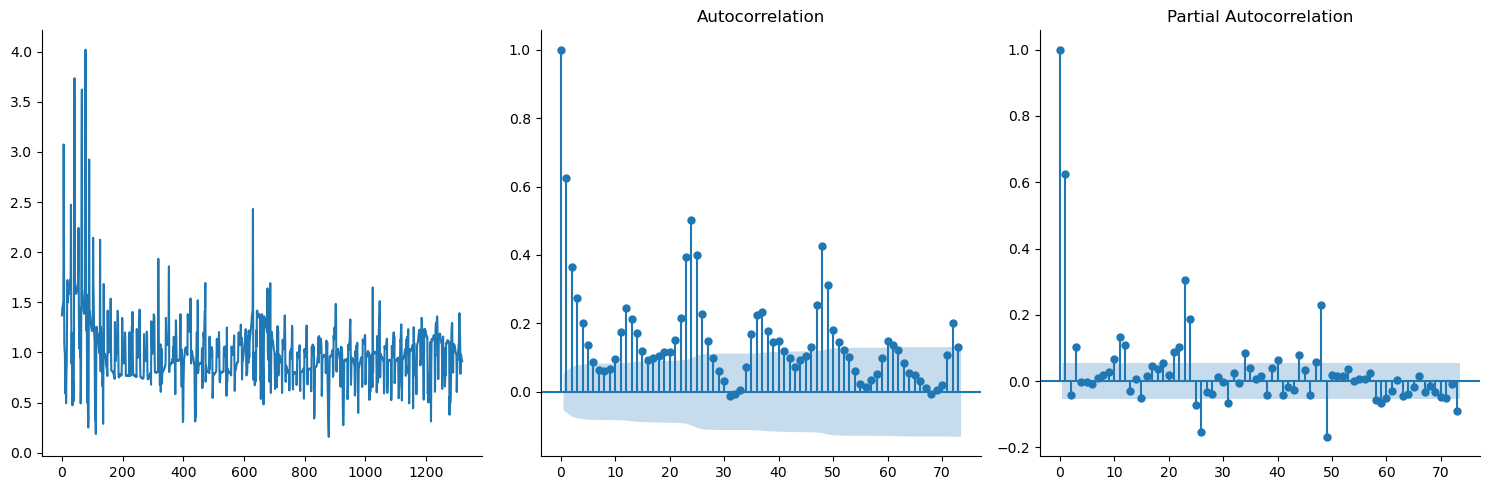

In [56]:
plots(multiplicative_decomposed_radiation, lags=73)

From ACF and PACF plots we can find out that lag 1, lag 24 and lag 48 are the most significant. This is good observation, which can be used for creation feature dataframe for ML and DL models. However, to be more certain we tune ARIMA models on different orders.

############################################################ AR Model ############################################################ 




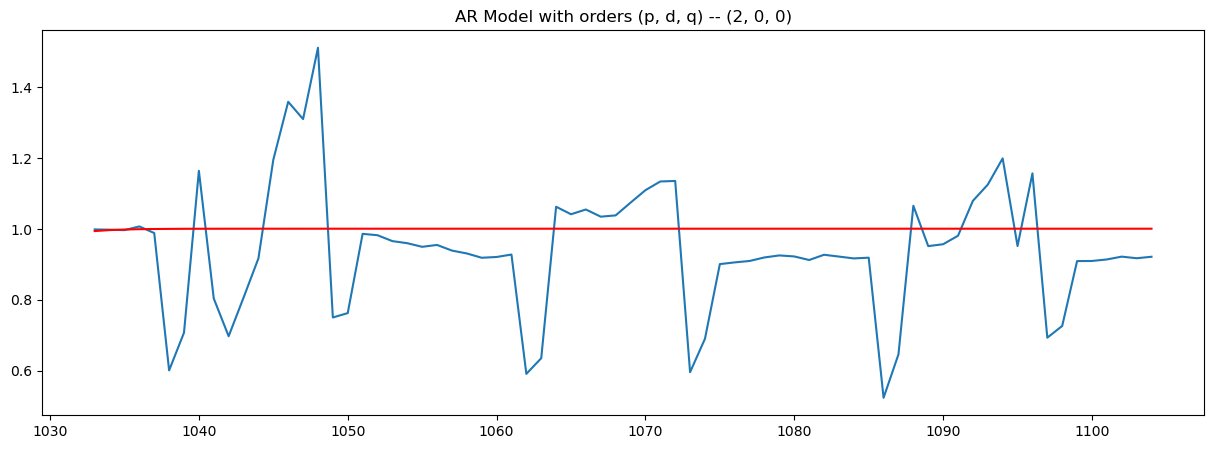



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.18518999055052954,
 '2. Mean Percentage Error (MPE)': 0.0683378120885561,
 '3. Root Mean Squared Error (RMSE)': 64.95803529934912,
 '4. Mean Error (ME)': -4.655362468341971,
 '5. Mean Absolute Error (MAE)': 36.44336813312,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9760237957946071}


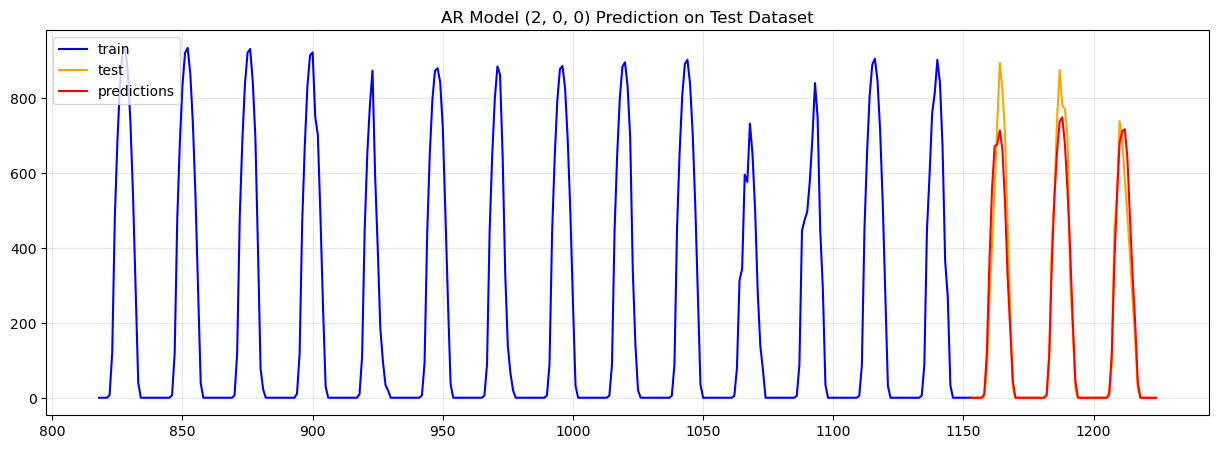










############################################################ MA Model ############################################################ 




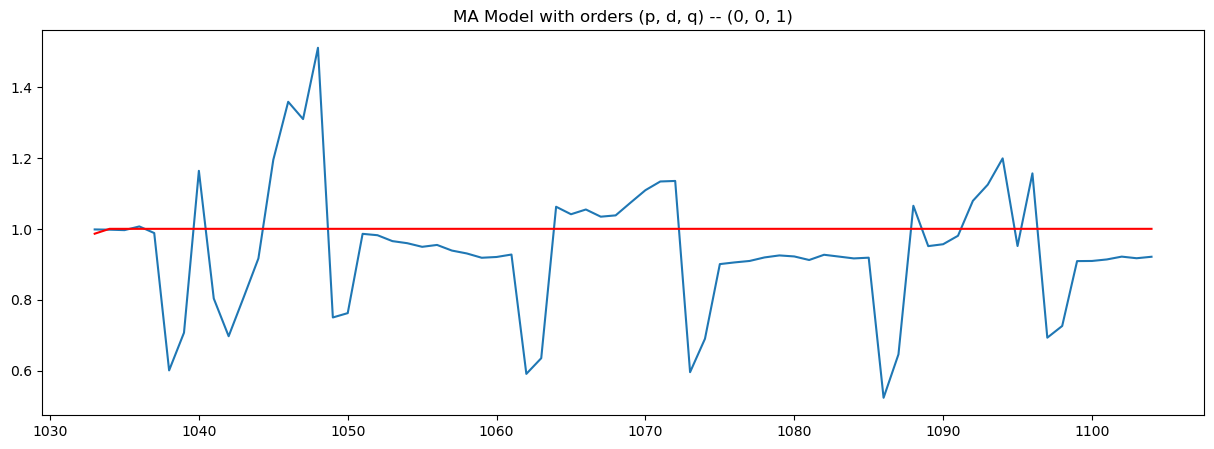



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.18435322524696737,
 '2. Mean Percentage Error (MPE)': 0.06924517865150312,
 '3. Root Mean Squared Error (RMSE)': 64.99844915980104,
 '4. Mean Error (ME)': -4.689277183117598,
 '5. Mean Absolute Error (MAE)': 36.46808485484935,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9760014937379046}


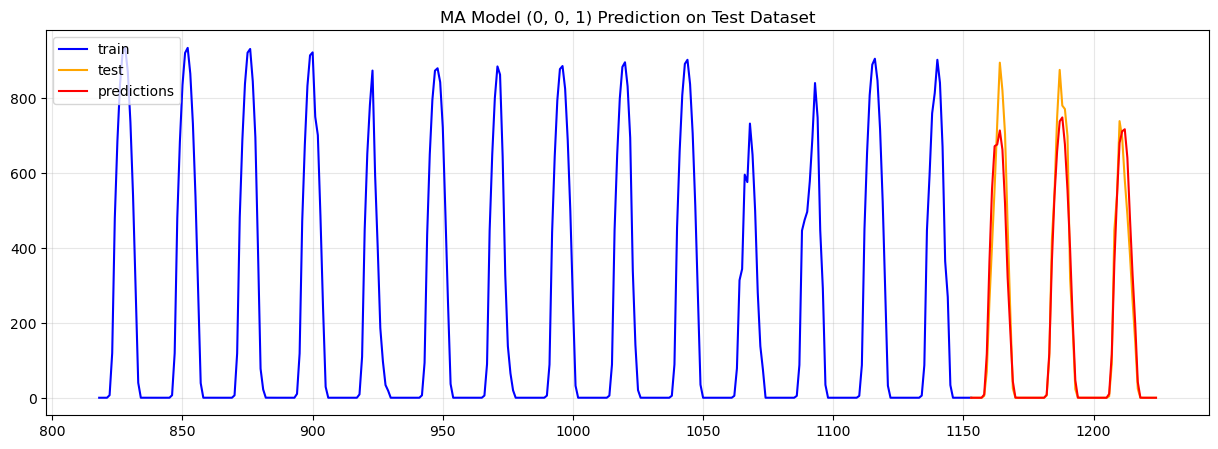










############################################################ ARMA Model ############################################################ 




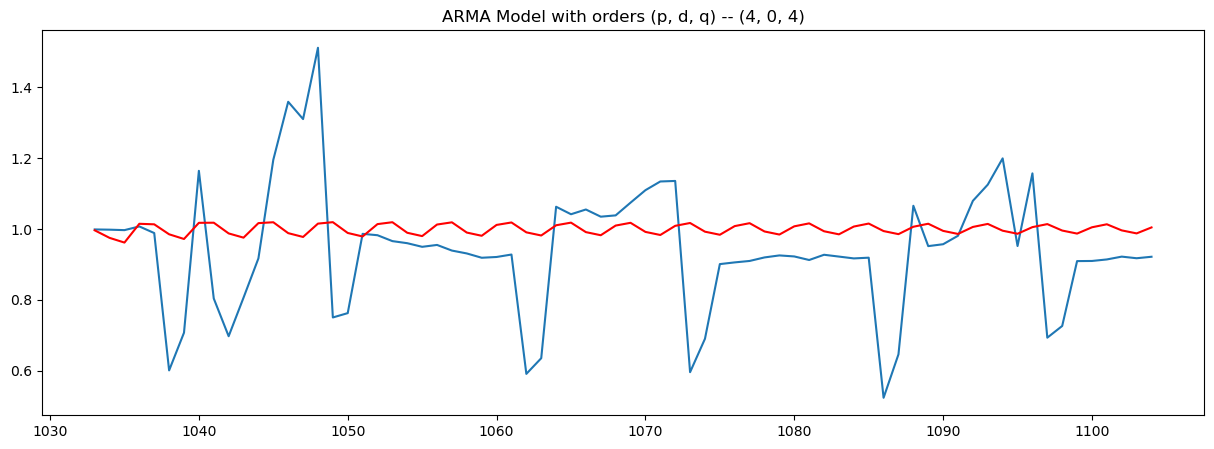



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (4, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 0.18370875087490557,
 '2. Mean Percentage Error (MPE)': 0.0668756830186354,
 '3. Root Mean Squared Error (RMSE)': 64.94843620252111,
 '4. Mean Error (ME)': -4.562178449424928,
 '5. Mean Absolute Error (MAE)': 36.24412401550987,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9760249632252541}


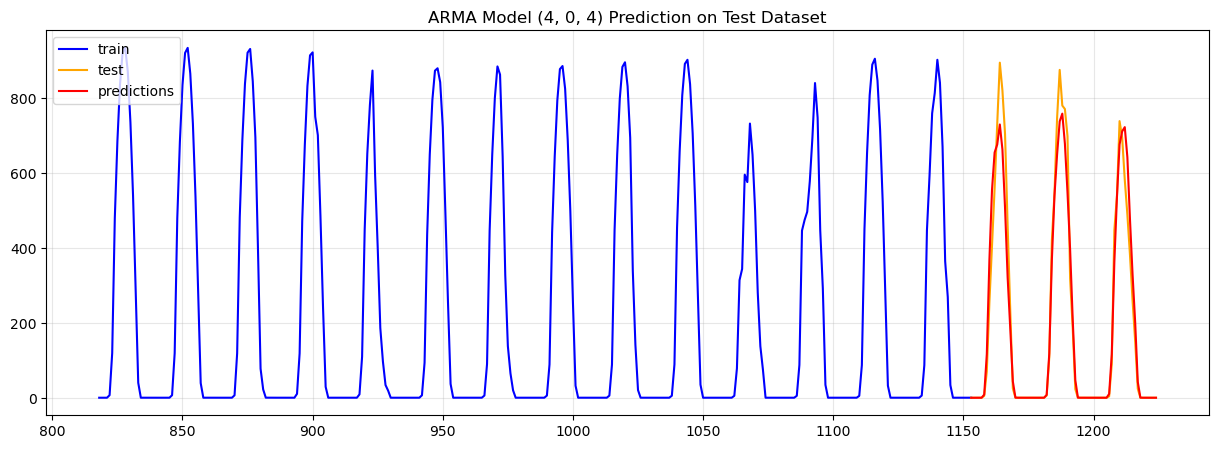










############################################################ ARIMA Model ############################################################ 




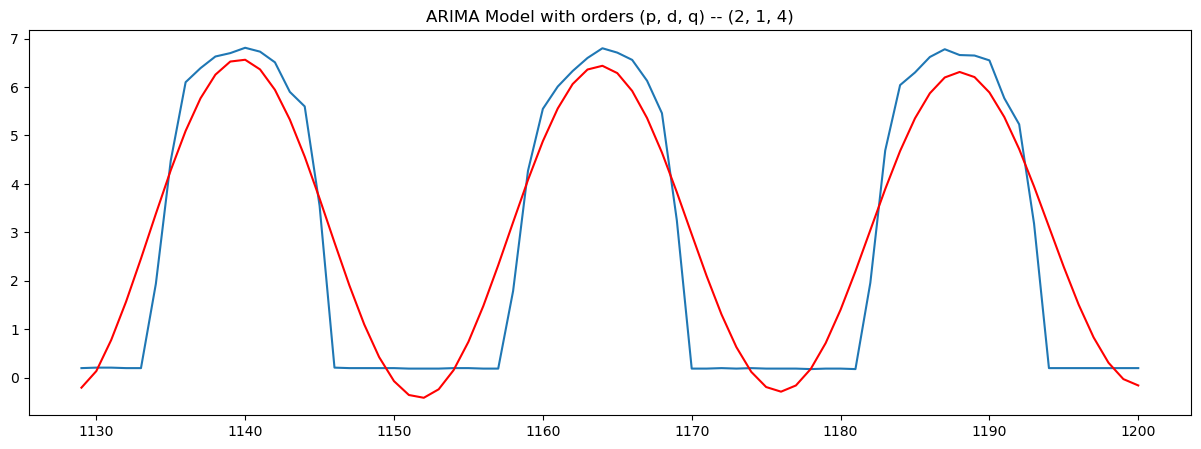



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 1, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 2.1101337367318296,
 '2. Mean Percentage Error (MPE)': 1.6307845680785638,
 '3. Root Mean Squared Error (RMSE)': 192.15157593848696,
 '4. Mean Error (ME)': -103.43911186968813,
 '5. Mean Absolute Error (MAE)': 109.99859484489367,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9353509391683114}


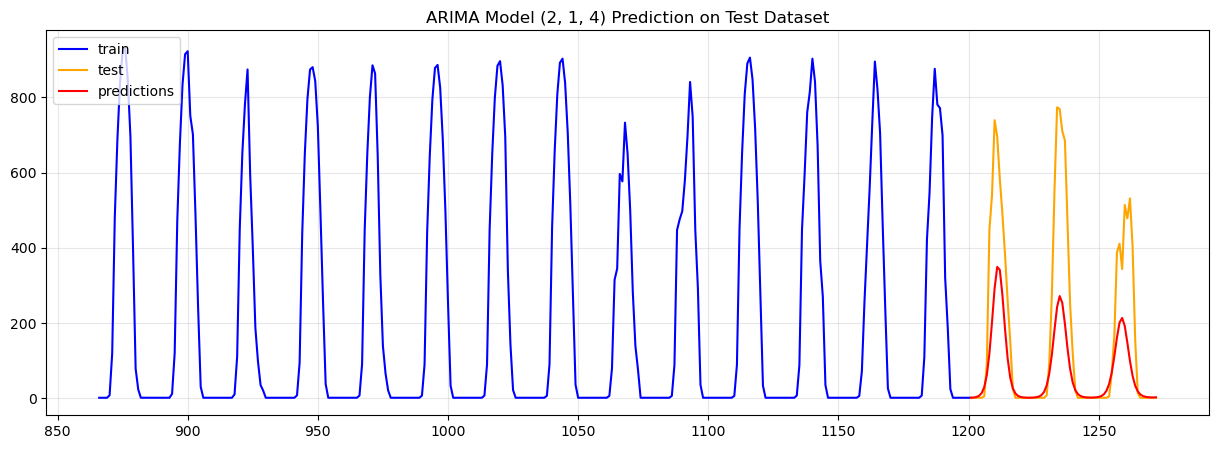

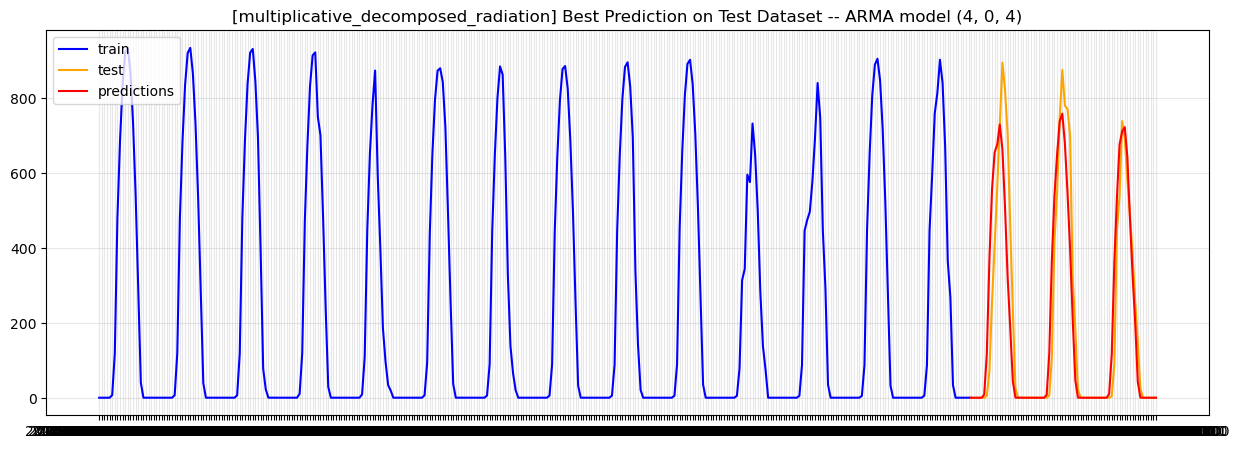

############################################################ AR Model ############################################################ 




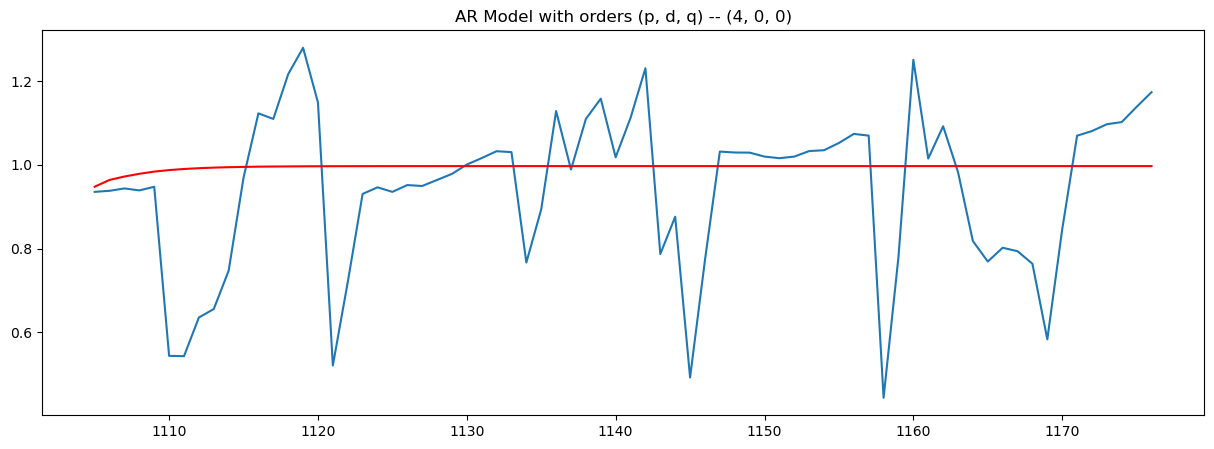



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (4, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.23878834073894323,
 '2. Mean Percentage Error (MPE)': 0.17595772289609252,
 '3. Root Mean Squared Error (RMSE)': 82.29700306971823,
 '4. Mean Error (ME)': 17.89536459382525,
 '5. Mean Absolute Error (MAE)': 40.14607078601,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9564135005836532}


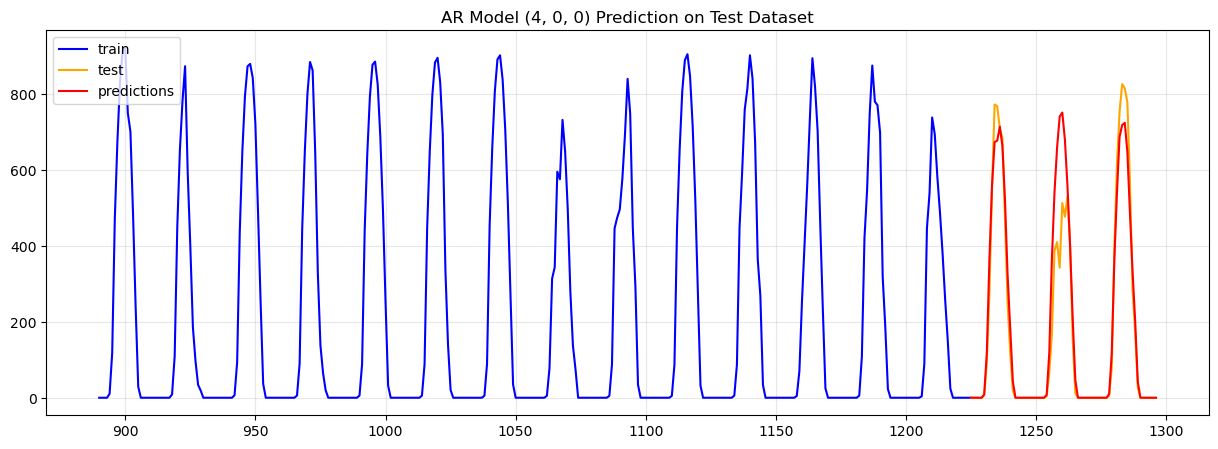










############################################################ MA Model ############################################################ 




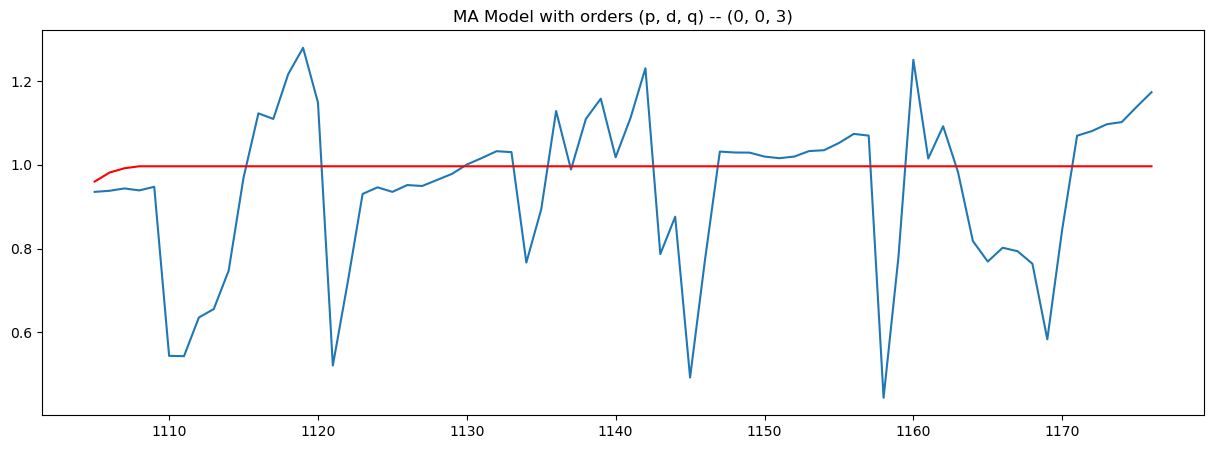



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 0.238923966927066,
 '2. Mean Percentage Error (MPE)': 0.17197424833933436,
 '3. Root Mean Squared Error (RMSE)': 82.25851924269541,
 '4. Mean Error (ME)': 17.47155071080386,
 '5. Mean Absolute Error (MAE)': 40.055934755247044,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9562419024362528}


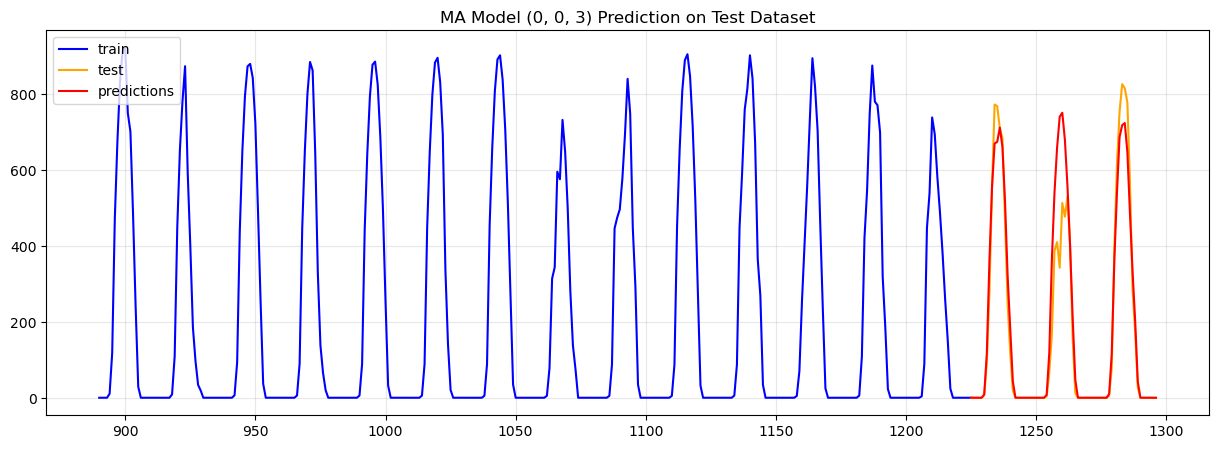










############################################################ ARMA Model ############################################################ 




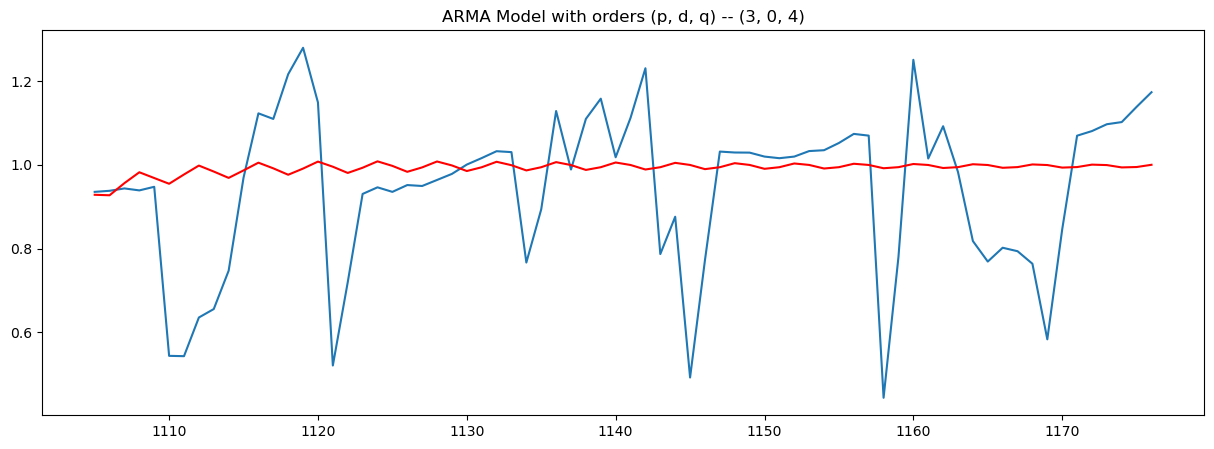



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (3, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 0.23965488077809324,
 '2. Mean Percentage Error (MPE)': 0.177908284536196,
 '3. Root Mean Squared Error (RMSE)': 82.5383818835967,
 '4. Mean Error (ME)': 18.472684879585824,
 '5. Mean Absolute Error (MAE)': 40.45240071416421,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9564258169398258}


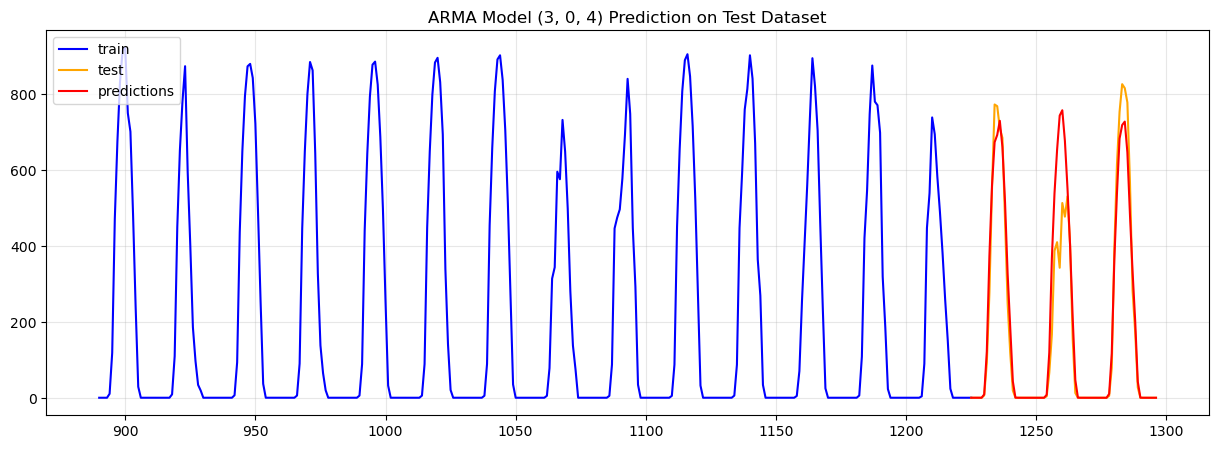










############################################################ ARIMA Model ############################################################ 




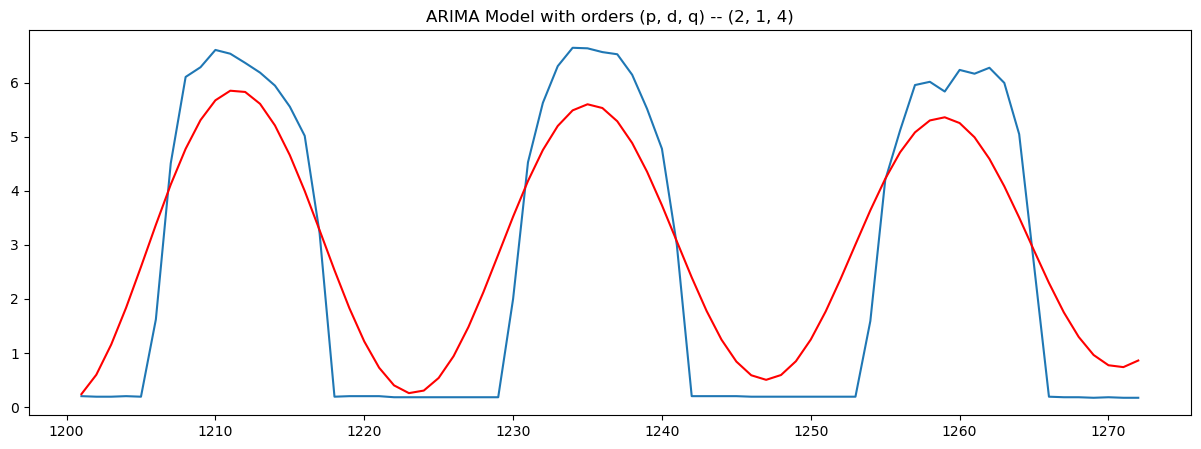



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 1, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 1.5004100010268393,
 '2. Mean Percentage Error (MPE)': 0.8592338805755497,
 '3. Root Mean Squared Error (RMSE)': 246.71543828897327,
 '4. Mean Error (ME)': -135.41825825415444,
 '5. Mean Absolute Error (MAE)': 139.44967889082204,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9315694253009851}


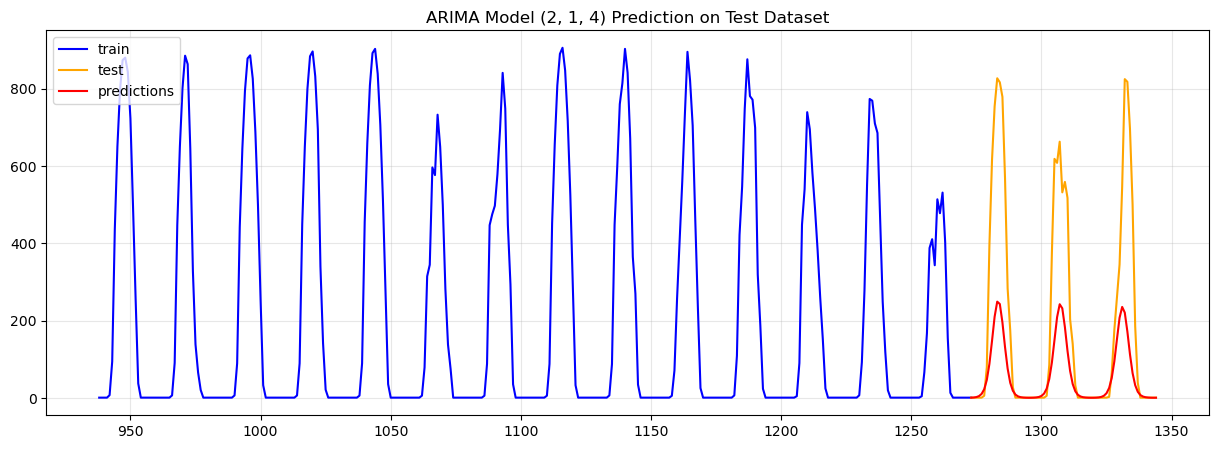

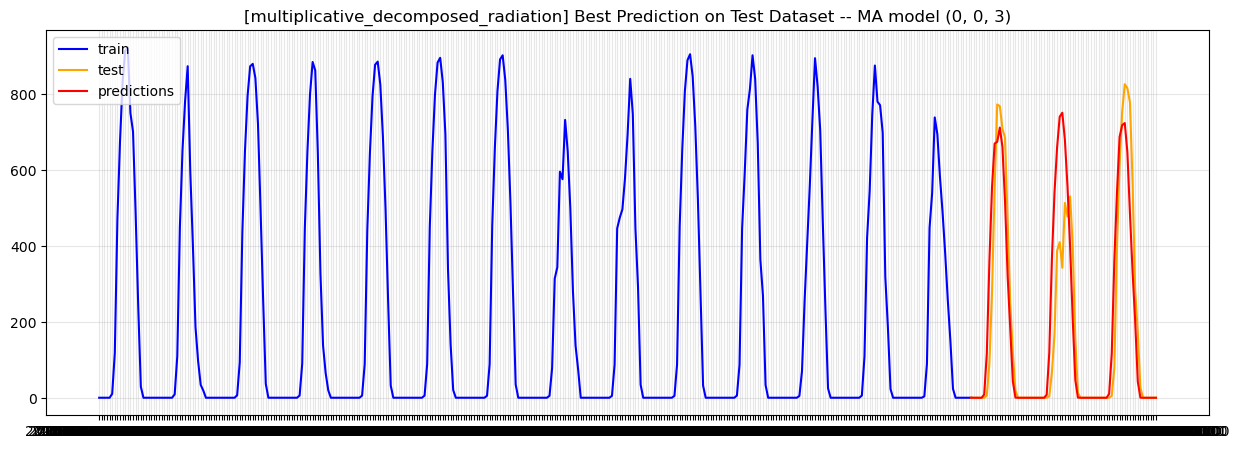

############################################################ AR Model ############################################################ 




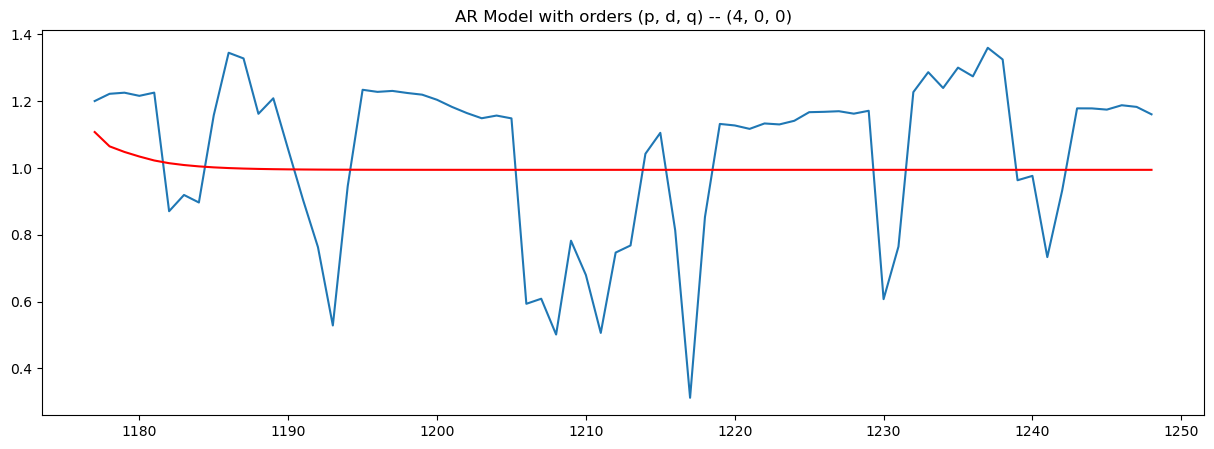



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (4, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.1974175891638704,
 '2. Mean Percentage Error (MPE)': 0.13619394934122944,
 '3. Root Mean Squared Error (RMSE)': 82.02878288510077,
 '4. Mean Error (ME)': 12.615938243824859,
 '5. Mean Absolute Error (MAE)': 40.21000193964577,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9582227797257312}


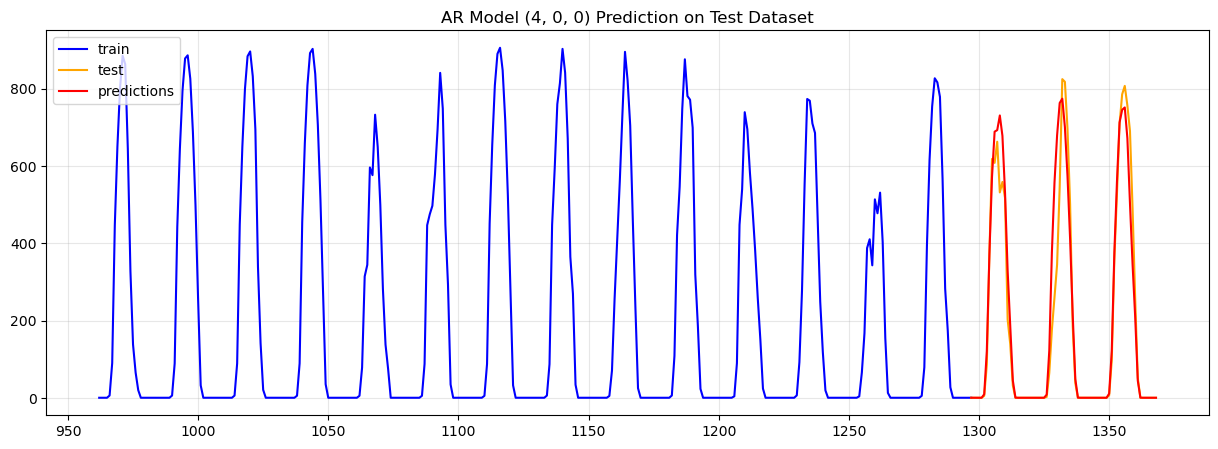










############################################################ MA Model ############################################################ 




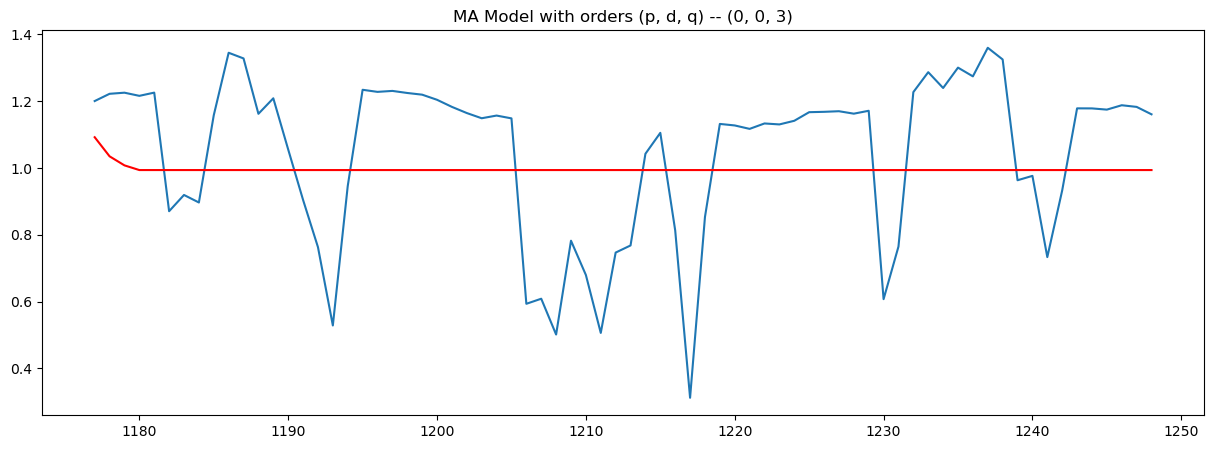



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 0.19592103126023974,
 '2. Mean Percentage Error (MPE)': 0.13191137615656914,
 '3. Root Mean Squared Error (RMSE)': 81.8468610976611,
 '4. Mean Error (ME)': 12.206638244158368,
 '5. Mean Absolute Error (MAE)': 40.13220431485032,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9582537820446244}


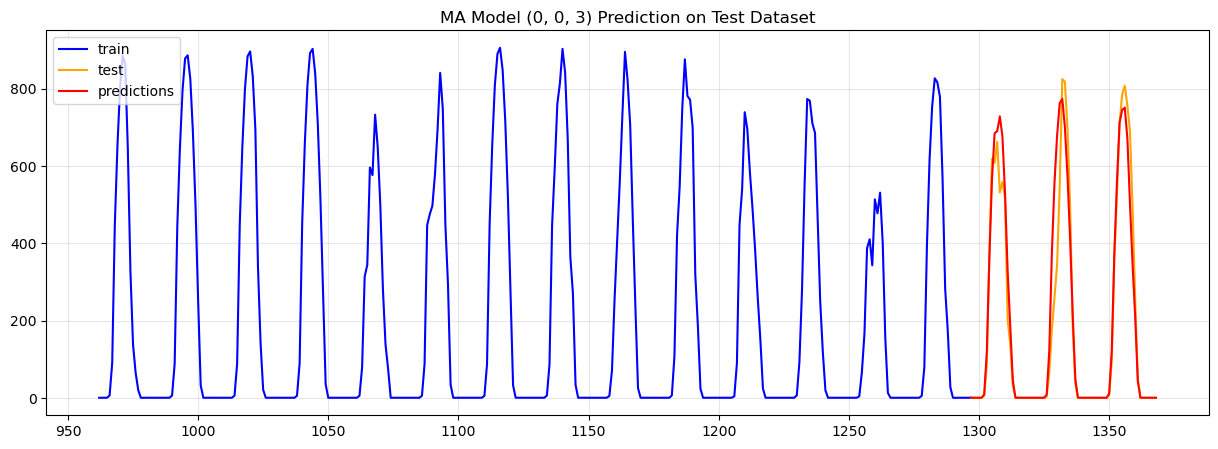










############################################################ ARMA Model ############################################################ 




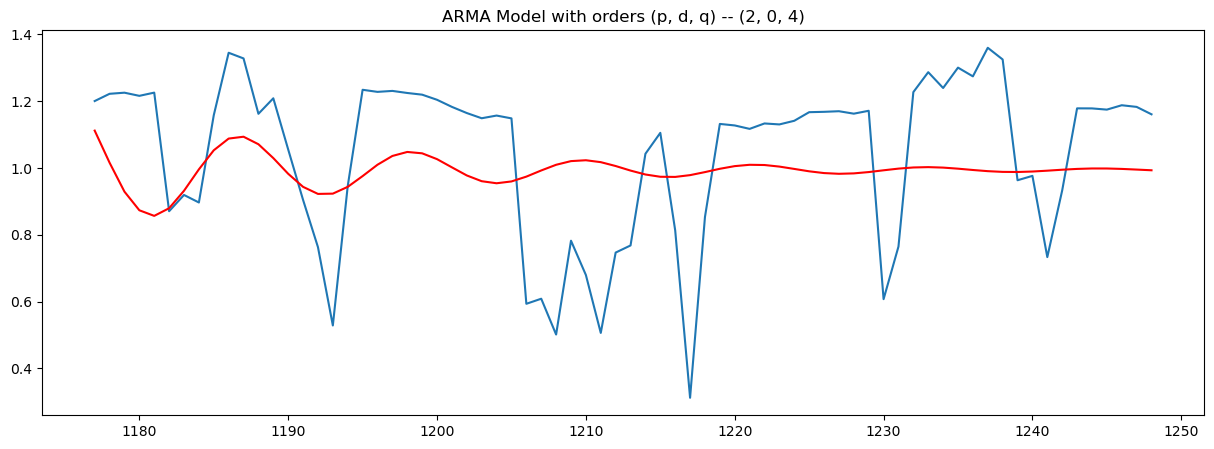



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (2, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 0.24132962158718593,
 '2. Mean Percentage Error (MPE)': 0.2119510222262914,
 '3. Root Mean Squared Error (RMSE)': 91.21242541397241,
 '4. Mean Error (ME)': 27.370103752092124,
 '5. Mean Absolute Error (MAE)': 43.158530257988645,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9581361464010552}


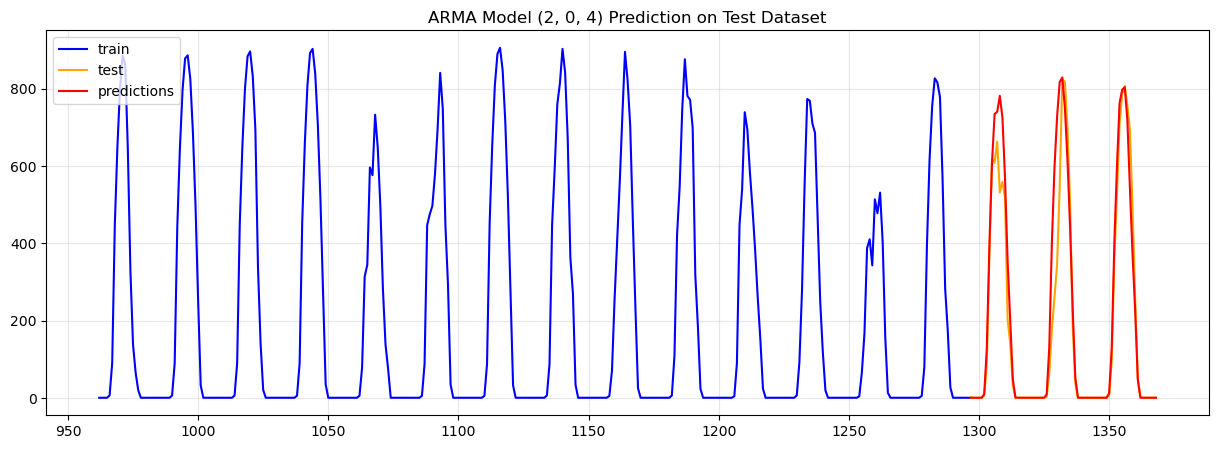










############################################################ ARIMA Model ############################################################ 




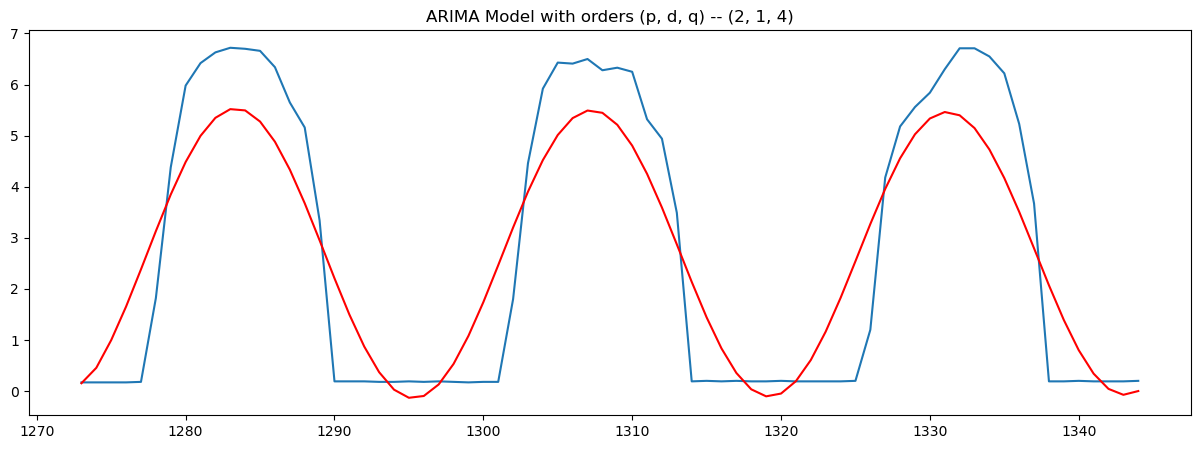



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 1, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 1.67540208843125,
 '2. Mean Percentage Error (MPE)': 1.0088329031784165,
 '3. Root Mean Squared Error (RMSE)': 278.6920936491317,
 '4. Mean Error (ME)': -163.6445472013163,
 '5. Mean Absolute Error (MAE)': 167.91185673517126,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9641834571891639}


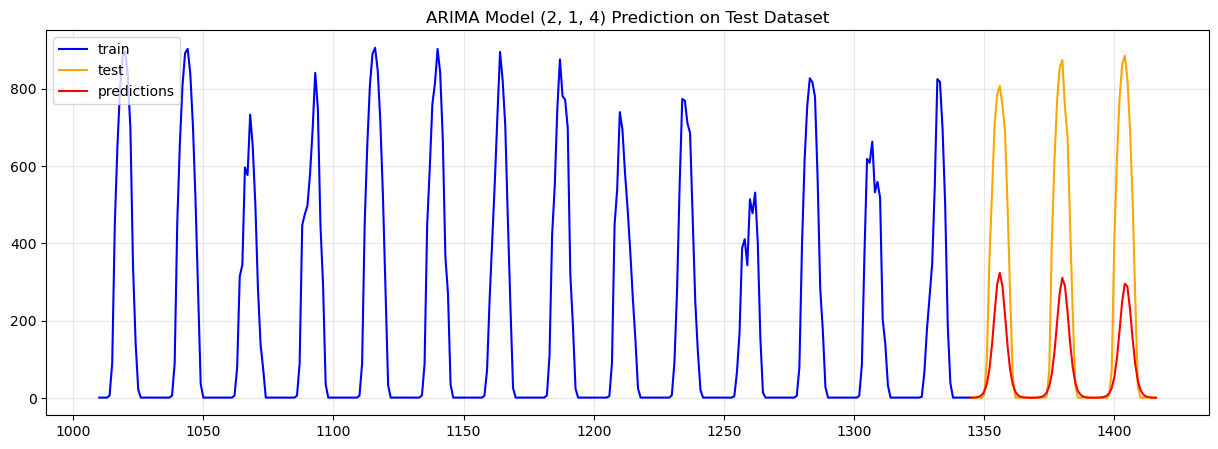

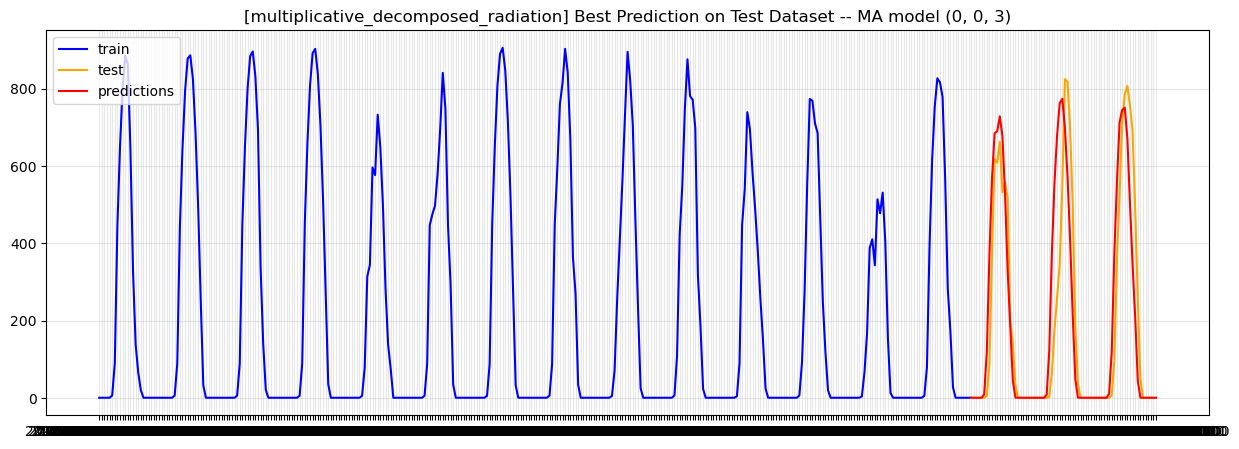

In [57]:
multiplicative_decomposed_radiation_results_df = test_ARIMA_models(hourly_radiation_reset_df, multiplicative_decomposed_radiation,
                                                                   hourly_radiation_reset_df.Log_Radiation, 'multiplicative_decomposed_radiation',
                                                                   show_plots=False, debug_mode=False)
multiplicative_decomposed_radiation_results_df

### Test additive_diff_production_1 stationary series

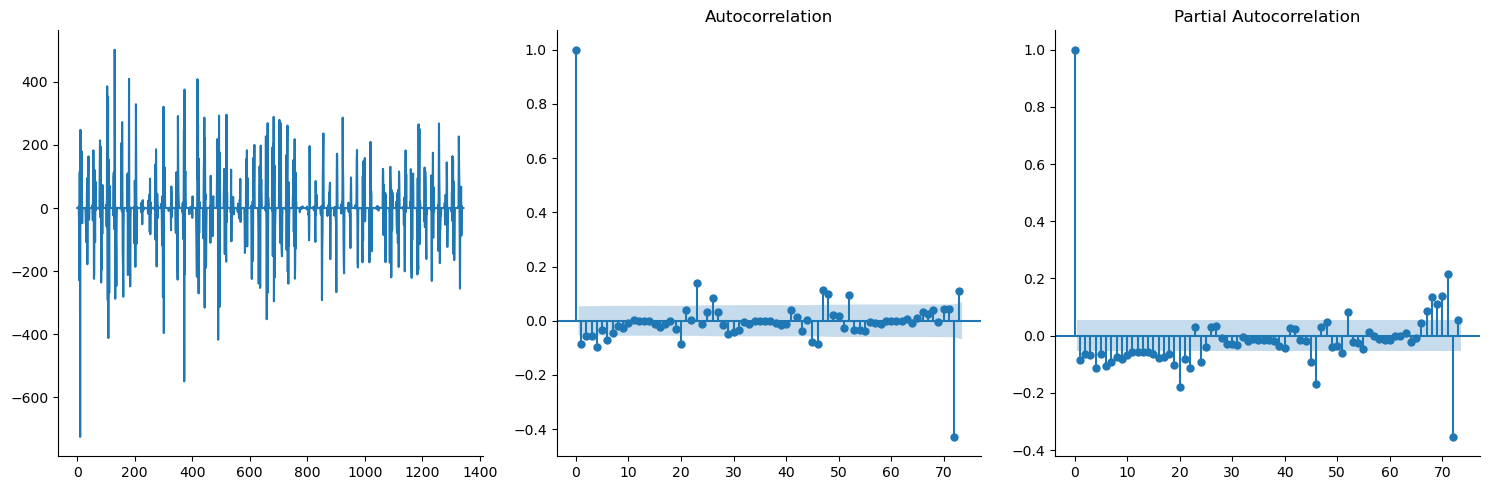

In [58]:
plots(additive_diff_production_1, lags=73)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 65.37740522219379,
 '4. Mean Error (ME)': 0.0005708854735612729,
 '5. Mean Absolute Error (MAE)': 37.9638751650091,
 '6. Correlation between the Actual and the Forecast (CORR)': 2.0862921752378747e-05}


 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 65.37740522588352,
 '4. Mean Error (ME)': 0.0005558934502308451,
 '5. Mean Absolute Error (MAE)': 37.96387540733675,
 '6. Correlation between the Actual and the Forecast (CORR)': -4.9344309512685635e-

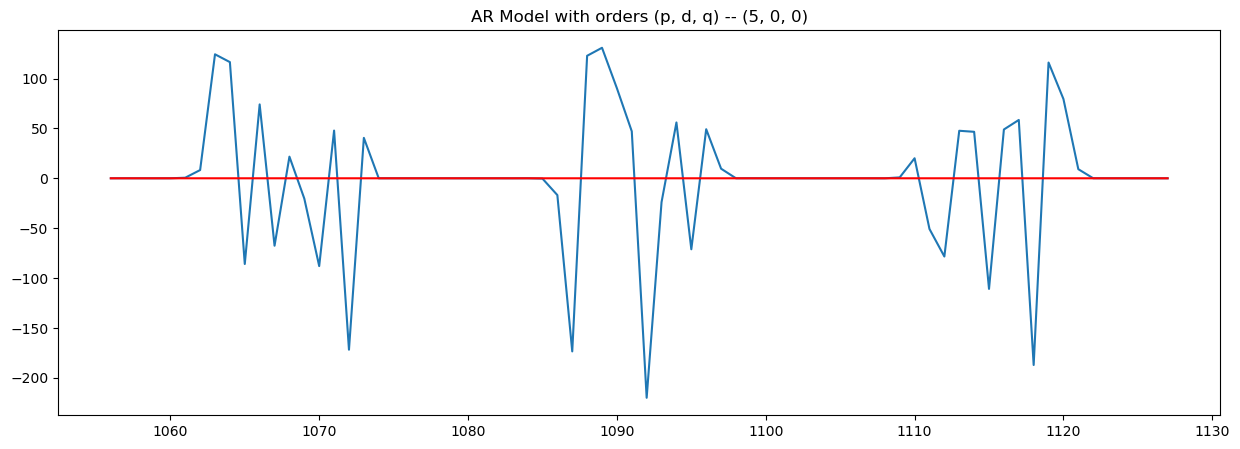



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (5, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49173823034324965,
 '2. Mean Percentage Error (MPE)': -0.48629592228694324,
 '3. Root Mean Squared Error (RMSE)': 349.6692953951799,
 '4. Mean Error (ME)': -202.46266167366034,
 '5. Mean Absolute Error (MAE)': 202.4691950107829,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.09363474604951413}


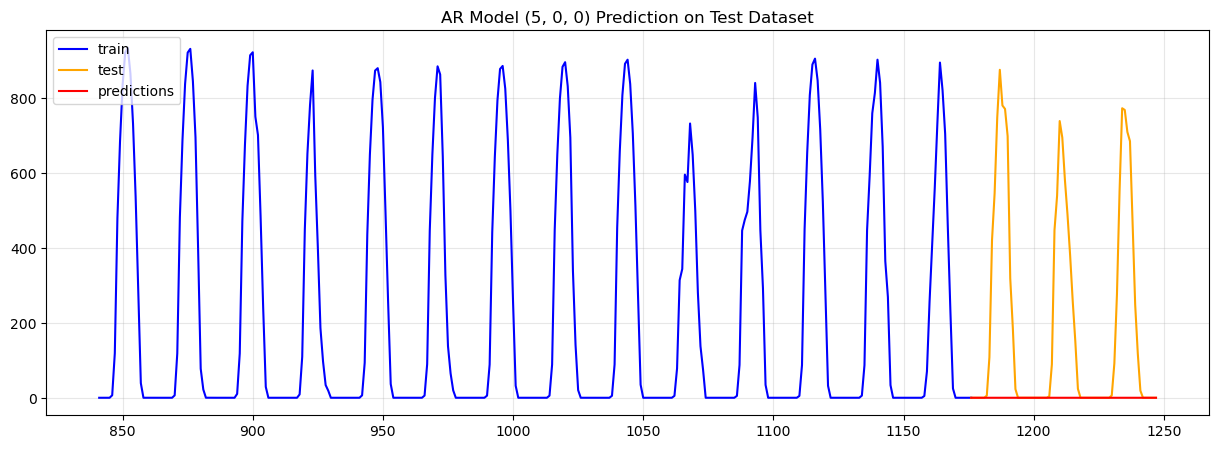










############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 65.37740522200929,
 '4. Mean Error (ME)': 0.0005647690354951212,
 '5. Mean Absolute Error (MAE)': 37.96387206170716,
 '6. Correlation between the Actual and the Forecast (CORR)': 1.7144292283262304e-05}


 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 65.37740522551489,
 '4. Mean Error (ME)': 0.0005430934908474683,
 '5. Mean Absolute Error (MAE)': 37.96387882437646,
 '6. Correlation between the Actual and the Forecast (CORR)': -2.46706786

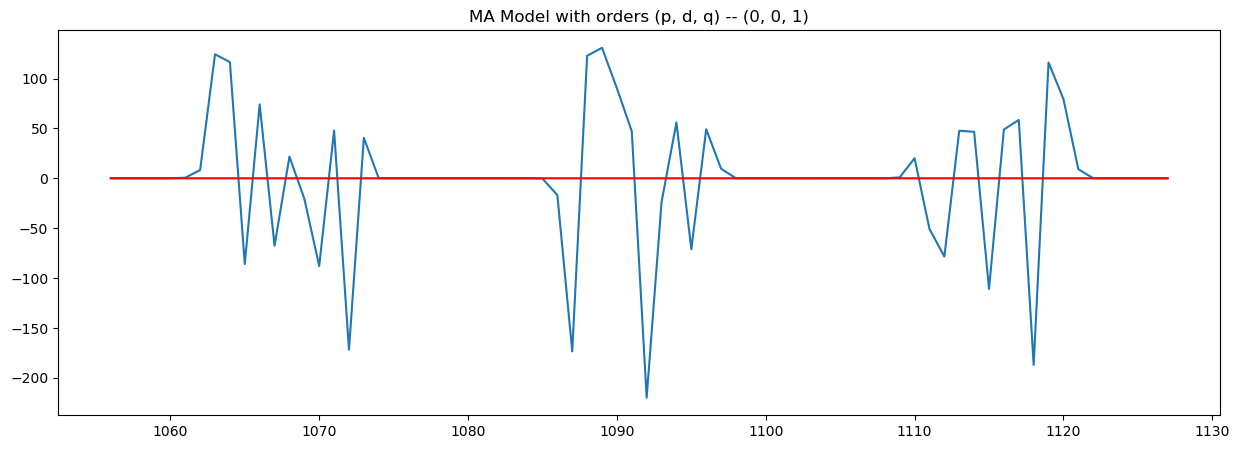



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4917105123802382,
 '2. Mean Percentage Error (MPE)': -0.48820805706003234,
 '3. Root Mean Squared Error (RMSE)': 349.67197844883486,
 '4. Mean Error (ME)': -202.46723670225026,
 '5. Mean Absolute Error (MAE)': 202.47143656428167,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.045167933375196354}


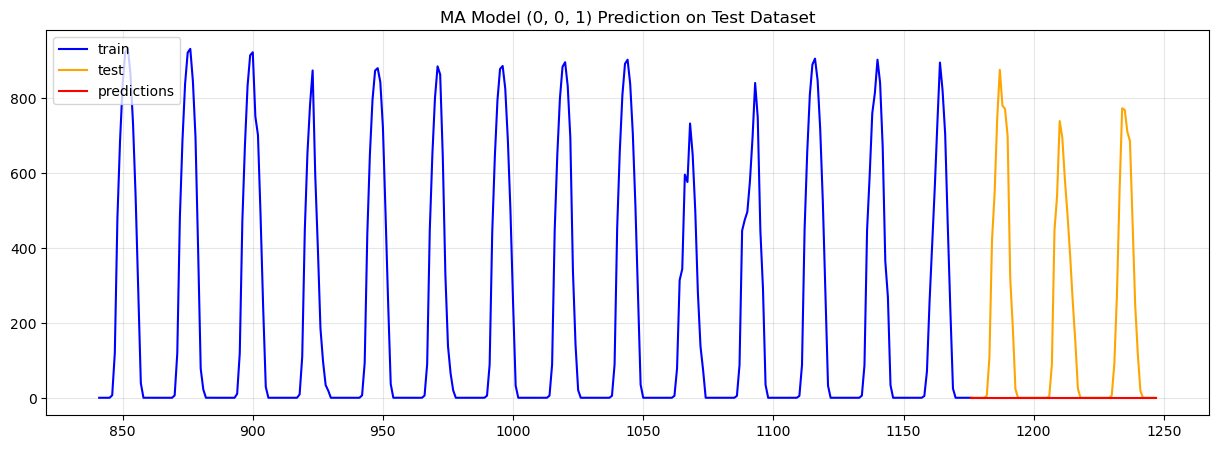










############################################################ ARMA Model ############################################################ 




 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 65.39233036957704,
 '4. Mean Error (ME)': -0.16940169980540057,
 '5. Mean Absolute Error (MAE)': 38.10507980205042,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.031078186798072404}


 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 65.39214600865134,
 '4. Mean Error (ME)': -0.17005137333000656,
 '5. Mean Absolute Error (MAE)': 38.106621238657304,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.02

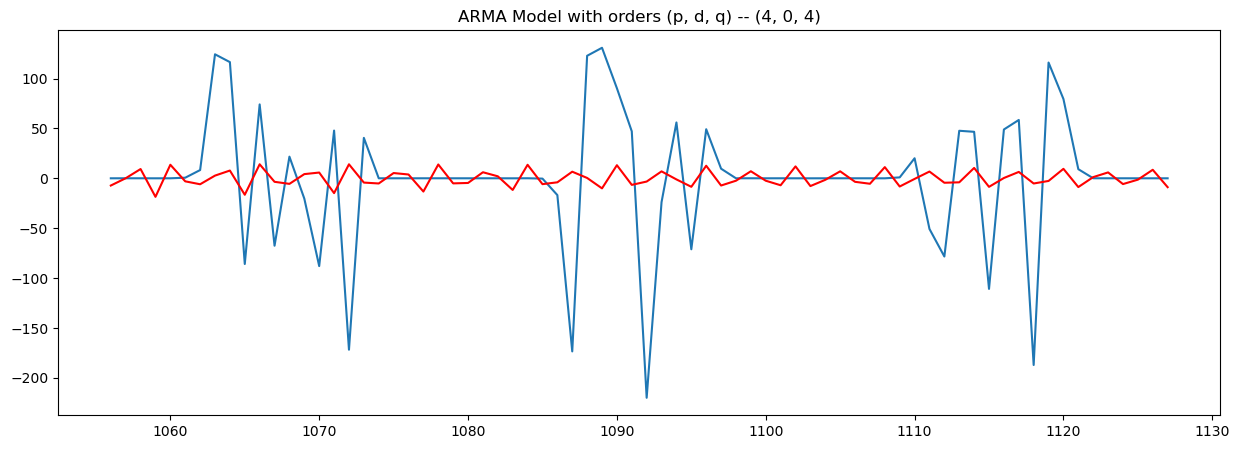



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (4, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 4.7201527971528305,
 '2. Mean Percentage Error (MPE)': -4.562916017148189,
 '3. Root Mean Squared Error (RMSE)': 355.5768529049467,
 '4. Mean Error (ME)': -212.38898203359,
 '5. Mean Absolute Error (MAE)': 212.57821324050005,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.012928261539798721}


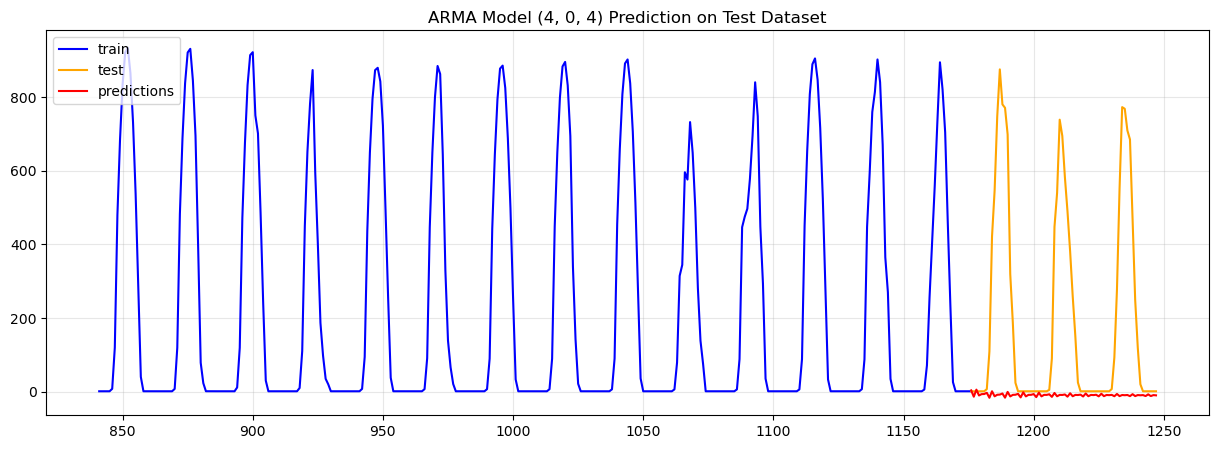










############################################################ ARIMA Model ############################################################ 




 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49485449661818165,
 '2. Mean Percentage Error (MPE)': -0.48315168233526307,
 '3. Root Mean Squared Error (RMSE)': 389.2747444161742,
 '4. Mean Error (ME)': -227.98319444444445,
 '5. Mean Absolute Error (MAE)': 227.99736111111113,
 '6. Correlation between the Actual and the Forecast (CORR)': 9.758277216184602e-17}


 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5525554881579643,
 '2. Mean Percentage Error (MPE)': -0.4226247983065741,
 '3. Root Mean Squared Error (RMSE)': 389.19040185969385,
 '4. Mean Error (ME)': -227.83915205364852,
 '5. Mean Absolute Error (MAE)': 227.99708333333334,
 '

✅ [ERROR] - [2022-04-26 18:12:27] - (1422772745.py).optimize_ARIMA_models(22): Error during fit ARIMA model with the next parameters -- (3, 2, 4), 
context of the error -- LU decomposition error.




 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (4, 1, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49793869698706594,
 '2. Mean Percentage Error (MPE)': -0.4796985128564114,
 '3. Root Mean Squared Error (RMSE)': 389.2703418285364,
 '4. Mean Error (ME)': -227.97526933014927,
 '5. Mean Absolute Error (MAE)': 227.99738566956532,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.24934743490831807}


 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (4, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 92.78673004538724,
 '2. Mean Percentage Error (MPE)': 92.39655890669655,
 '3. Root Mean Squared Error (RMSE)': 309.30135832761823,
 '4. Mean Error (ME)': 3.1171874453708233,
 '5. Mean Absolute Error (MAE)': 269.83288668143535,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.2157444244363486}


 ==================== Forecast Accuracy [ARIMA Model] ================

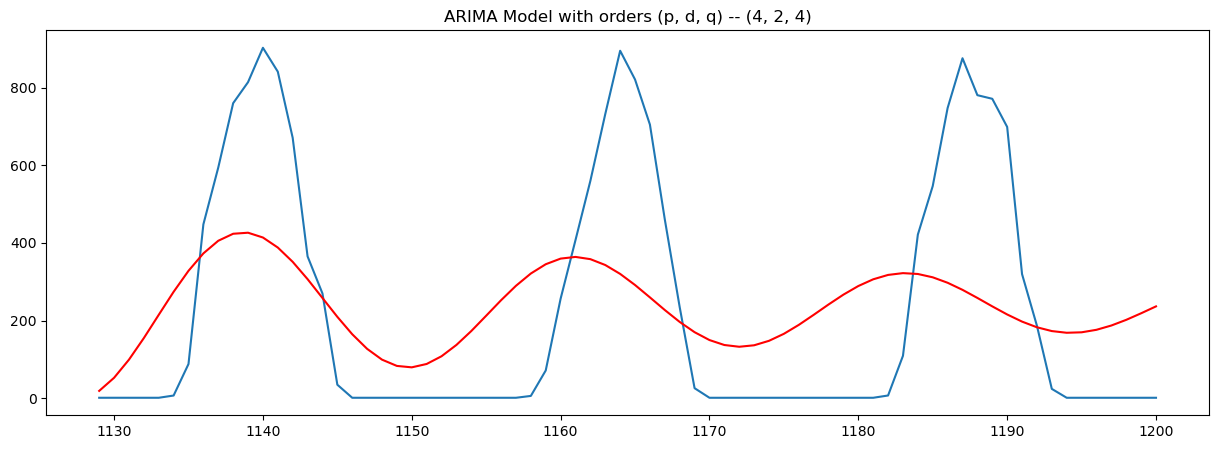



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (4, 2, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 110.09056831857431,
 '2. Mean Percentage Error (MPE)': -110.09056831857431,
 '3. Root Mean Squared Error (RMSE)': 483.17227523661717,
 '4. Mean Error (ME)': -428.15438518111495,
 '5. Mean Absolute Error (MAE)': 428.15438518111495,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.44623243534034823}


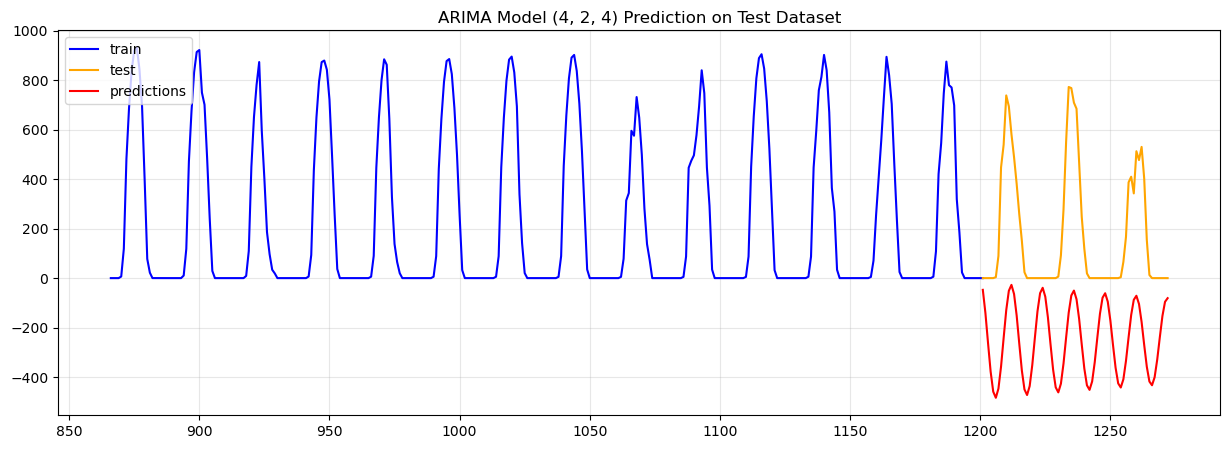

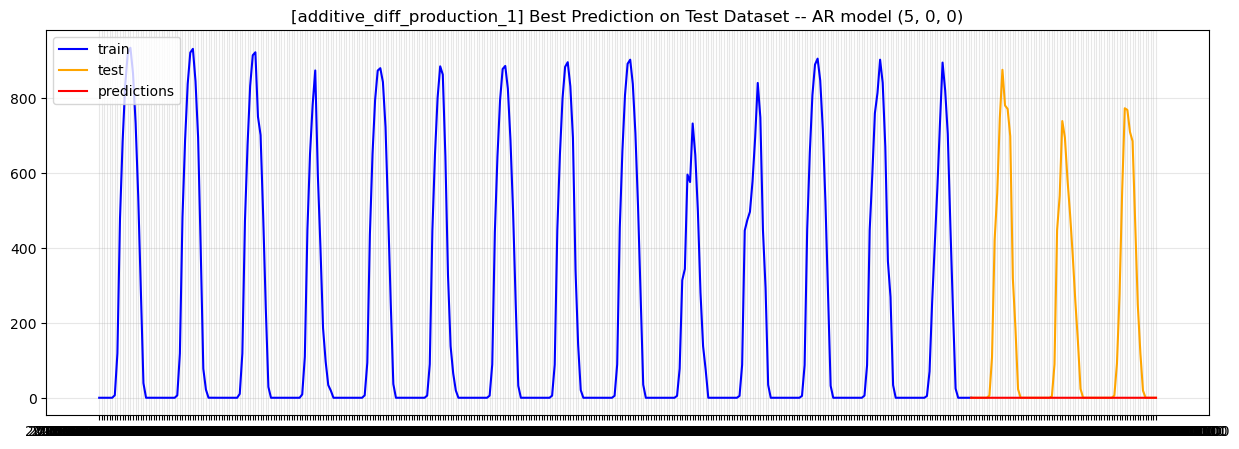

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.67814930114847,
 '4. Mean Error (ME)': 0.00042116926788003813,
 '5. Mean Absolute Error (MAE)': 46.36956878459882,
 '6. Correlation between the Actual and the Forecast (CORR)': 1.8836767531686242e-05}


 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.67814930417484,
 '4. Mean Error (ME)': 0.0004370425030310167,
 '5. Mean Absolute Error (MAE)': 46.36956944186347,
 '6. Correlation between the Actual and the Forecast (CORR)': -1.78797599181784

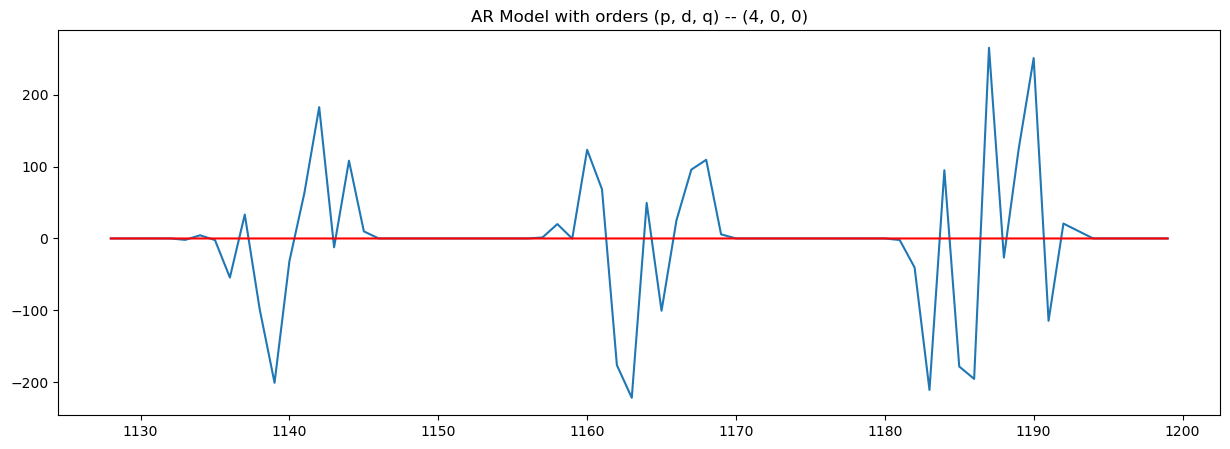



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (4, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4919894150994843,
 '2. Mean Percentage Error (MPE)': -0.48229035432875794,
 '3. Root Mean Squared Error (RMSE)': 315.3920237054817,
 '4. Mean Error (ME)': -181.9216951603067,
 '5. Mean Absolute Error (MAE)': 181.93325261571206,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.0397290607962032}


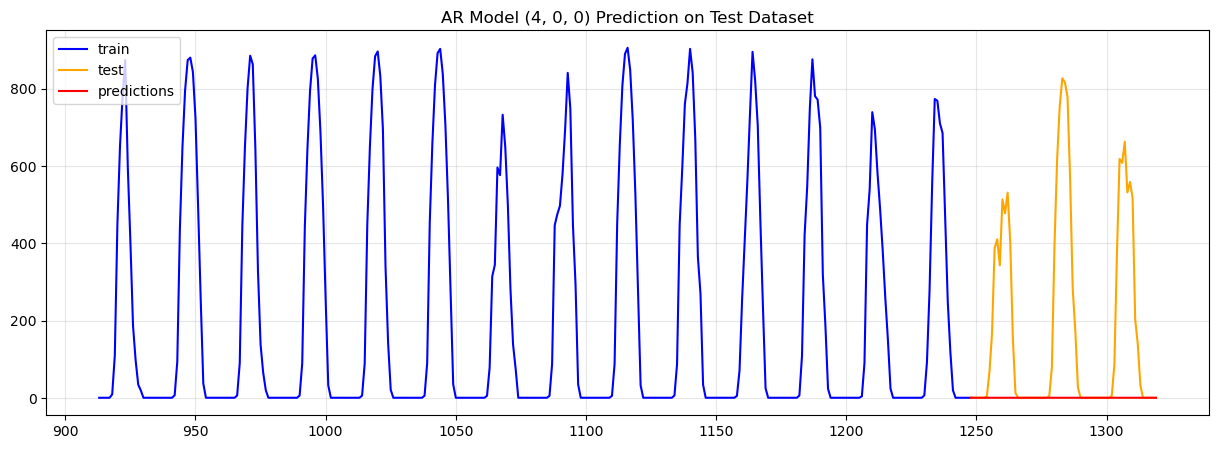










############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.67814930121571,
 '4. Mean Error (ME)': 0.0004275265940410438,
 '5. Mean Absolute Error (MAE)': 46.36956557821289,
 '6. Correlation between the Actual and the Forecast (CORR)': 1.4428776812030465e-05}


 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.67814943548474,
 '4. Mean Error (ME)': -0.00022318815710301956,
 '5. Mean Absolute Error (MAE)': 46.36997292879261,
 '6. Correlation between the Actual and the Forecast (CORR)': -4.5249

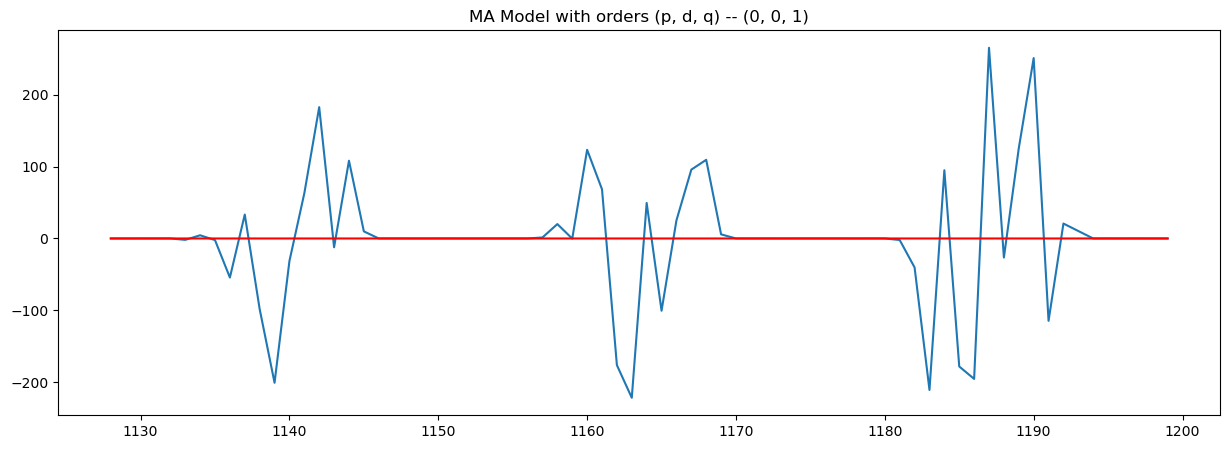



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4912907675909963,
 '2. Mean Percentage Error (MPE)': -0.48351431762142677,
 '3. Root Mean Squared Error (RMSE)': 315.39369318279296,
 '4. Mean Error (ME)': -181.92457282918028,
 '5. Mean Absolute Error (MAE)': 181.93382765787004,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.05703722046466019}


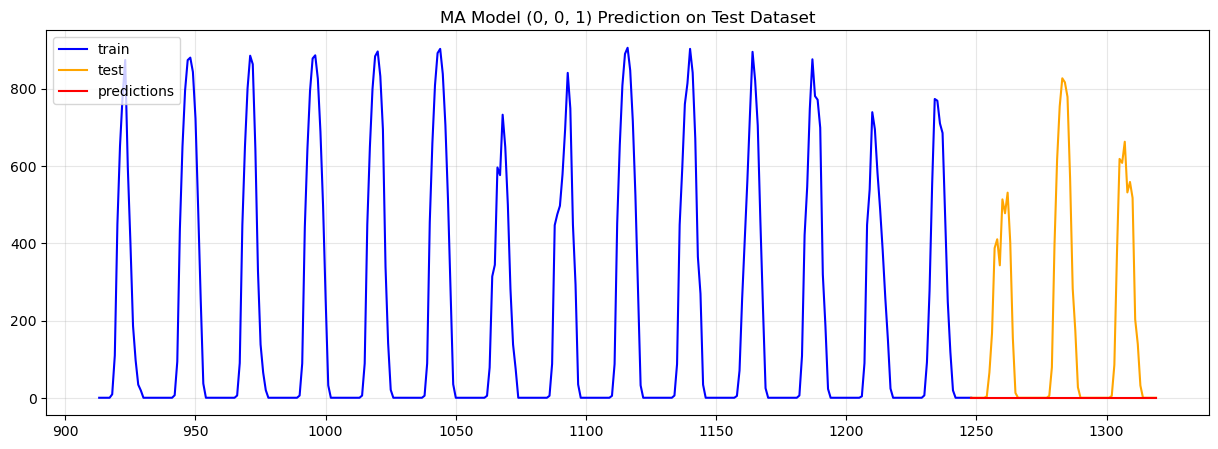










############################################################ ARMA Model ############################################################ 




 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.6749097109498,
 '4. Mean Error (ME)': -0.11575817460733775,
 '5. Mean Absolute Error (MAE)': 46.440148900897384,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.013108889001043676}


 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.6750616457538,
 '4. Mean Error (ME)': -0.11585554652261562,
 '5. Mean Absolute Error (MAE)': 46.44124490163396,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.012459

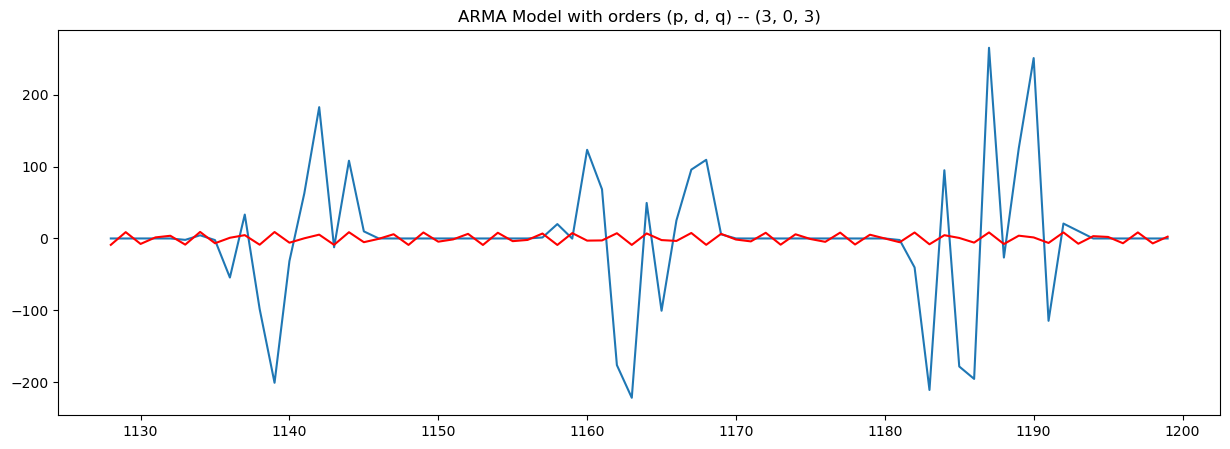



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (3, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 7.536549873563899,
 '2. Mean Percentage Error (MPE)': -7.395769269018621,
 '3. Root Mean Squared Error (RMSE)': 325.9505919197612,
 '4. Mean Error (ME)': -198.77243698718314,
 '5. Mean Absolute Error (MAE)': 198.94278151868292,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.10889018951142607}


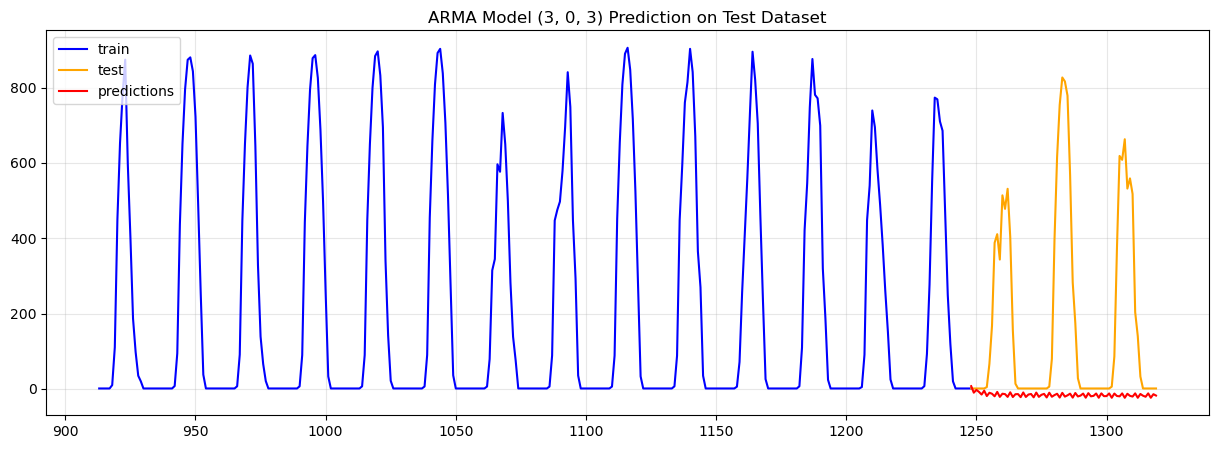










############################################################ ARIMA Model ############################################################ 




 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4918714622303624,
 '2. Mean Percentage Error (MPE)': -0.4807364231654764,
 '3. Root Mean Squared Error (RMSE)': 302.66224877236414,
 '4. Mean Error (ME)': -174.51958333333334,
 '5. Mean Absolute Error (MAE)': 174.53291666666667,
 '6. Correlation between the Actual and the Forecast (CORR)': nan}


 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5691270214486275,
 '2. Mean Percentage Error (MPE)': -0.39890254927908536,
 '3. Root Mean Squared Error (RMSE)': 302.5514254371432,
 '4. Mean Error (ME)': -174.32731618694498,
 '5. Mean Absolute Error (MAE)': 174.5326388888889,
 '6. Correlation betwe

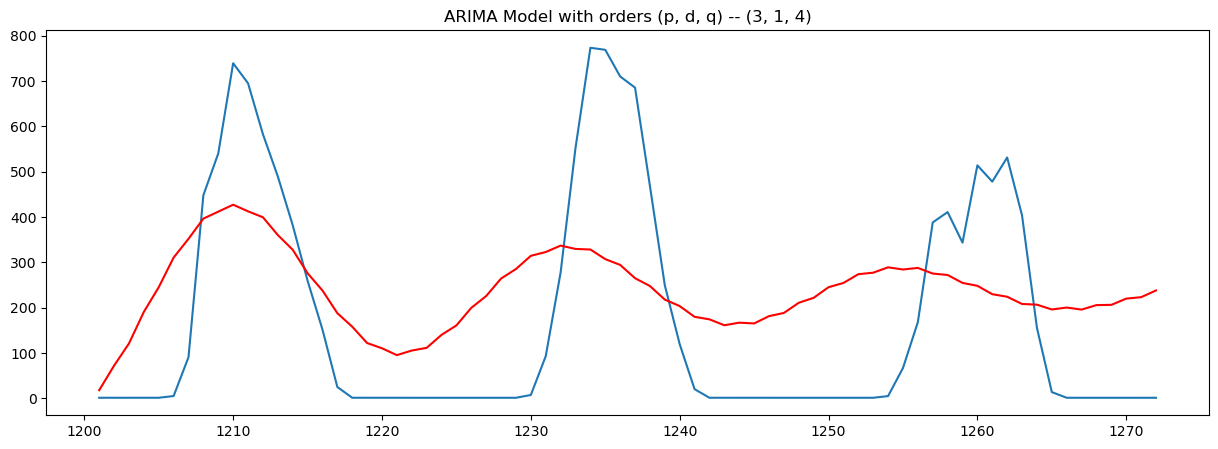



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (3, 1, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 55.89827347831969,
 '2. Mean Percentage Error (MPE)': 55.47888984033264,
 '3. Root Mean Squared Error (RMSE)': 261.22880419048676,
 '4. Mean Error (ME)': -37.82307197457209,
 '5. Mean Absolute Error (MAE)': 205.1404117096817,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.42484421841776454}


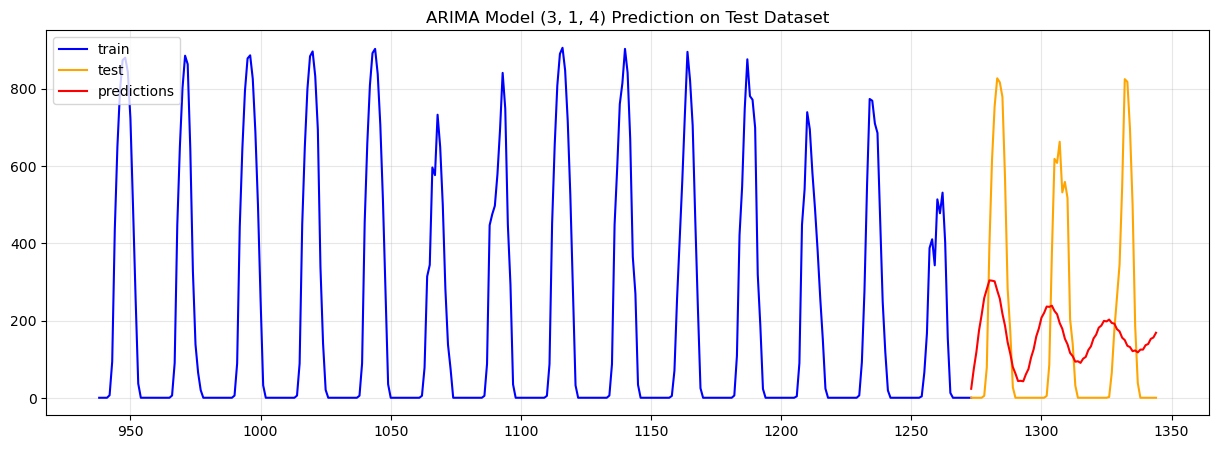

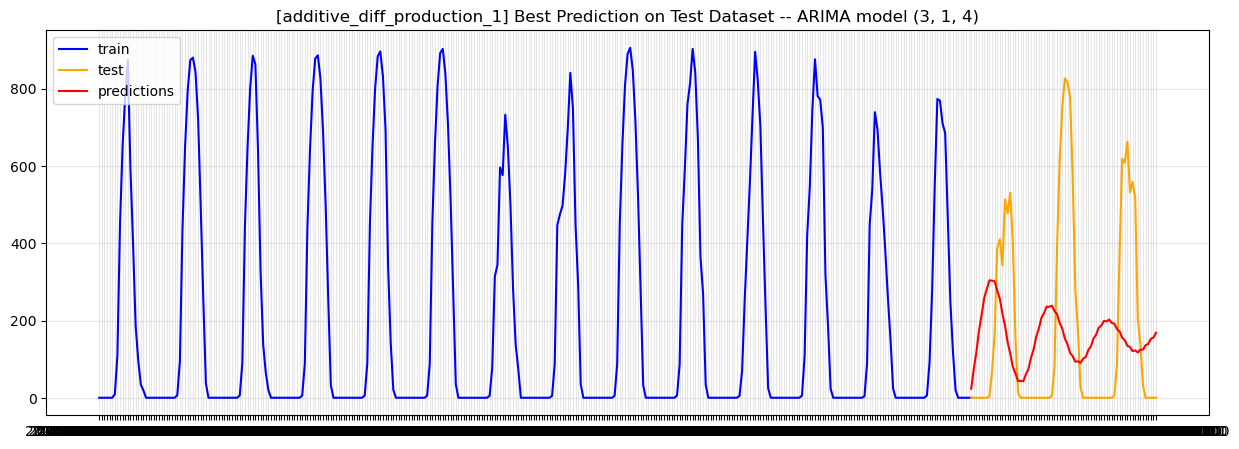

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.18324404386328,
 '4. Mean Error (ME)': -0.0011444871582679322,
 '5. Mean Absolute Error (MAE)': 37.145282449882,
 '6. Correlation between the Actual and the Forecast (CORR)': -1.3421471559718198e-05}


 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.18324404297685,
 '4. Mean Error (ME)': -0.0011287496174203523,
 '5. Mean Absolute Error (MAE)': 37.145267200883026,
 '6. Correlation between the Actual and the Forecast (CORR)': 5.10723276362843

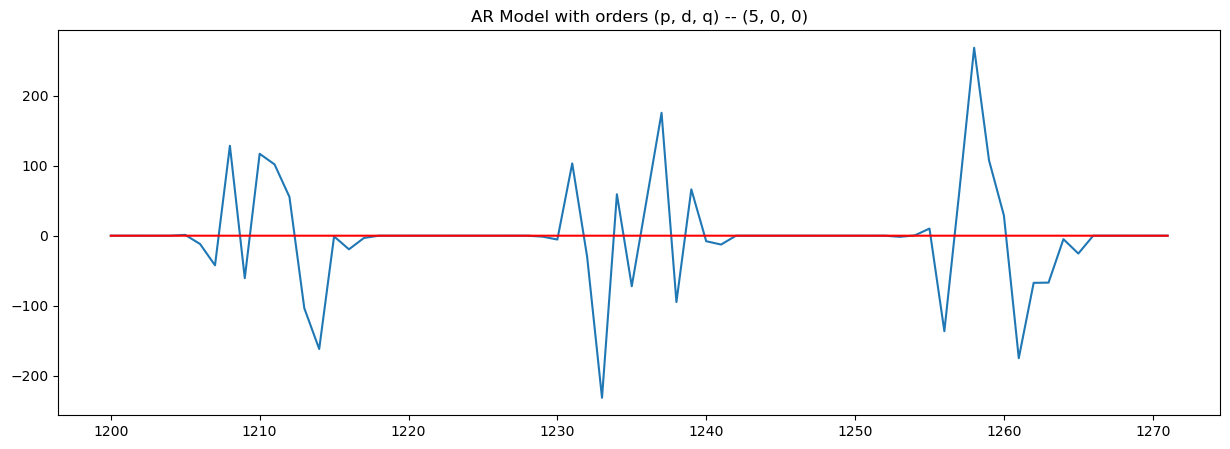



 ==================== Forecast Accuracy on Test Set [AR Model] ====================
Order (p, d, q) --  (5, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4900766343649635,
 '2. Mean Percentage Error (MPE)': -0.4833820854156956,
 '3. Root Mean Squared Error (RMSE)': 373.92426342275127,
 '4. Mean Error (ME)': -217.97773699767848,
 '5. Mean Absolute Error (MAE)': 217.98576911060576,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.004193189503210321}


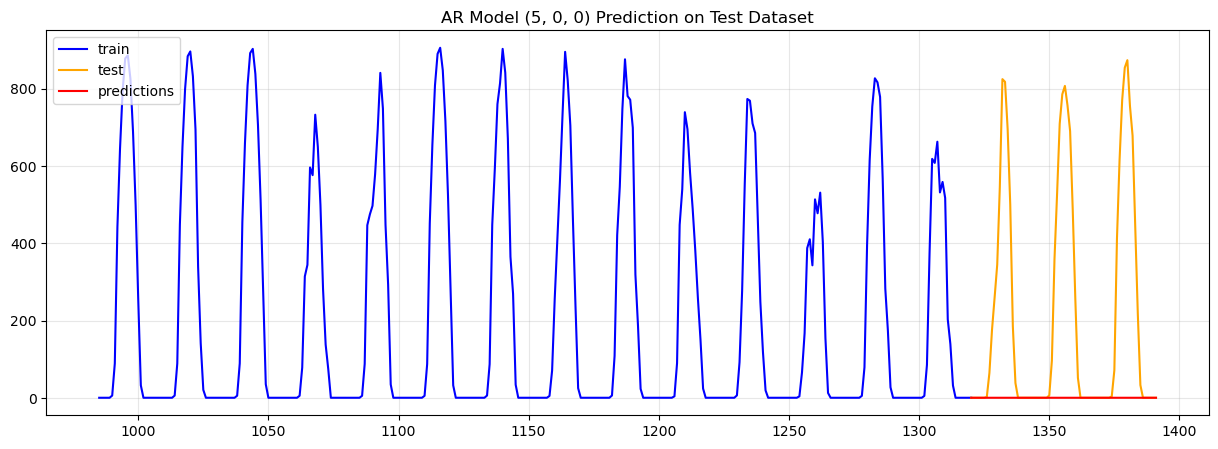










############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.18324404335746,
 '4. Mean Error (ME)': -0.0011409037601934654,
 '5. Mean Absolute Error (MAE)': 37.14527886625424,
 '6. Correlation between the Actual and the Forecast (CORR)': 1.5030895821610448e-05}


 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.18324408628402,
 '4. Mean Error (ME)': -0.0013455337885568655,
 '5. Mean Absolute Error (MAE)': 37.14548362359525,
 '6. Correlation between the Actual and the Forecast (CORR)': -1.8603

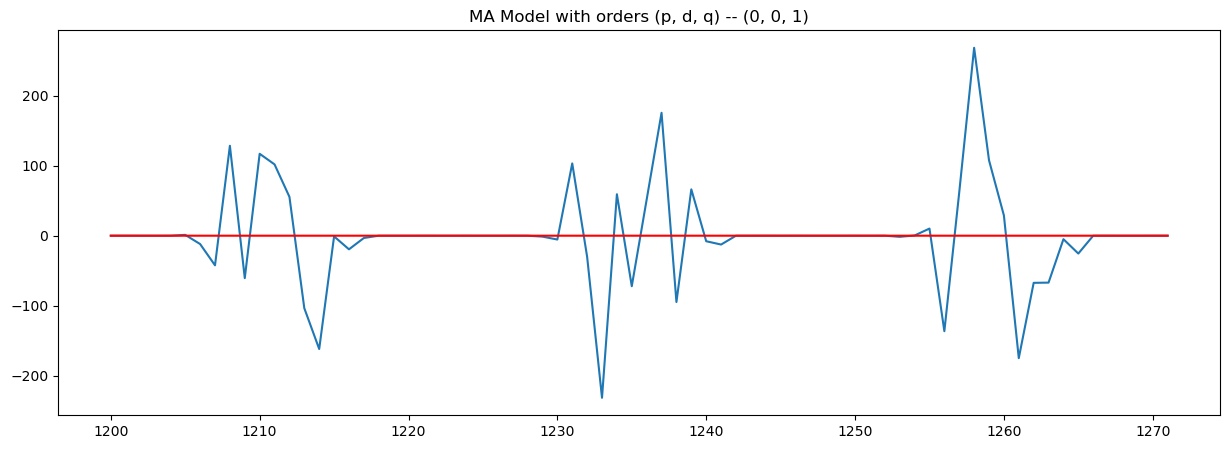



 ==================== Forecast Accuracy on Test Set [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4912842705626698,
 '2. Mean Percentage Error (MPE)': -0.4811989180883379,
 '3. Root Mean Squared Error (RMSE)': 373.92119765758906,
 '4. Mean Error (ME)': -217.9725482385939,
 '5. Mean Absolute Error (MAE)': 217.9846639154819,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.08231071927627279}


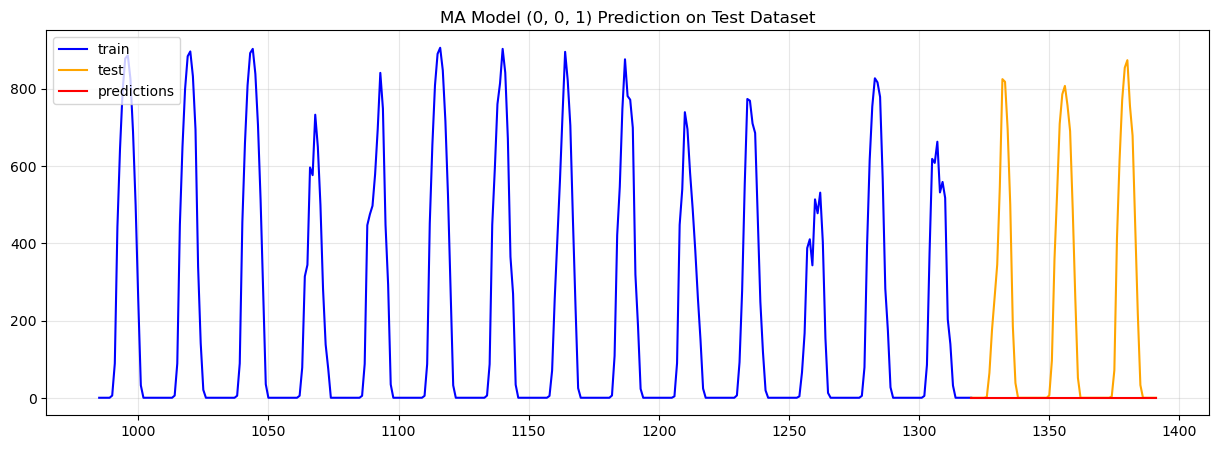










############################################################ ARMA Model ############################################################ 




 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.1960584892017,
 '4. Mean Error (ME)': -0.291076187345158,
 '5. Mean Absolute Error (MAE)': 37.34805223064843,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.010535110143494862}


 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.19576373080679,
 '4. Mean Error (ME)': -0.29149344233957286,
 '5. Mean Absolute Error (MAE)': 37.35200053655621,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.009717

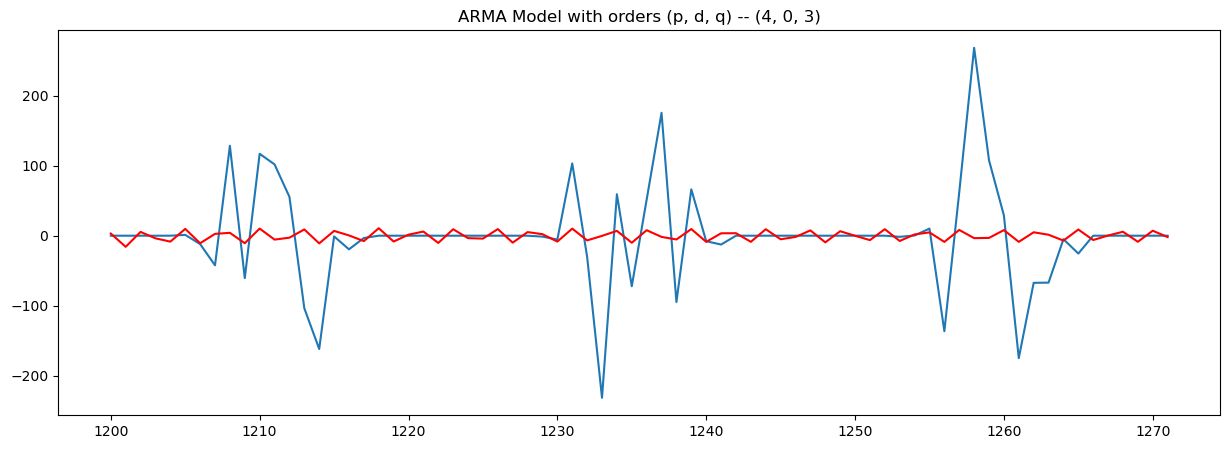



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (4, 0, 3)
{'1. Mean Absolute Percentage Error (MAPE)': 5.7837173755818,
 '2. Mean Percentage Error (MPE)': -5.735605958770184,
 '3. Root Mean Squared Error (RMSE)': 381.5292671744585,
 '4. Mean Error (ME)': -230.4368525910926,
 '5. Mean Absolute Error (MAE)': 230.49506740543464,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.037432682153154026}


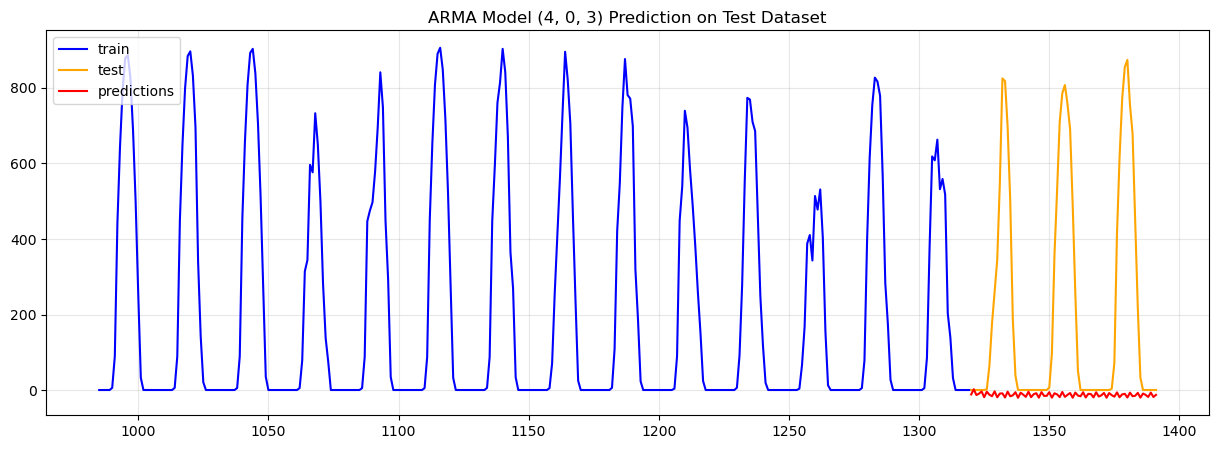










############################################################ ARIMA Model ############################################################ 




 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49695229140648867,
 '2. Mean Percentage Error (MPE)': -0.49695229140648867,
 '3. Root Mean Squared Error (RMSE)': 340.942075694929,
 '4. Mean Error (ME)': -195.6273611111111,
 '5. Mean Absolute Error (MAE)': 195.6273611111111,
 '6. Correlation between the Actual and the Forecast (CORR)': nan}


 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5031693924742492,
 '2. Mean Percentage Error (MPE)': -0.4680543495191228,
 '3. Root Mean Squared Error (RMSE)': 340.9031856663761,
 '4. Mean Error (ME)': -195.55957515195738,
 '5. Mean Absolute Error (MAE)': 195.6018055555556,
 '6. Correlation between 

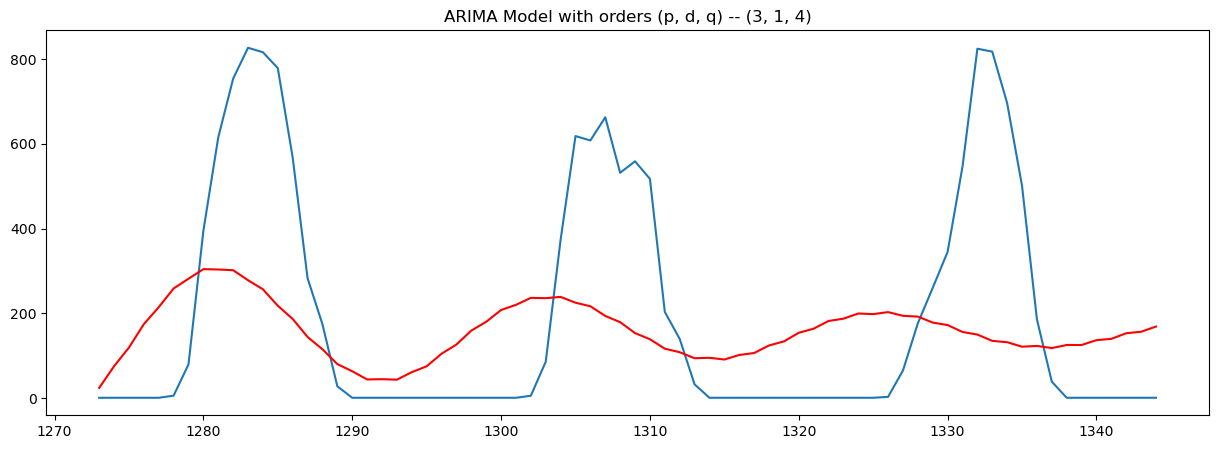



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (3, 1, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 60.150855761842,
 '2. Mean Percentage Error (MPE)': 59.71534185221169,
 '3. Root Mean Squared Error (RMSE)': 294.012181307868,
 '4. Mean Error (ME)': -55.98620931732995,
 '5. Mean Absolute Error (MAE)': 237.9297759999081,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.6010612876679187}


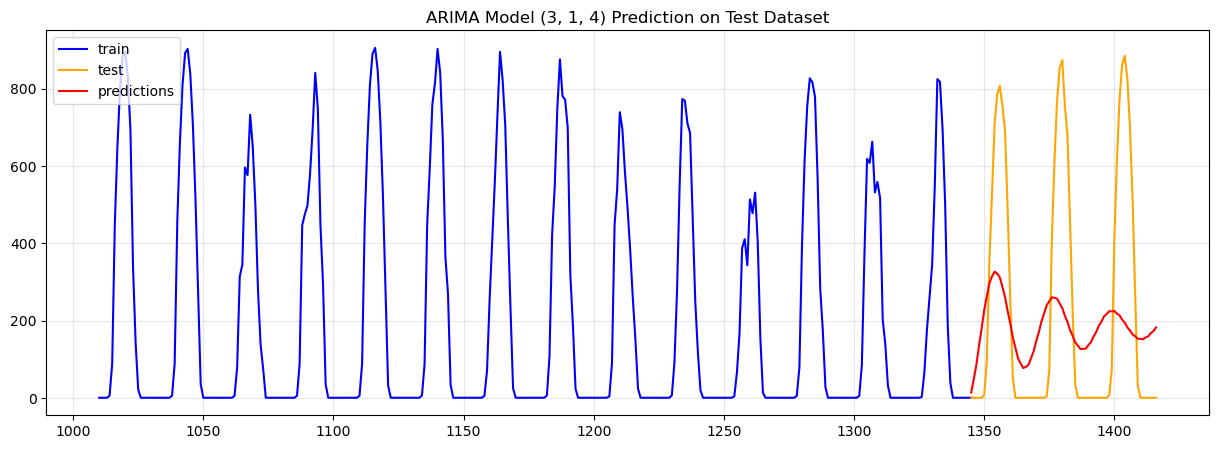

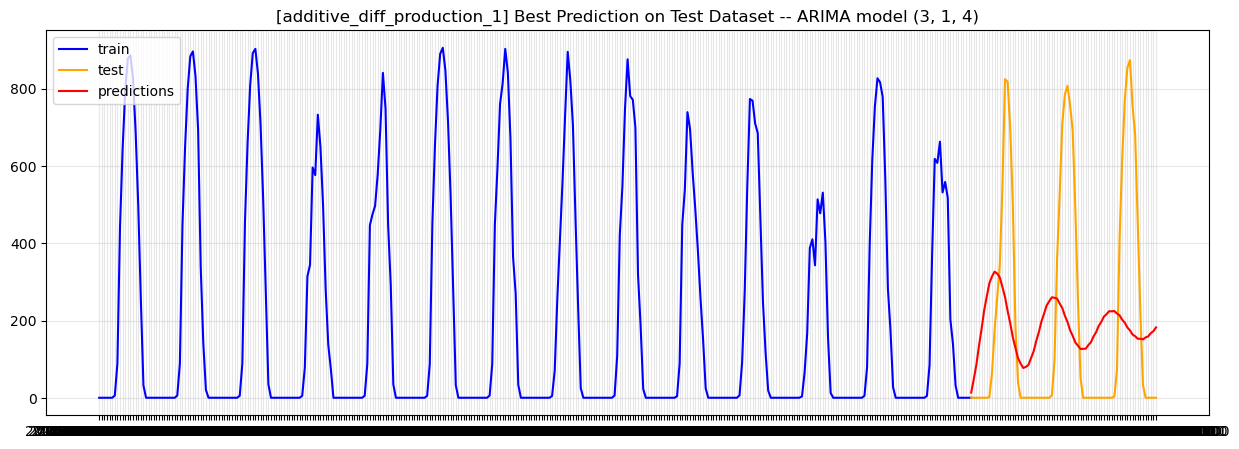

In [59]:
# additive_diff_production_1_results_df = test_ARIMA_models(hourly_radiation_reset_df,additive_diff_production_1,
#                                                           hourly_radiation_reset_df.Radiation, 'additive_diff_production_1',
#                                                           show_plots=True, debug_mode=True)

### Test multiplicative_diff_production_1 stationary series

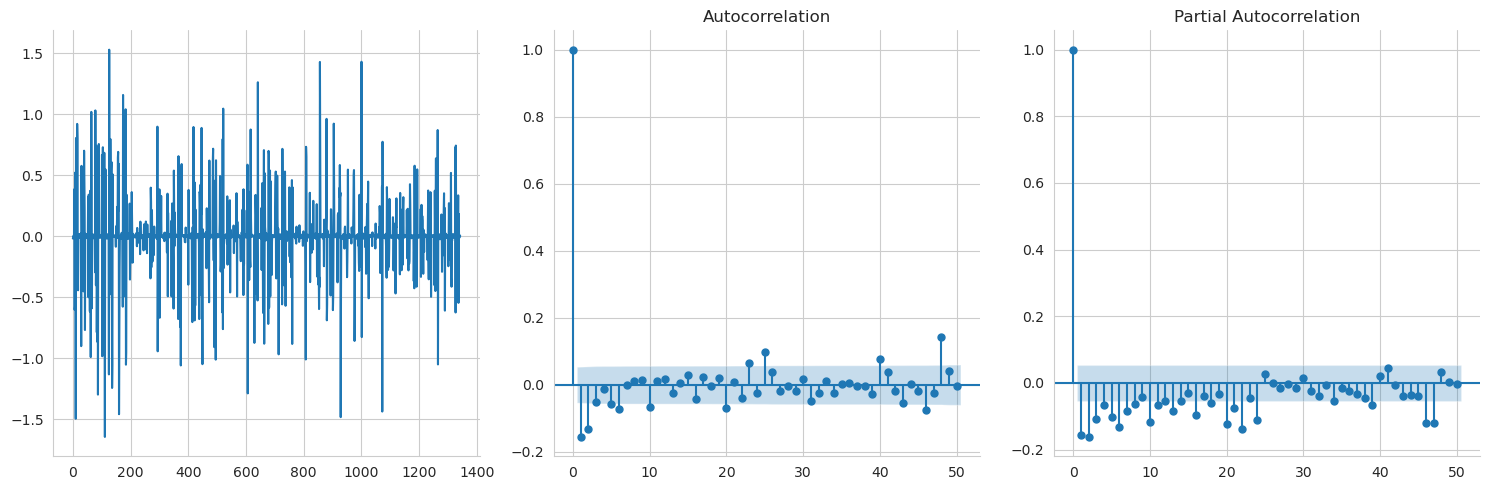

In [119]:
plots(multiplicative_diff_production_1, lags=73)

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49197065192110045,
 '2. Mean Percentage Error (MPE)': -0.4806118635093448,
 '3. Root Mean Squared Error (RMSE)': 302.66217237031213,
 '4. Mean Error (ME)': -174.5193066924922,
 '5. Mean Absolute Error (MAE)': 174.5329387458211,
 '6. Correlation between the Actual and the Fo

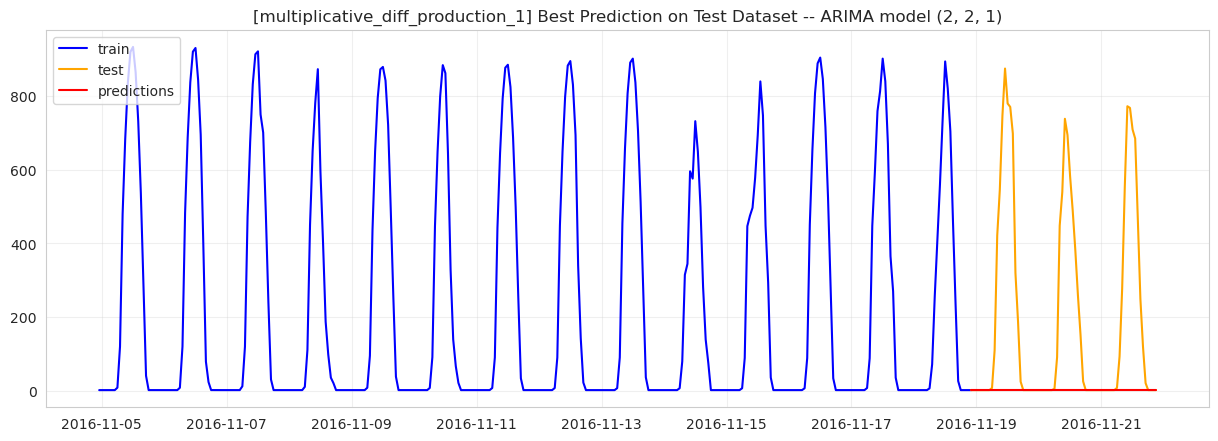

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (1, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5022787768704121,
 '2. Mean Percentage Error (MPE)': -0.5022787768704121,
 '3. Root Mean Squared Error (RMSE)': 340.9500491196197,
 '4. Mean Error (ME)': -195.64040726817058,
 '5. Mean Absolute Error (MAE)': 195.64040726817058,
 '6. Correlation between the Actual and the Fo

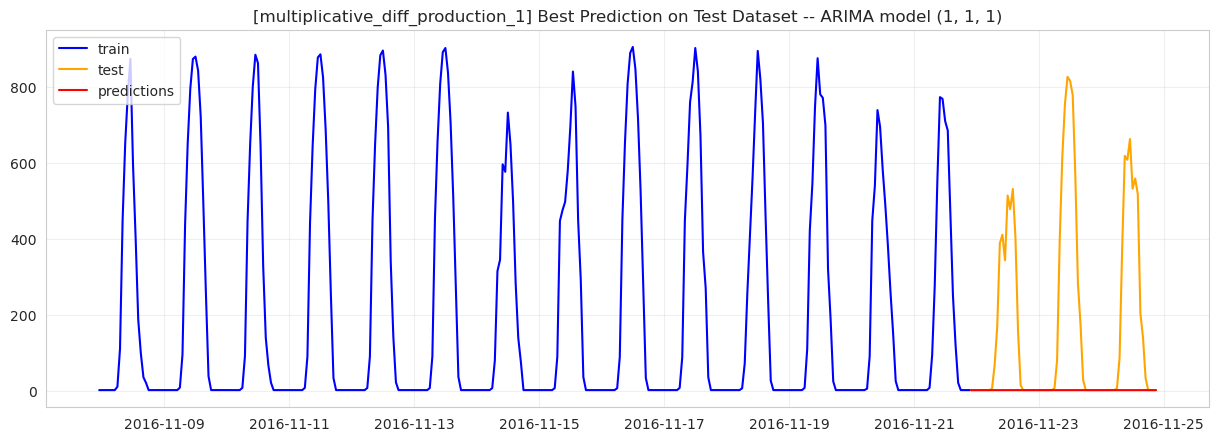

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.500407793570513,
 '2. Mean Percentage Error (MPE)': -0.4769821298200876,
 '3. Root Mean Squared Error (RMSE)': 401.55752704890097,
 '4. Mean Error (ME)': -238.86097478565418,
 '5. Mean Absolute Error (MAE)': 238.88911972842138,
 '6. Correlation between the Actual and the Fo

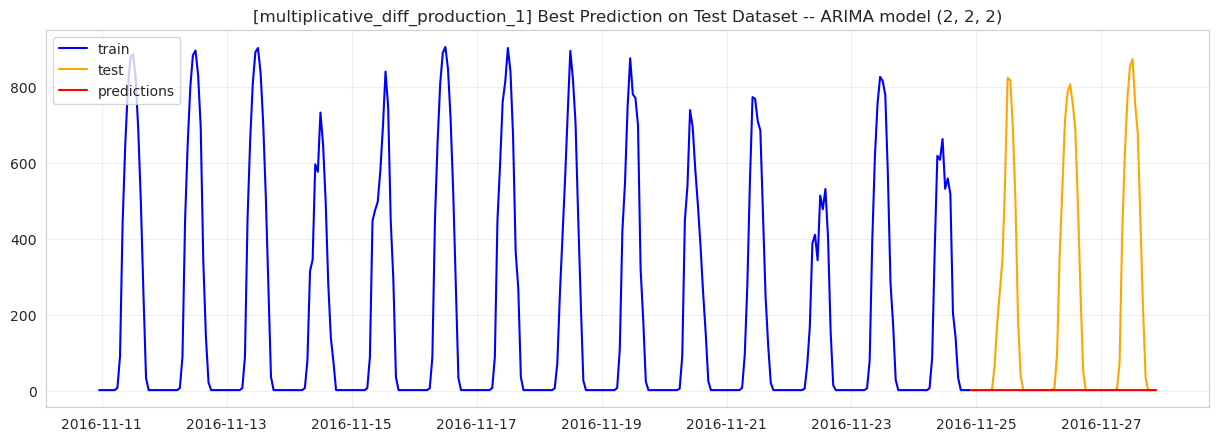

In [120]:
# multiplicative_diff_production_1_results_df = test_ARIMA_models(hourly_radiation_reset_df, multiplicative_diff_production_1,
#                                                                 hourly_radiation_reset_df.Log_Radiation, 'multiplicative_diff_production_1',
#                                                                 show_plots=False, debug_mode=False)

### Test additive_diff_production_12 stationary series

In [121]:
# plots(additive_diff_production_12, lags=50)

In [122]:
# additive_diff_production_12_results_df = test_ARIMA_models(hourly_radiation_reset_df, additive_diff_production_12,
#                                                           hourly_radiation_reset_df.Radiation, 'additive_diff_production_12',
#                                                           show_plots=False, debug_mode=False)

### Test multiplicative_diff_production_12 stationary series

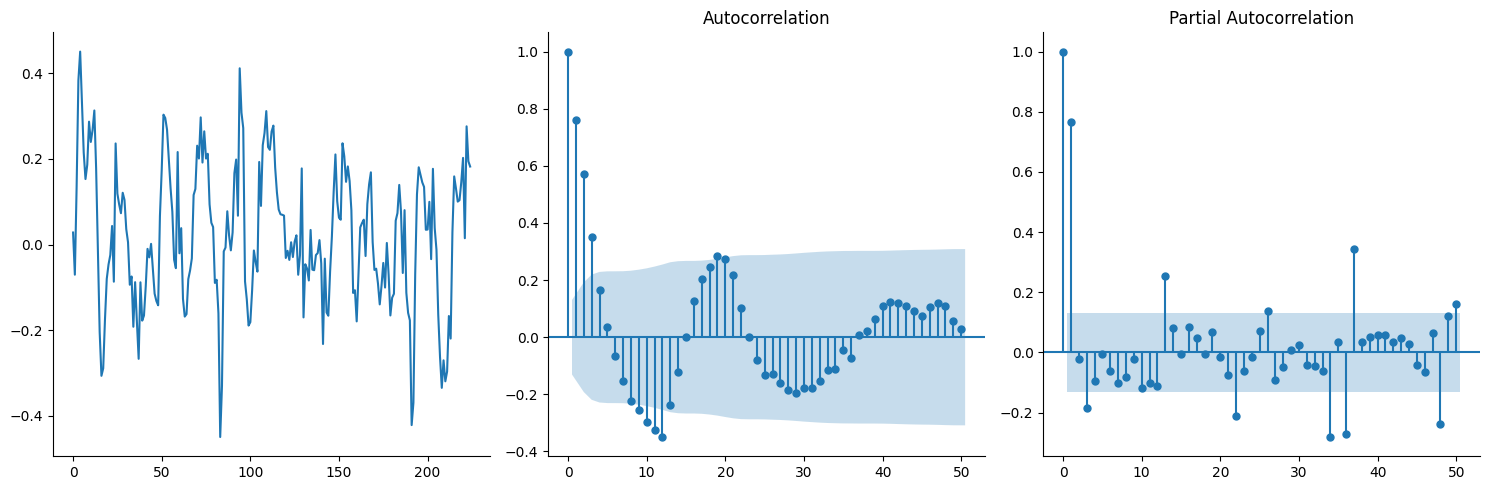

In [817]:
plots(multiplicative_diff_production_12, lags=73)

From ACF plot we can find out that lag 1, lag 2, lag 3 is the most significant. From PACF plot just lag 1 is the most significant. However, to be more certain we tune ARIMA models on different orders.

Actually, models showed bad performance on stationary time series created with differencing. Here I just show results, which are common for all such stationary time series like for additive hypothesis, also for multiplicative one.

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49197065192110045,
 '2. Mean Percentage Error (MPE)': -0.4806118635093448,
 '3. Root Mean Squared Error (RMSE)': 302.66217237031213,
 '4. Mean Error (ME)': -174.5193066924922,
 '5. Mean Absolute Error (MAE)': 174.5329387458211,
 '6. Correlation between the Actual and the Fo

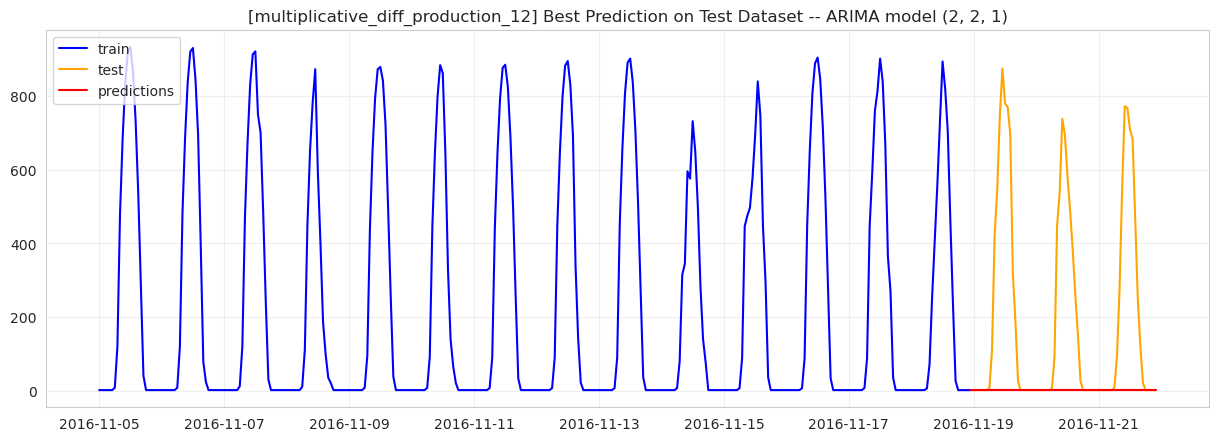

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (1, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5022787768704121,
 '2. Mean Percentage Error (MPE)': -0.5022787768704121,
 '3. Root Mean Squared Error (RMSE)': 340.9500491196197,
 '4. Mean Error (ME)': -195.64040726817058,
 '5. Mean Absolute Error (MAE)': 195.64040726817058,
 '6. Correlation between the Actual and the Fo

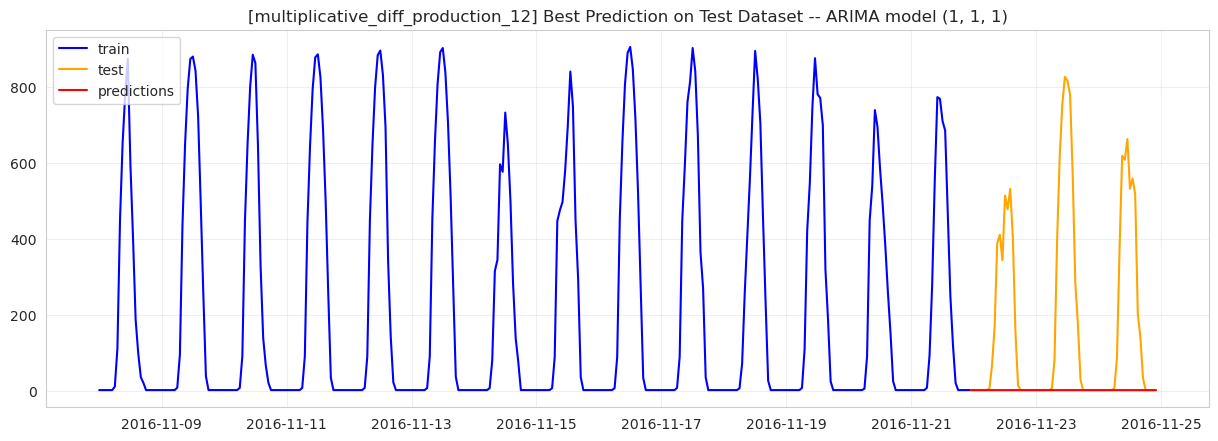

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.500407793570513,
 '2. Mean Percentage Error (MPE)': -0.4769821298200876,
 '3. Root Mean Squared Error (RMSE)': 401.55752704890097,
 '4. Mean Error (ME)': -238.86097478565418,
 '5. Mean Absolute Error (MAE)': 238.88911972842138,
 '6. Correlation between the Actual and the Fo

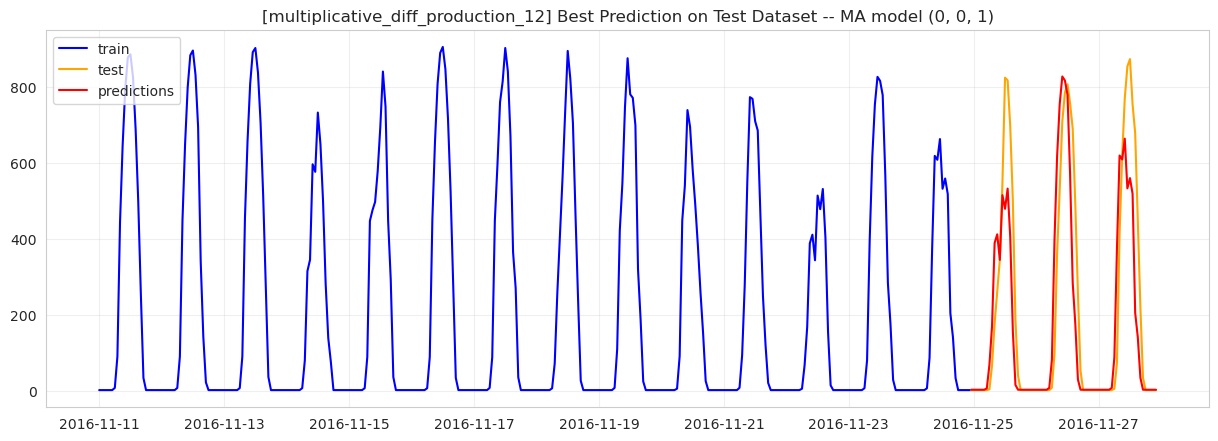

In [118]:
multiplicative_diff_production_12_results_df = test_ARIMA_models(hourly_radiation_reset_df, multiplicative_diff_production_12,
                                                          hourly_radiation_reset_df.Log_Radiation, 'multiplicative_diff_production_12',
                                                          show_plots=False, debug_mode=False)
multiplicative_diff_production_12_results_df

<a id='conclusion'></a>
## Conclusion

### Best Forcasts of AR, MA, ARMA and ARIMA models (based on Cross-Validation)

In [123]:
total_results_df = pd.concat([
    additive_decomposed_radiation_results_df, multiplicative_decomposed_radiation_results_df,
    # additive_diff_production_1_results_df, multiplicative_diff_production_1_results_df,
    # additive_diff_production_12_results_df,
    multiplicative_diff_production_12_results_df
])
total_results_df

Iteration               Stationary_Series_Name   Model_Name Model_Orders  \
0         1        additive_decomposed_radiation   ARMA model    (1, 0, 1)   
1         2        additive_decomposed_radiation   ARMA model    (1, 0, 1)   
2         3        additive_decomposed_radiation   ARMA model    (4, 0, 4)   
0         1  multiplicative_decomposed_radiation   ARMA model    (1, 0, 1)   
1         2  multiplicative_decomposed_radiation   ARMA model    (3, 0, 4)   
2         3  multiplicative_decomposed_radiation   ARMA model    (2, 0, 4)   
0         1    multiplicative_diff_production_12  ARIMA model    (2, 2, 1)   
1         2    multiplicative_diff_production_12  ARIMA model    (1, 1, 1)   
2         3    multiplicative_diff_production_12     MA model    (0, 0, 1)   

   Mean Absolute Percentage Error (MAPE)  Mean Percentage Error (MPE)  \
0                               2.550840                    -2.327379   
1                               3.065801                    -1.500479   
2                               4.105581                    -3.543872   
0                               0.194843                     0.155162   
1                               0.272466                     0.256628   
2                               0.280240                     0.256183   
0                               0.491971                    -0.480612   
1                               0.502279                    -0.502279   
2                               0.532510                     0.358093   

   Root Mean Squared Error (RMSE)  
0                       66.828926  
1                       97.002888  
2                       89.179559  
0                       65.390592  
1                       92.464574  
2                      100.022562  
0                      302.662172  
1                      340.950049  
2                       98.372108

In my case, the best prediction was given by this model:

| Stationary_Series_Name | Model_Name | Model_Orders (p, d, q) | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| multiplicative_decomposed_production | ARMA model| "(4, 0, 3)" | 0.026988 | -0.009899 | 6.591711 |

Here we proved our hypothesis that multiplicative hypothesis will give the best forecast for period of 12 months. Based on cross-validation it gives the best forecasts on second and third iterations.
 Also model with such parameters is pretty close too -- additive_decomposed_production, AR model, "(4, 0, 0)"

In [ ]:
# Save the best model to a file